#### Libraries

In [396]:
import pandas as pd
import gc
import numpy as np
import math
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
import re
import shap

from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os

##### REFERENCE NOTEBOOKS
https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt  
https://www.kaggle.com/code/yw6916/lgb-xgb-ensemble-stacking-based-on-fea-eng/notebook  
https://www.kaggle.com/code/iasnobmatsu/xgb-model-with-feature-engineering/notebook     
https://www.kaggle.com/code/davidcairuz/feature-engineering-lightgbm#About-this-kernel

#### Functions

In [397]:
def make_corr(variables, data, figsize=(10, 15)):
    if isinstance(variables, pd.DataFrame):
        variables = variables['Column Name'].tolist()

    cols = variables

    corr_matrix = data[cols].corr()

    # Create a heatmap with the specified figsize
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, center=0.0)

    plt.title('Correlation Heatmap for Columns Starting with C')
    plt.show()
    
# We will focus on each column in detail
# Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
def column_details(regex, df):
  
    global columns
    columns=[col for col in df.columns if re.search(regex, col)]

    from colorama import Fore, Back, Style

    print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
    for i in df[columns]:
        color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
        print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')

def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#Plot Functions

def plot_col(col, df, figsize=(20, 6)):
    """
    Function to create a pair of subplots containing two graphs based on a specified column.

    Left Graph (First Subplot):
    - Draws a bar graph representing the percentage of Fraud cases with respect to the specified column.
    - Uses two colors (0 and 1) to represent Fraud and Non-Fraud cases.
    - Adds a second line graph on the same column, representing the percentage of Fraud cases.

    Right Graph (Second Subplot):
    - Draws a bar graph representing the number of unique values in the dataset based on the specified column.

    The purpose of this function is to visualize the relationship between Fraud status, unique values, and missing values in a specific column.

    :param col: Name of the column to be visualized.
    :param df: Dataset.
    :param figsize: Size of the created figure.
    """

    # Create a copy of the DataFrame to ensure the original DataFrame is not modified
    df_copy = df.copy()

    # Handle NaN values by filling them with 'Missing' in the copied DataFrame
    df_copy[col] = df_copy[col].fillna('Missing')

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left Graph: Bar graph and line graph for Fraud percentages
    plt.subplot(121)
    tmp = pd.crosstab(df_copy[col], df_copy['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df_copy, hue='isFraud', order=np.sort(df_copy[col].unique()))
    ax[0].tick_params(axis='x', rotation=90)

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=np.sort(df_copy[col].unique()))

    ax[0].grid()

    # Right Graph: Bar graph for the number of unique values in the column
    plt.subplot(122)
    ax[1] = sns.countplot(x=df_copy[col], order=np.sort(df_copy[col].unique()))

    plt.show()


#correlation functions
#for xgboost : For perfectly correlated variables(100%), there is no impact on model performance — neither on train and nor on validation dataset. 
# Also, there is no change in variable importance and rank order 
# In case of partially correlated features, the output of XGBoost is slightly impacted. 
# We see a marginal change in the performance of the model, suggesting the robustness of XGBoost when dealing with correlated variables.
# However, one may note that the partially correlated variables in the model are affecting the variable importance.
# reference link: https://vishesh-gupta.medium.com/correlation-in-xgboost-8afa649bd066 

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Check distinct values for each correlated pair
                distinct_values_col = len(x[col[0]].unique())
                distinct_values_row = len(x[row[0]].unique())

                # Keep the one with more distinct values
                if distinct_values_col > distinct_values_row:
                    drop_cols.append(row.values[0])
                else:
                    drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#outlier functions
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

def identify_collinear_categorical_features(df, columns, threshold):
    """
    Objective:
        Identify collinear categorical features in a dataframe with Cramér's V greater than the threshold.

    Inputs:
        df: dataframe
        columns: list of column names to check for collinearity
        threshold: features with Cramér's V greater than this value are considered collinear

    Output:
        list of columns to drop
    """
    # Create an empty DataFrame to store the results
    cramers_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    # Fill in the Cramér's V values for each pair of columns
    for col1 in columns:
        for col2 in columns:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Identify columns to drop based on Cramér's V threshold
    drop_cols = set()
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j and cramers_v_matrix.loc[col1, col2] > threshold:
                drop_cols.add(col2)

    return list(drop_cols)

def remove_collinear_categorical_features(df, drop_cols):
    """
    Objective:
        Remove collinear categorical features from a dataframe.

    Inputs:
        df: dataframe
        drop_cols: list of columns to drop

    Output:
        dataframe that contains only the non-highly-collinear features
    """
    # Drop the identified columns
    df = df.drop(columns=drop_cols)

    return df

#Encoders
# Frequency Encoding

def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq_encoded'] = train[col].map(fq_encode)
            test[col+'_freq_encoded']  = test[col].map(fq_encode)
    return train, test

# #Modeling
# def plot_feature_importances(model, num=10, figsize=(20,10)):
#     feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
#     plt.figure(figsize=figsize)
#     sns.barplot(x=feature_imp, y=feature_imp.index)
#     plt.title("Feature Importance")
#     plt.show()

* Data is separated into two datasets: customer identity information and transaction information. 
* Not all transactions are associated with available identities. 
* Unique key for both tables is TransactionID. It is duplicated in transaction table, it is unique in identity table.

#### Transaction Dataset

In [398]:
# Importing transaction data
# We are standardizing the column types in accordance with the data definition.

# Define column names for the dataset
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
   'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
   'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
   'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
   'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
   'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
   'M5', 'M6', 'M7', 'M8', 'M9']

# Generate column names for the 'V' features (V1 to V339)
cols_v = ['V'+str(x) for x in range(1, 340)]

# Define data types for the 'V' features as float32
types_v = {c: 'float32' for c in cols_v}

# Specify the columns that need to be converted to the 'object' data type
columns_to_convert_to_object = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 
                                'M5', 'M6', 'M7', 'M8', 'M9']

# Read the data from the CSV file into a DataFrame (train)
import zipfile
from pathlib import Path
with zipfile.ZipFile('../dataset/train_transaction.zip', 'r') as zip_file:
   with zip_file.open('train_transaction.csv') as csv_file:
      transaction = pd.read_csv(csv_file,
                        usecols=cols_t+['isFraud']+cols_v, 
                        dtype={**types_v, **{col: 'object' for col in columns_to_convert_to_object}}, index_col='TransactionID')



In [399]:
# The `TransactionDT` feature represents a timedelta from a specific reference datetime, rather than an actual timestamp. 
# It measures the time elapsed since the reference datetime in a timedelta format.

In [400]:
# Getting a real format of transaction date

# Predefined start date
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

# Define the date range
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Create 'DT' column using the 'TransactionDT' column
transaction['DT'] = transaction['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds=x)))

# Convert 'DT' column to 'DatetimeIndex' object
transaction['DT'] = pd.to_datetime(transaction['DT'])


In [401]:
# Sorting the DataFrame based on the 'DT' column
transaction = transaction.sort_values(by='DT')

#### TRAIN-TEST SPLIT BASED ON TRANSACTION DATE IN TRANSACTION DATA

In [402]:
# Splitting train-test (TRAIN 75% TEST 25%) I will then merge these tables with identity table by using TransactionID.
train_index = transaction.index[:3 * len(transaction) // 4]
test_index = transaction.index[3 * len(transaction) // 4:]

# Splitting train_transaction and test_transaction based on indices
train_transaction = transaction.loc[train_index]
test_transaction = transaction.loc[test_index]

In [403]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
TransactionID                                                                
2987000        150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
2987001        150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2987002        150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
2987003        150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
2987004        150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   

              P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
TransactionID                                                                  
2987000                 NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987001           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987002         outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987003           yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
2987004           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   

                C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4  \
TransactionID                                                                 
2987000        0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN   
2987001        0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987002        0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987003        0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0   
2987004        1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   

                D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15   M1  \
TransactionID                                                                
2987000        NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0    T   
2987001        NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN   
2987002        NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0    T   
2987003        0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN  111.0  NaN   
2987004        NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN    NaN  NaN   

                M2   M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4  \
TransactionID                                                               
2987000          T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
2987001        NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987002          T    T   M0    F    F    F    F    F  1.0  1.0  1.0  1.0   
2987003        NaN  NaN   M0    T    F  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  \
TransactionID                                                               
2987000        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987001        NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0   
2987002        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987003        NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
TransactionID                                                               
2987

In [404]:
test_transaction['DT'].isnull().sum()

0

#### Identity Dataset

In [405]:
# Importing identity data
# Define column names for the dataset
cols_t = ['TransactionID','DeviceInfo','DeviceType','id_38','id_37','id_36','id_35','id_34','id_33','id_32','id_31','id_30','id_29','id_28',
          'id_27','id_26','id_25','id_24','id_23','id_22','id_21','id_20','id_19','id_18','id_17','id_16','id_15','id_14','id_13',
          'id_12','id_11','id_10','id_09','id_08','id_07','id_06','id_05','id_04','id_03','id_02','id_01']

# Specify the columns that need to be converted to the 'object' data type
columns_to_convert_to_object = ['DeviceInfo','DeviceType','id_38','id_37','id_36','id_35','id_34','id_33','id_32','id_31','id_30','id_29','id_28',
          'id_27','id_26','id_25','id_24','id_23','id_22','id_21','id_20','id_19','id_18','id_17','id_16','id_15','id_14','id_13',
          'id_12']

# Read the data
import zipfile
from pathlib import Path
with zipfile.ZipFile('../dataset/train_identity.zip', 'r') as zip_file:
    with zip_file.open('train_identity.csv') as csv_file:
        identity = pd.read_csv(
            csv_file,
            usecols=cols_t,
            dtype=dict.fromkeys(columns_to_convert_to_object, 'object'), 
            index_col='TransactionID'
        )

In [406]:
identity.head()

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

               id_09  id_10  id_11     id_12 id_13   id_14  id_15     id_16  \
TransactionID                                                                 
2987004          NaN    NaN  100.0  NotFound   NaN  -480.0    New  NotFound   
2987008          NaN    NaN  100.0  NotFound  49.0  -300.0    New  NotFound   
2987010          0.0    0.0  100.0  NotFound  52.0     NaN  Found     Found   
2987011          NaN    NaN  100.0  NotFound  52.0     NaN    New  NotFound   
2987016          0.0    0.0  100.0  NotFound   NaN  -300.0  Found     Found   

               id_17 id_18  id_19  id_20 id_21 id_22 id_23 id_24 id_25 id_26  \
TransactionID                                                                  
2987004        166.0   NaN  542.0  144.0   NaN   NaN   NaN   NaN   NaN   NaN   
2987008        166.0   NaN  621.0  500.0   NaN   NaN   NaN   NaN   NaN   NaN   
2987010        121.0   NaN  410.0  142.0   NaN   NaN   NaN   NaN   NaN   NaN   
2987011        225.0   NaN  176.0  507.0   NaN   NaN   NaN   NaN   NaN   NaN   
2987016        166.0  15.0  529.0  575.0   NaN   NaN   NaN   NaN   NaN   NaN   

              id_27  id_28     id_29             id_30                id_31  \
TransactionID                                                                 
2987004         NaN    New  NotFound       Android 7.0  samsung browser 6.2   
2987008         NaN    New  NotFound        iOS 11.1.2   mobile safari 11.0   
2987010         NaN  Found     Found               NaN          chrome 62.0   
2987011         NaN    New  NotFound               NaN          chrome 62.0   
2987016         NaN  Found     Found  Mac OS X 10_11_6          chrome 62.0   

              id_32      id_33           id_34 id_35 id_36 id_37 id_38  \
TransactionID                                                            
2987004        32.0  2220x1080  match_status:2     T     F     T     T   
2987008        32.0   1334x750  match_status:1     T     F     F     T   
2987010         NaN        NaN             NaN     F     F     T     T   
2987011         NaN        NaN             NaN     F     F     T     T   
2987016        24.0   1280x800  match_status:2     T     F     T     T   

              DeviceType                     DeviceInfo  
TransactionID                                            
2987004           mobile  SAMSUNG SM-G892A Build/NRD90M  
2987008           mobile                     iOS Device  
2987010          desktop                        Windows  
2987011          desktop                            NaN  
2987016          desktop                          MacOS

In [407]:
# Check for duplicated Transaction IDs when TransactionID is the index - all transaction ids unique in identity table, this will be elobrated while merging the datasets
print('Length of Transaction IDs:', identity.index.shape[0])
print('Number of unique Transaction IDs:', identity.index.nunique())


Length of Transaction IDs: 144233
Number of unique Transaction IDs: 144233


In [408]:
# Check if the index of train_transaction is present in the identity index
is_in_transaction = identity.index.isin(transaction.index)

# Filter out the indices that are not present
not_in_transaction = identity.index[~is_in_transaction]

# Display the indices that are not present and their count
print("Indices not present and their count:")
print(not_in_transaction)
print("Total count of indices not present:", len(not_in_transaction))


Indices not present and their count:
Index([], dtype='int64', name='TransactionID')
Total count of indices not present: 0


#### Merging Transaction and Identity Data

In [409]:
# Merging datas

# Merge train_transaction and identity
train = pd.merge(train_transaction, identity, how='left', left_index=True, right_index=True)

# Merge test_transaction and identity
test = pd.merge(test_transaction, identity, how='left', left_index=True, right_index=True)

print("Train: ", train.shape)
print("Test: ", test.shape)

# Delete transaction, train_transaction, test_transaction, identity
del transaction, train_transaction, test_transaction, identity


Train:  (442905, 434)
Test:  (147635, 434)


In [410]:
# Train start-end date
print('min Transaction Date: ',min(train['DT'].values))
print('max Transaction Date: ',max(train['DT'].values))

min Transaction Date:  2017-12-01T00:00:00.000000000
max Transaction Date:  2018-04-09T04:03:25.000000000


In [411]:
# Test start-end date
print('min Transaction Date: ',min(test['DT'].values))
print('max Transaction Date: ',max(test['DT'].values))

min Transaction Date:  2018-04-09T04:04:25.000000000
max Transaction Date:  2018-05-31T23:58:51.000000000


In [412]:
# Check for the duplicated dates-train
print('length of Transaction Date',train['DT'].shape[0] )
print('length of unique Transaction Date', train['DT'].nunique())

length of Transaction Date 442905
length of unique Transaction Date 429087


In [413]:
# Check for the duplicated dates-test
print('length of Transaction Date',test['DT'].shape[0] )
print('length of unique Transaction Date', test['DT'].nunique())

length of Transaction Date 147635
length of unique Transaction Date 144262


In [414]:
train.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  addr1 addr2  dist1  dist2  \
TransactionID                                                                
2987000        150.0    discover  142.0  credit  315.0  87.0   19.0    NaN   
2987001        150.0  mastercard  102.0  credit  325.0  87.0    NaN    NaN   
2987002        150.0        visa  166.0   debit  330.0  87.0  287.0    NaN   
2987003        150.0  mastercard  117.0   debit  476.0  87.0    NaN    NaN   
2987004        150.0  mastercard  102.0  credit  420.0  87.0    NaN    NaN   

              P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
TransactionID                                                                  
2987000                 NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987001           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987002         outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987003           yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
2987004           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   

                C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4  \
TransactionID                                                                 
2987000        0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN   
2987001        0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987002        0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987003        0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0   
2987004        1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   

                D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15   M1  \
TransactionID                                                                
2987000        NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0    T   
2987001        NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN   
2987002        NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0    T   
2987003        0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN  111.0  NaN   
2987004        NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN    NaN  NaN   

                M2   M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4  \
TransactionID                                                               
2987000          T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
2987001        NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987002          T    T   M0    F    F    F    F    F  1.0  1.0  1.0  1.0   
2987003        NaN  NaN   M0    T    F  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  \
TransactionID                                                               
2987000        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987001        NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0   
2987002        1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2987003        NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
TransactionID                                                               
2987

In [415]:
# Performing garbage collection to release memory occupied by unused objects
gc.collect()


1358

In [416]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_1.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_1.pkl')


In [417]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_1.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_1.pkl')

In [418]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

In [419]:
print(f'There are {train.isnull().any().sum()} columns in train have null values.')

There are 414 columns in train have null values.


In [420]:
print(f'There are {test.isnull().any().sum()} columns in test have null values.')

There are 382 columns in test have null values.


#### Target Variable Distribution

The original dataset is characterized by a significant class imbalance, predominantly consisting of non-fraudulent transactions. This imbalance, where only 3.5% of transactions are labeled as fraud, poses a challenge for developing accurate predictive models and conducting analyses. Utilizing such an imbalanced dataset as the basis for machine learning models may lead to substantial errors and the risk of overfitting.

The risk of overfitting arises from the potential for algorithms to incorrectly assume that the majority of transactions are not fraudulent. In contrast to making assumptions, the primary objective is to develop models capable of identifying patterns indicative of fraudulent activities.

In the machine learning context, class imbalance denotes a considerable disparity in the number of data points representing different classes. Addressing this imbalance is paramount to ensure that models are not misled by the prevalence of non-fraudulent instances. The goal is to enable models to accurately identify patterns associated with fraudulent transactions.

In the training set, approximately 96.49% of transactions are labeled as non-fraudulent (isFraud==0), while around 3.51% are identified as fraudulent (isFraud==1). Similarly, in the test set, approximately 96.55% of transactions are non-fraudulent, and about 3.45% are labeled as fraudulent.

This class distribution indicates a high prevalence of non-fraudulent transactions in both the training and test sets, with a relatively small percentage of transactions being classified as fraudulent. This reinforces the presence of a significant class imbalance, which should be considered when developing and evaluating predictive models.


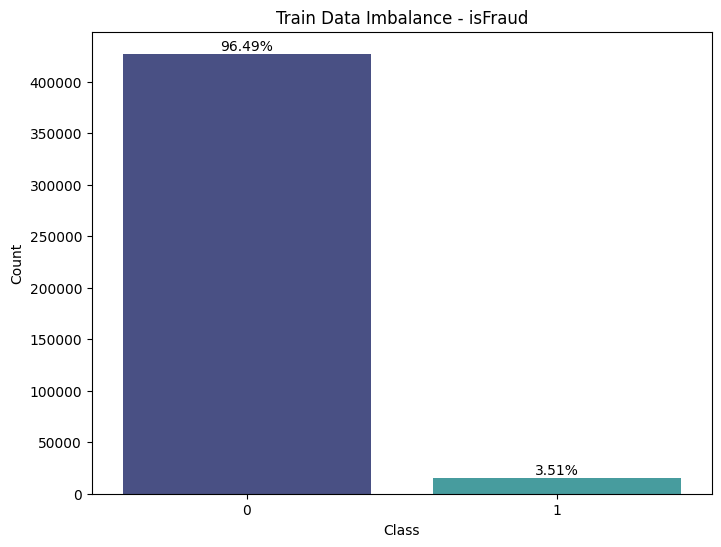

In [421]:
# Train Data
# Count the occurrences of each class in the 'isFraud' column
class_counts = train['isFraud'].value_counts()

# Calculate the percentage distribution
class_percentages = class_counts / len(train) * 100

# Plot the class distribution using Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")

# Adding percentages above the bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 50, f'{class_percentages[i]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title("Train Data Imbalance - isFraud")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


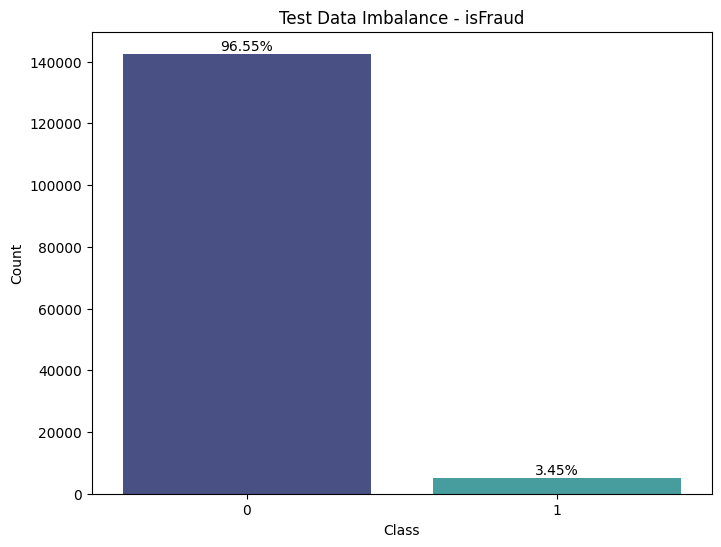

In [422]:
# Test Data
# Count the occurrences of each class in the 'isFraud' column
class_counts = test['isFraud'].value_counts()

# Calculate the percentage distribution
class_percentages = class_counts / len(test) * 100

# Plot the class distribution using Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")

# Adding percentages above the bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 50, f'{class_percentages[i]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title("Test Data Imbalance - isFraud")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [423]:
del class_counts
gc.collect()

2994

#### Handling Missing Values, Feature Elimination By 3 Criterias

Datasets have too much missing values.

In [424]:
# Total missing values of the train data
missing_count = train.isnull().sum()
cell_counts = np.product(train.shape)
missing_sum = missing_count.sum()
print ("%",(round(missing_sum/cell_counts,2)) * 100)

% 45.0


In [425]:
# Total missing values of the test data
missing_count = test.isnull().sum()
cell_counts = np.product(test.shape)
missing_sum = missing_count.sum()
print ("%",(round(missing_sum/cell_counts,2)) * 100)

% 45.0


In [426]:
# columns with no nulls of train (20 columns have no nulls, rest have)
null_counts = train.isnull().sum()

columns_with_no_null = null_counts[null_counts == 0].index

print("\nColumns with No Null Values-train:")
print(columns_with_no_null)



Columns with No Null Values-train:
Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'DT'],
      dtype='object')


In [427]:
# columns with no nulls of test
null_counts = test.isnull().sum()

columns_with_no_null = null_counts[null_counts == 0].index

print("\nColumns with No Null Values-test:")
print(columns_with_no_null)


Columns with No Null Values-test:
Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'V279', 'V280', 'V284', 'V285', 'V286', 'V287',
       'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299',
       'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310',
       'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'DT'],
      dtype='object')


In [428]:
del missing_count, cell_counts, missing_sum, null_counts, columns_with_no_null


It has been observed that a significant number of columns exhibit a pattern of "correlated missing values," where certain rows share missing values in corresponding positions across multiple columns.
Most of them are in the same variable group, this will be a clue for highly correlated variables in the same groups to eliminate later.


In [429]:
# Check for null percentage correlated columns-train
# Create a dictionary to store columns with null percentages > 10%
null_percentage_dict = {}
nan_counts = train.isnull().sum()

for col in train.columns:
    null_percent = (nan_counts[col] / len(train)) * 100
    if null_percent >= 10:
        null_percentage_dict[null_percent] = null_percentage_dict.get(null_percent, []) + [col]

# Sort the dictionary by null percentages
sorted_null_percentage_dict = {k: v for k, v in sorted(null_percentage_dict.items(), reverse=True)}

for null_percent, columns in sorted_null_percentage_dict.items():
    print(f"####### Null Percentage = {null_percent:.2f}%")
    print(columns)


####### Null Percentage = 99.16%
['id_24']
####### Null Percentage = 99.08%
['id_25']
####### Null Percentage = 99.08%
['id_07', 'id_08']
####### Null Percentage = 99.08%
['id_26']
####### Null Percentage = 99.08%
['id_21']
####### Null Percentage = 99.08%
['id_22', 'id_23', 'id_27']
####### Null Percentage = 93.60%
['D7']
####### Null Percentage = 93.11%
['dist2']
####### Null Percentage = 91.95%
['id_18']
####### Null Percentage = 89.48%
['D13']
####### Null Percentage = 89.29%
['D14']
####### Null Percentage = 88.68%
['D12']
####### Null Percentage = 88.37%
['id_03', 'id_04']
####### Null Percentage = 87.44%
['D6']
####### Null Percentage = 86.74%
['D8', 'D9', 'id_09', 'id_10']
####### Null Percentage = 86.57%
['id_33']
####### Null Percentage = 85.60%
['id_30']
####### Null Percentage = 85.60%
['id_32']
####### Null Percentage = 85.59%
['id_34']
####### Null Percentage = 85.14%
['id_14']
####### Null Percentage = 84.82%
['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145

In [430]:
# Check for null percentage correlated columns-test
# Create a dictionary to store columns with null percentages > 10%
null_percentage_dict = {}
nan_counts = test.isnull().sum()

for col in test.columns:
    null_percent = (nan_counts[col] / len(test)) * 100
    if null_percent >= 10:
        null_percentage_dict[null_percent] = null_percentage_dict.get(null_percent, []) + [col]

# Sort the dictionary by null percentages
sorted_null_percentage_dict = {k: v for k, v in sorted(null_percentage_dict.items(), reverse=True)}

for null_percent, columns in sorted_null_percentage_dict.items():
    print(f"####### Null Percentage = {null_percent:.2f}%")
    print(columns)

####### Null Percentage = 99.32%
['id_24']
####### Null Percentage = 99.27%
['id_25']
####### Null Percentage = 99.26%
['id_21']
####### Null Percentage = 99.26%
['id_07', 'id_08']
####### Null Percentage = 99.26%
['id_22', 'id_23', 'id_26', 'id_27']
####### Null Percentage = 95.18%
['dist2']
####### Null Percentage = 93.59%
['id_18']
####### Null Percentage = 92.84%
['D7']
####### Null Percentage = 90.65%
['id_30']
####### Null Percentage = 90.65%
['id_32', 'id_33']
####### Null Percentage = 90.53%
['id_34']
####### Null Percentage = 90.35%
['id_14']
####### Null Percentage = 90.11%
['D12']
####### Null Percentage = 90.04%
['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']
####### Null Percentage = 90.04%
['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
####### Null Percentage = 90.02%
['D14']
####### Null Percentage = 89.98%
['V322', 'V323', 'V324', 'V

In [431]:
# Drop columns by using 3 criteria:
# 1. If a column only has only one distinct value
# 2. If a column has more than 90% null values
# 3. If one of the categories in a column dominates more than 90% of the column
# we are looking for these criterias in train, then dropping the columns from both train and test

# Initialize lists to store columns to be dropped based on different criteria
one_value_cols, many_null_cols, big_top_value_cols = [], [], []

# Iterate through only the train DataFrame
for df in [train]:
    # Identify columns with only one distinct value
    one_value_cols += [col for col in df.columns if df[col].nunique() == 1]
    
    # Identify columns with more than 90% null values
    many_null_cols += [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    
    # Identify columns where a single value dominates more than 90%
    big_top_value_cols += [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

# Combine the lists of columns to be dropped, removing duplicates using set
cols_to_drop = list(set(one_value_cols + many_null_cols + big_top_value_cols))

# Check if 'isFraud' is in the list of columns to be dropped, and remove it if present
if 'isFraud' in cols_to_drop:
    cols_to_drop.remove('isFraud')

# Drop the identified columns from the train DataFrame
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# Print the number of features that are going to be dropped for being considered useless
print(f'{len(cols_to_drop)} features are going to be dropped for being useless')


66 features are going to be dropped for being useless


#### Transaction Date

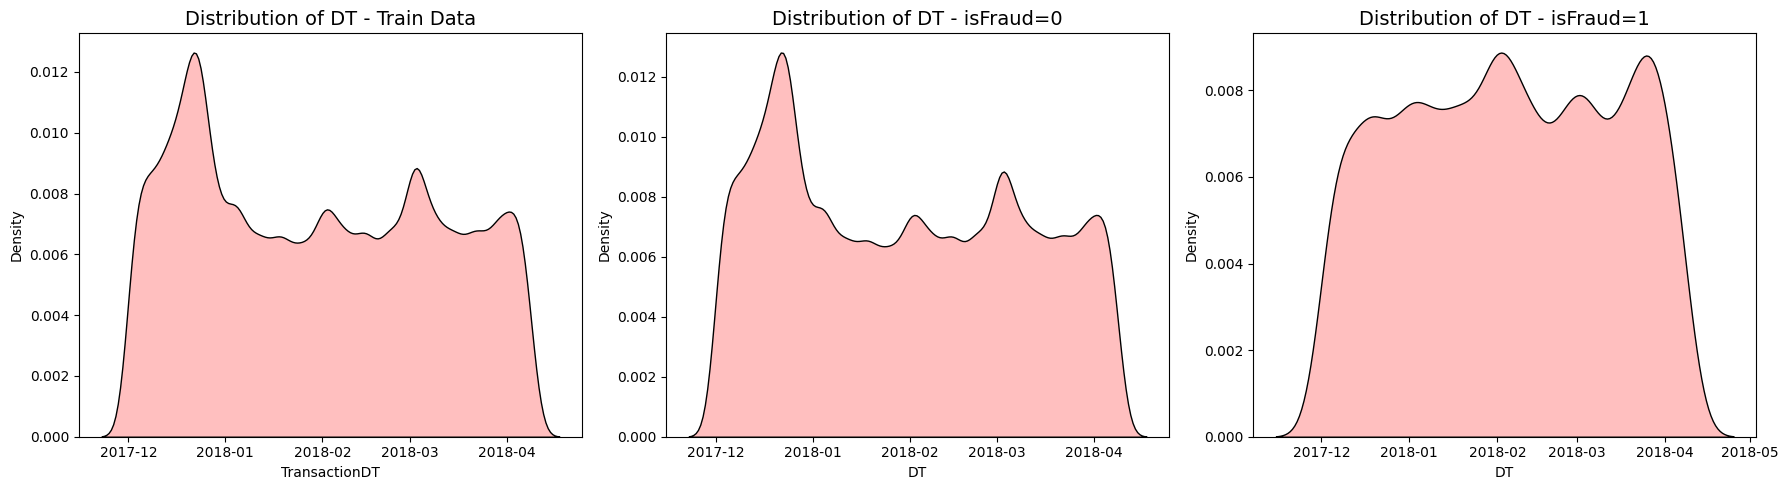

In [432]:
# TransactionDT Dist for Train Transaction Data - Whole Data
time_val_whole = train['DT'].values

# Create a figure
plt.figure(figsize=(18, 5))

# Create a distribution plot for TransactionDT column - Train Data
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot at position 1
sns.kdeplot(time_val_whole, color='r', fill=True, edgecolor='black')
plt.title('Distribution of DT - Train Data', fontsize=14)
plt.xlabel('TransactionDT')

# TransactionDT Dist for Train - isFraud=0
time_val_no_fraud = train['DT'][train['isFraud'] == 0]

# TransactionDT Dist for Train - isFraud=1
time_val_fraud = train['DT'][train['isFraud'] == 1]

# Create subplots for isFraud=0 and isFraud=1
for i, time_val in enumerate([time_val_no_fraud, time_val_fraud], start=2):
    plt.subplot(1, 3, i)
    sns.kdeplot(time_val, color='r', fill=True, edgecolor='black')
    plt.title(f'Distribution of DT - isFraud={i-2}', fontsize=14)
    plt.xlabel('DT')
    

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

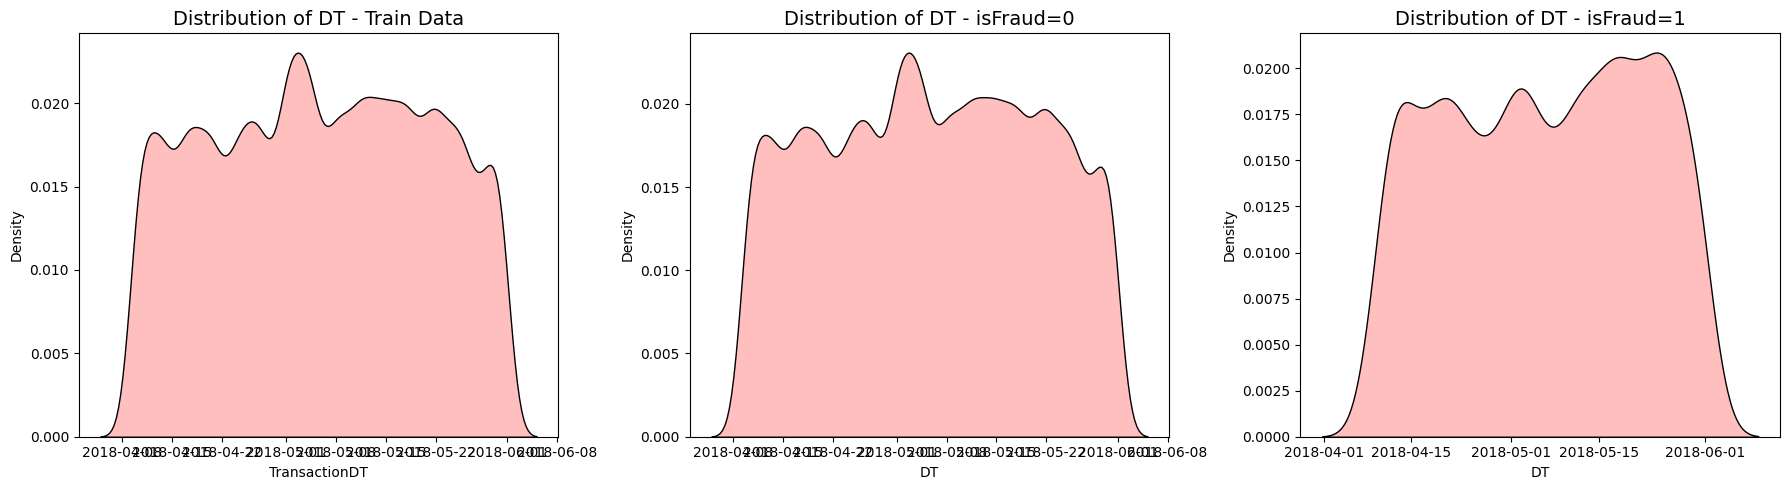

In [433]:
# TransactionDT Dist for Train Transaction Data - Test Data
time_val_whole = test['DT'].values

# Create a figure
plt.figure(figsize=(18, 5))

# Create a distribution plot for TransactionDT column - Whole Data
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot at position 1
sns.kdeplot(time_val_whole, color='r', fill=True, edgecolor='black')
plt.title('Distribution of DT - Train Data', fontsize=14)
plt.xlabel('TransactionDT')

# TransactionDT Dist for Train Transaction Data - isFraud=0
time_val_no_fraud = test['DT'][test['isFraud'] == 0]

# TransactionDT Dist for Train Transaction Data - isFraud=1
time_val_fraud = test['DT'][test['isFraud'] == 1]

# Create subplots for isFraud=0 and isFraud=1
for i, time_val in enumerate([time_val_no_fraud, time_val_fraud], start=2):
    plt.subplot(1, 3, i)
    sns.kdeplot(time_val, color='r', fill=True, edgecolor='black')
    plt.title(f'Distribution of DT - isFraud={i-2}', fontsize=14)
    plt.xlabel('DT')
    

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Transaction_day_of_week

In [434]:
#creating new columns named "Transaction_day_of_week" in both the train and test.
#The resulting values will be integers representing the day of the week (Monday is 0 and Sunday is 6).
train['Transaction_day_of_week'] = train['DT'].dt.dayofweek
test['Transaction_day_of_week'] = test['DT'].dt.dayofweek

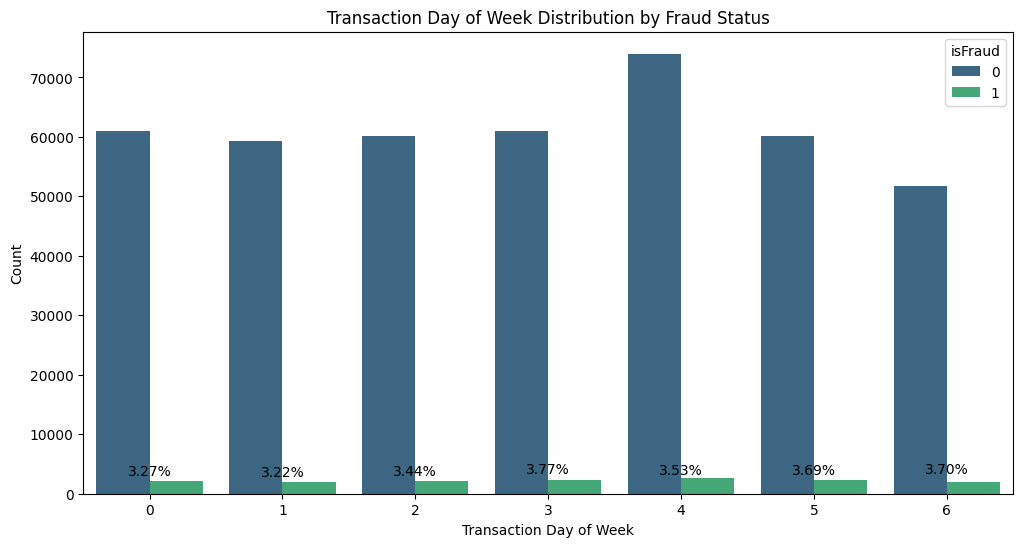

In [435]:
# Calculate fraud rates for each day of the week
fraud_rates = train.groupby('Transaction_day_of_week')['isFraud'].mean()

# Plot settings
plt.figure(figsize=(12, 6))
sns.countplot(x='Transaction_day_of_week', hue='isFraud', data=train, palette='viridis')

# Plot fraud rates
for i, rate in enumerate(fraud_rates):
    plt.text(i, rate * train['Transaction_day_of_week'].value_counts(dropna=False).max(), f'{rate:.2%}', ha='center', va='bottom')

# Plot labels and title
plt.title('Transaction Day of Week Distribution by Fraud Status')
plt.xlabel('Transaction Day of Week')
plt.ylabel('Count')

# Show the plot
plt.show()

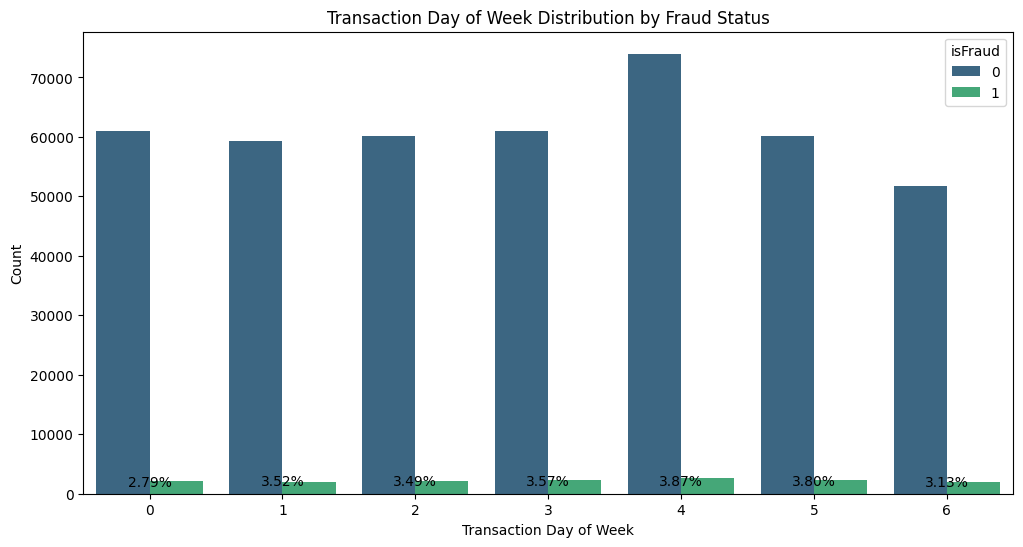

In [436]:
# Calculate fraud rates for each day of the week
fraud_rates = test.groupby('Transaction_day_of_week')['isFraud'].mean()

# Plot settings
plt.figure(figsize=(12, 6))
sns.countplot(x='Transaction_day_of_week', hue='isFraud', data=train, palette='viridis')

# Plot fraud rates
for i, rate in enumerate(fraud_rates):
    plt.text(i, rate * test['Transaction_day_of_week'].value_counts(dropna=False).max(), f'{rate:.2%}', ha='center', va='bottom')

# Plot labels and title
plt.title('Transaction Day of Week Distribution by Fraud Status')
plt.xlabel('Transaction Day of Week')
plt.ylabel('Count')

# Show the plot
plt.show()

In [437]:
# Perform one-hot encoding for Transaction_day_of_week column on train
TransactionDay_OHE = pd.get_dummies(train['Transaction_day_of_week'], prefix='Transaction_day', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, TransactionDay_OHE], axis=1)

In [438]:
# Perform one-hot encoding for Transaction_day_of_week column on train
TransactionDay_OHE = pd.get_dummies(test['Transaction_day_of_week'], prefix='Transaction_day', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, TransactionDay_OHE], axis=1)

In [439]:
# original 'Transaction_day_of_week' column dropped
train.drop('Transaction_day_of_week', axis=1, inplace=True)
test.drop('Transaction_day_of_week', axis=1, inplace=True)

Transaction_hour_of_day

In [440]:
# extracting the hour information from the "DT" column (ranging from 0 to 23)
train['Transaction_hour_of_day'] = train['DT'].dt.hour
test['Transaction_hour_of_day'] = test['DT'].dt.hour

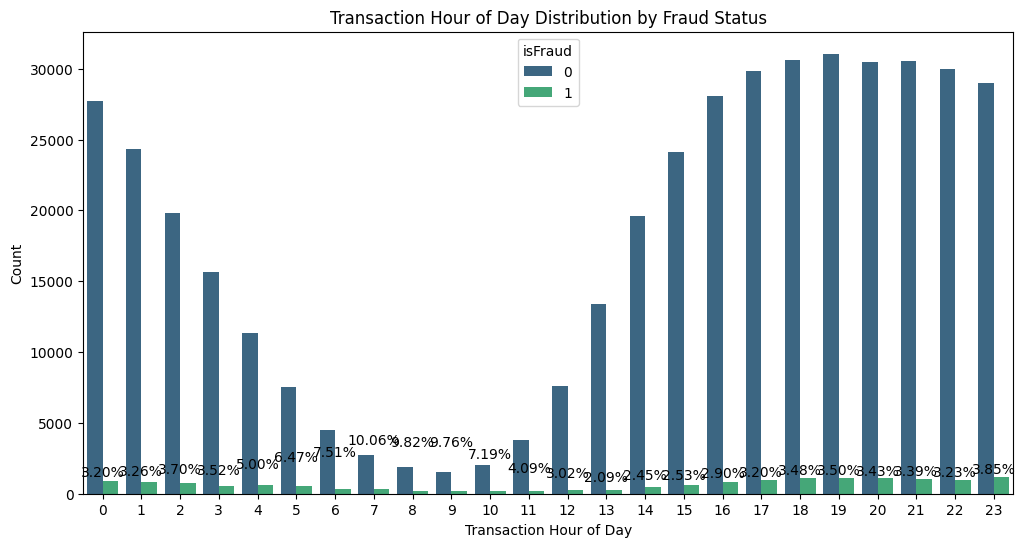

In [441]:
# Ploting transaction hour with fraud info
# Calculate fraud rates for each hour of the day
fraud_rates_hour = train.groupby('Transaction_hour_of_day')['isFraud'].mean()

# Plot settings
plt.figure(figsize=(12, 6))
sns.countplot(x='Transaction_hour_of_day', hue='isFraud', data=train, palette='viridis')

# Plot fraud rates
for i, rate in enumerate(fraud_rates_hour):
    plt.text(i, rate * train['Transaction_hour_of_day'].value_counts().max(), f'{rate:.2%}', ha='center', va='bottom')

# Plot labels and title
plt.title('Transaction Hour of Day Distribution by Fraud Status')
plt.xlabel('Transaction Hour of Day')
plt.ylabel('Count')

# Show the plot
plt.show()

In [442]:
# Perform one-hot encoding for Transaction_hour_of_day-train
one_hot_encoded = pd.get_dummies(train['Transaction_hour_of_day'], prefix='Transaction_hour', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrame
train = pd.concat([train, one_hot_encoded], axis=1)

In [443]:
# Perform one-hot encoding for Transaction_hour_of_day-test
one_hot_encoded = pd.get_dummies(test['Transaction_hour_of_day'], prefix='Transaction_hour', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrame
test = pd.concat([test, one_hot_encoded], axis=1)

In [444]:
# original 'Transaction_hour_of_day' column dropped
train.drop('Transaction_hour_of_day', axis=1, inplace=True)
test.drop('Transaction_hour_of_day', axis=1, inplace=True)

#### Transaction Amount

In [445]:
column_details(regex='TransactionAmt', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionAmt:  float64, 17111, %0.0
[2.5100000e-01 2.7200000e-01 2.9200000e-01 ... 6.0852300e+03 6.4509700e+03
 3.1937391e+04]



Text(0.5, 1.0, 'Test')

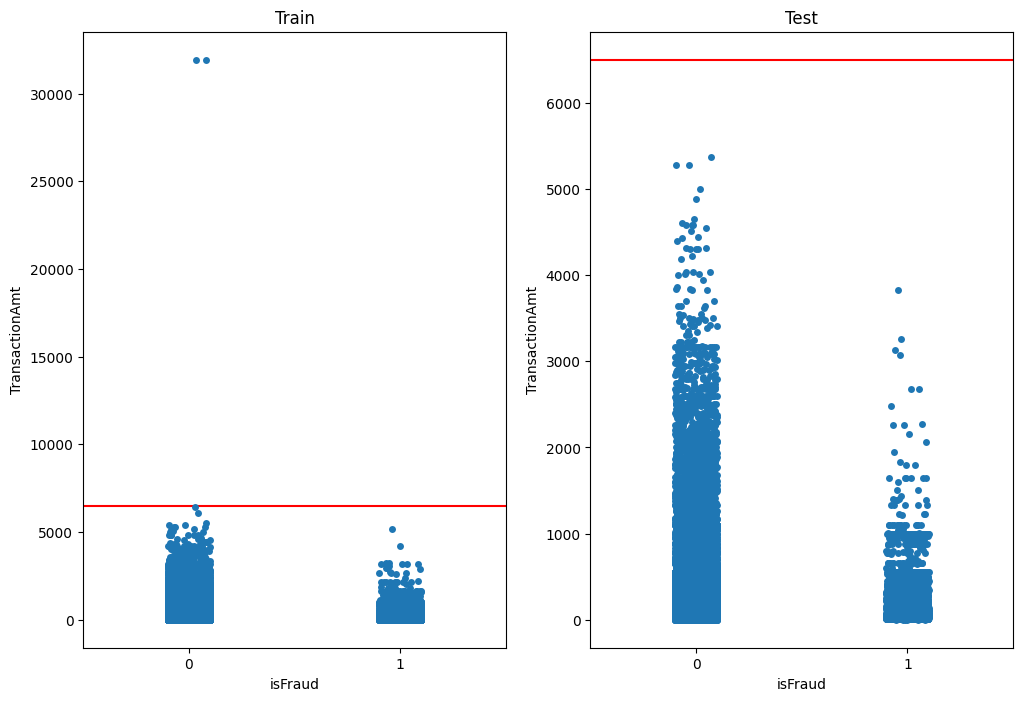

In [446]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='TransactionAmt', x='isFraud', data=train)
plt.axhline(6500, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='TransactionAmt', x='isFraud', data=test)
plt.axhline(6500, color='red')
plt.title('Test')

In [447]:
max_transaction_amount = train['TransactionAmt'][train['TransactionAmt'] < 30000].max()
print(f"The maximum transaction amount below 30000 is: {max_transaction_amount}")


The maximum transaction amount below 30000 is: 6450.97


There are outliers in Transaction_Amount with isFraud == 0. These amounts are above 30k. 
I find the maximum amount below 30k ( 6450.97 ). I will capped the Train transaction with 6450.97 below code.

In [448]:
# Identify transactions with isFraud == 0 and TransactionAmt above 6450.97
condition = train['TransactionAmt'] > 6450.97

# Cap the TransactionAmt at 5368 for the identified transactions
train.loc[condition, 'TransactionAmt'] = 6450.97

In [449]:
train['TransactionAmt'].max()

6450.97

In [450]:
print('Avg Transaction Amount by Frauds-Train', train[train.isFraud==1]['TransactionAmt'].mean())
print('Avg Transaction Amount by Non-Frauds-Train', train[train.isFraud==0]['TransactionAmt'].mean())
print('Avg Transaction Amount-Train',train['TransactionAmt'].mean())
print('Avg Transaction Amount-Test', test['TransactionAmt'].mean() )

Avg Transaction Amount by Frauds-Train 147.32386647818544


Avg Transaction Amount by Non-Frauds-Train 133.7389101726486
Avg Transaction Amount-Train 134.2162646278547
Avg Transaction Amount-Test 137.11464901954145


The averages of TransactionAmt of train and test datasets are nearly same. The average of the fraud transactions(147.32) is bigger than the average of the non-fraud transactions(133.73).
The average transaction amount for fraudulent transactions appears to be higher than that for legitimate transactions. Statistically, the average transaction amount for fraudulent transactions is 147.32 units, whereas the average amount for legitimate transactions is 133.74 units. This observation indicates that fraudulent transactions tend to involve higher amounts

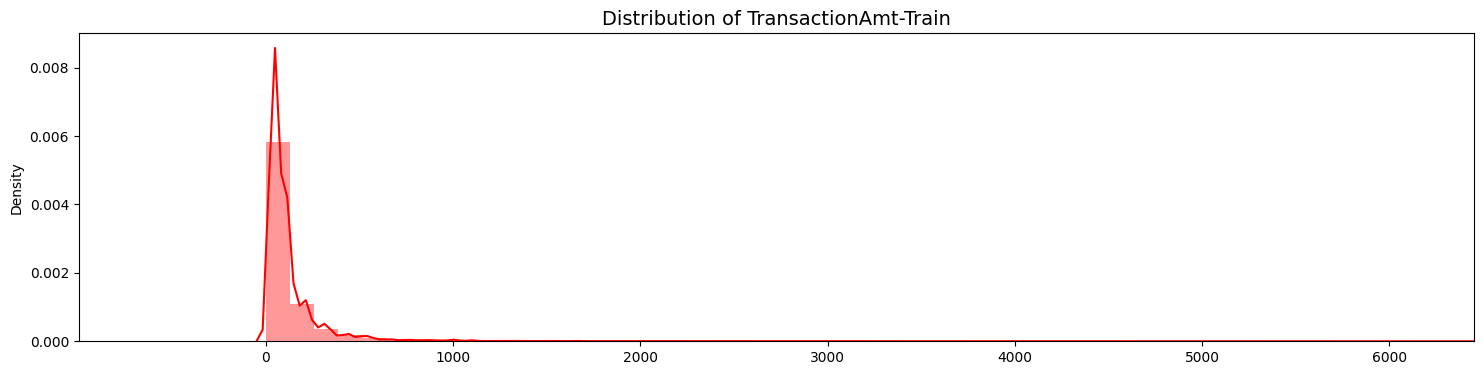

In [451]:
#Distribution of TransactionAmt-Train
time_val = train['TransactionAmt'].values

plt.figure(figsize=(18, 4))
sns.distplot(time_val, color='r')
plt.title('Distribution of TransactionAmt-Train', fontsize=14)
plt.xlim([min(time_val)-1000, max(time_val)])  

# Show the plot
plt.show()

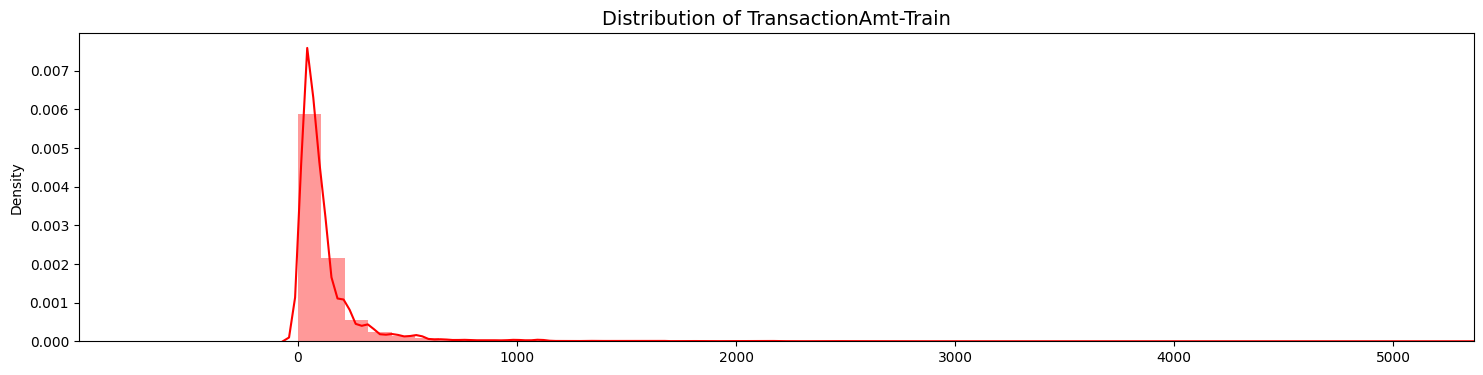

In [452]:
#Distribution of TransactionAmt-Train
time_val = test['TransactionAmt'].values

plt.figure(figsize=(18, 4))
sns.distplot(time_val, color='r')
plt.title('Distribution of TransactionAmt-Train', fontsize=14)
plt.xlim([min(time_val)-1000, max(time_val)])  

# Show the plot
plt.show()

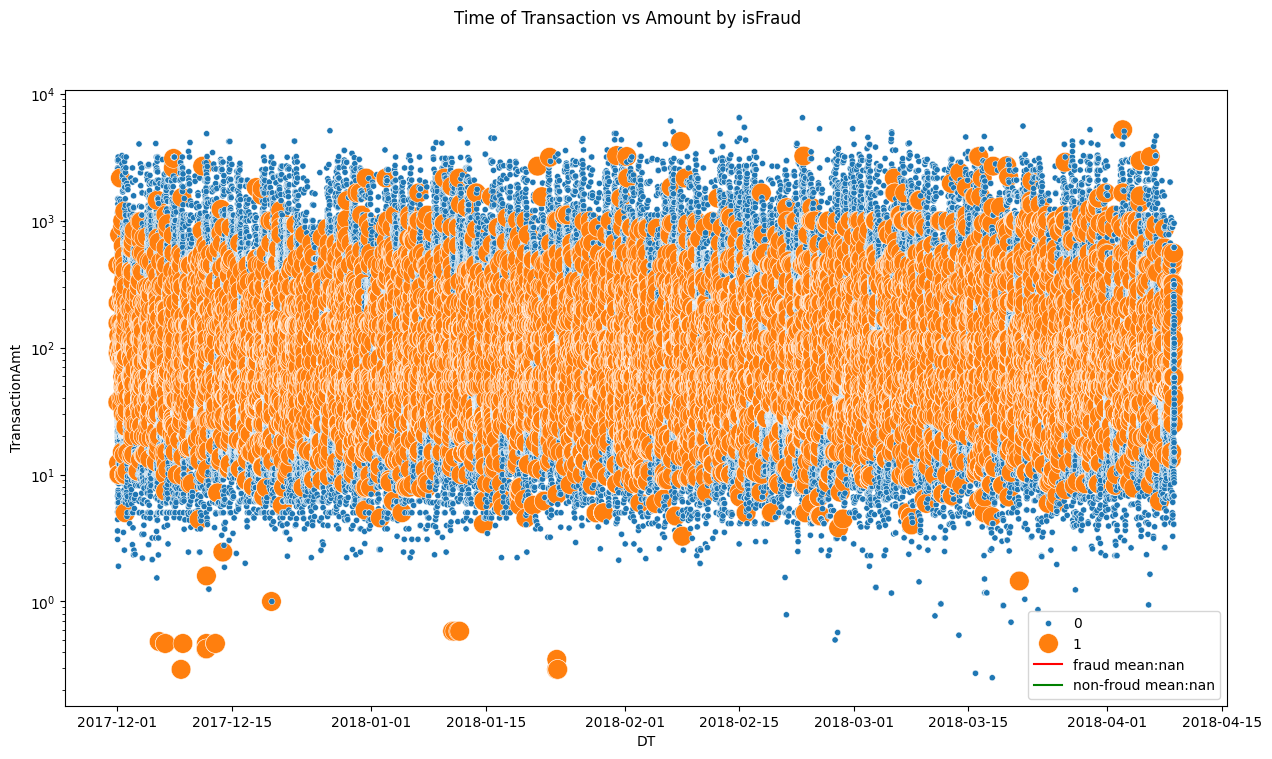

In [453]:
plt.figure(figsize=(15,8))
plt.suptitle('Time of Transaction vs Amount by isFraud')
fraud_mean, nonfraud_mean = train[train.isFraud=='1']['TransactionAmt'].mean(), train[train.isFraud=='0']['TransactionAmt'].mean()
sns.scatterplot(x=train['DT'], y=train['TransactionAmt'], data=train, hue='isFraud', size="isFraud", sizes=(200, 20))
plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
plt.axhline(y=nonfraud_mean, color='green',label=f'non-froud mean:{round(nonfraud_mean,2)}')
plt.legend()

plt.yscale('log')
plt.show()

In [454]:
# Extracting the decimal point of the transaction amount as a new variable
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

#### ProductCD : product code, the product for each transaction (nominal categorical)

In [455]:
for df in [train, test]:
  column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



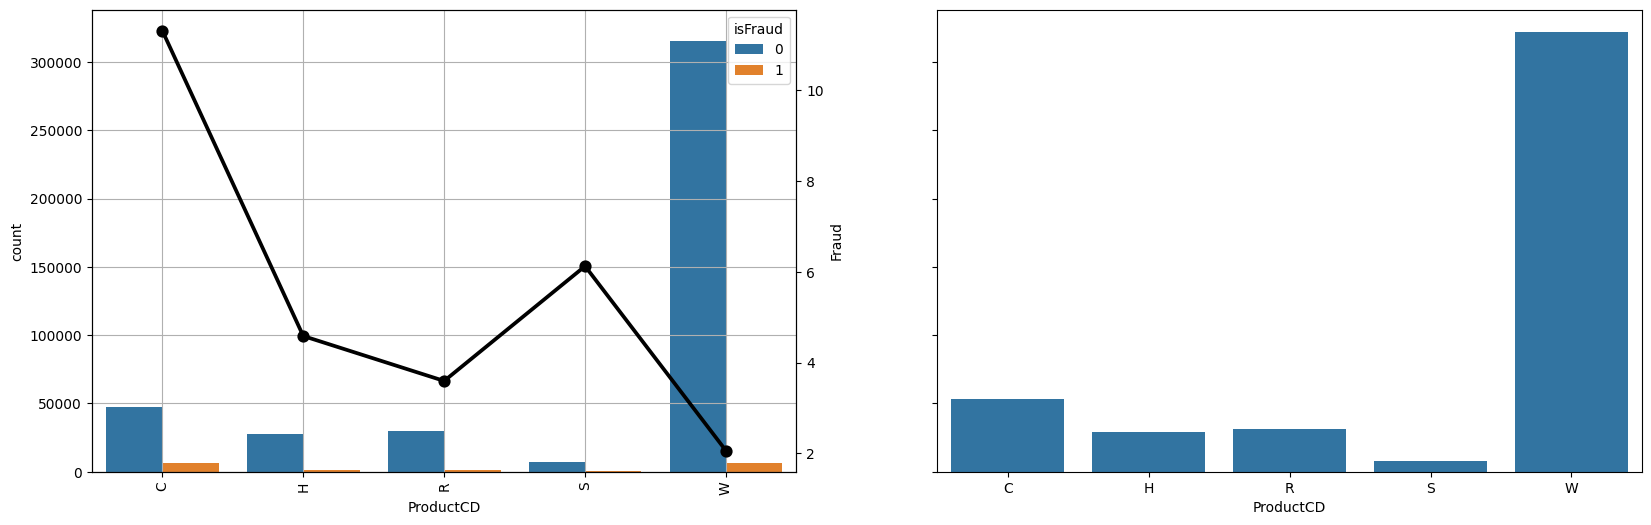

In [456]:
# Distribution of ProductCD column-Train
plot_col('ProductCD', df=train)


In [457]:
train.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.113070
H    0.045851
R    0.035957
S    0.061235
W    0.020594
Name: isFraud, dtype: float64

In [458]:
test.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.130155
H    0.060270
R    0.046578
S    0.054754
W    0.019867
Name: isFraud, dtype: float64

* C, H, R, S, W values are unknown from data definition.

Probably their meaning:
* C (Credit): Credit card transactions
* H (Debit): Debit card or ATM card transactions
* R (Charge Card): Charge card transactions
* S (Cash): Cash transactions
* W (Wallet): Transactions made with digital wallets or payment applications

'W' has the highest frequency, while 'S' has the lowest.
Most fraud activities realized by C product code. (11%) Least fraud activities with W product ccode. (2%) This could indicate that a C product category is more strongly associated with fraud. The probabilities of fraud for other categories (H, R, S, W) are lower, but the contribution of these categories may still be significant. 


In [459]:
train['ProductCD'].value_counts(dropna=False)

ProductCD
W    322086
C     53268
R     31065
H     28876
S      7610
Name: count, dtype: int64

In [460]:
test['ProductCD'].value_counts(dropna=False)

ProductCD
W    117584
C     15251
R      6634
H      4148
S      4018
Name: count, dtype: int64

In [461]:
# Perform one-hot encoding for ProductCD column on train
ProductCD_OHE = pd.get_dummies(train['ProductCD'], prefix='ProductCD', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, ProductCD_OHE], axis=1)


In [462]:
# Perform one-hot encoding for ProductCD column on train
ProductCD_OHE = pd.get_dummies(test['ProductCD'], prefix='ProductCD', drop_first=False, dtype=int)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, ProductCD_OHE], axis=1)

In [463]:
# original 'ProductCD' column dropped
train.drop('ProductCD', axis=1, inplace=True)
test.drop('ProductCD', axis=1, inplace=True)

In [464]:
gc.collect()

24867

#### Card1-Card6 : payment card information, such as card type, card category, issue bank, country (nominal categorical)

In [465]:
column_details(regex='^card\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE



card1:  object, 12485, %0.0
['1000' '10000' '10003' ... '9997' '9998' '9999']

card2:  object, 500, %1.53
['100.0' '101.0' '102.0' '103.0' '104.0' '105.0' '106.0' '108.0' '109.0'
 '110.0' '111.0' '112.0' '113.0' '114.0' '115.0' '116.0' '117.0' '118.0'
 '119.0' '120.0' '121.0' '122.0' '123.0' '124.0' '125.0' '126.0' '127.0'
 '128.0' '129.0' '130.0' '131.0' '132.0' '133.0' '134.0' '135.0' '136.0'
 '137.0' '138.0' '139.0' '140.0' '141.0' '142.0' '143.0' '144.0' '145.0'
 '146.0' '147.0' '148.0' '149.0' '150.0' '151.0' '152.0' '153.0' '154.0'
 '155.0' '156.0' '157.0' '158.0' '159.0' '160.0' '161.0' '162.0' '163.0'
 '164.0' '165.0' '166.0' '167.0' '168.0' '169.0' '170.0' '171.0' '172.0'
 '173.0' '174.0' '175.0' '176.0' '177.0' '178.0' '179.0' '180.0' '181.0'
 '182.0' '183.0' '184.0' '185.0' '186.0' '187.0' '188.0' '189.0' '190.0'
 '191.0' '192.0' '193.0' '194.0' '195.0' '196.0' '197.0' '198.0' '199.0'
 '200.0' '201.0' '202.0' '203.0' '204.0' '205.0' '206.0' '207.0' '208.0'
 '209.0' '210.0' '

In [466]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
for i in cards:
    print ("Unique ",i, " = ",train[i].nunique())

Unique  card1  =  12485
Unique  card2  =  500
Unique  card3  =  106
Unique  card4  =  4
Unique  card5  =  111
Unique  card6  =  4


Card4 and Card6 has 4 distinct value, I will observe the distributions of fraud activities in these columns.

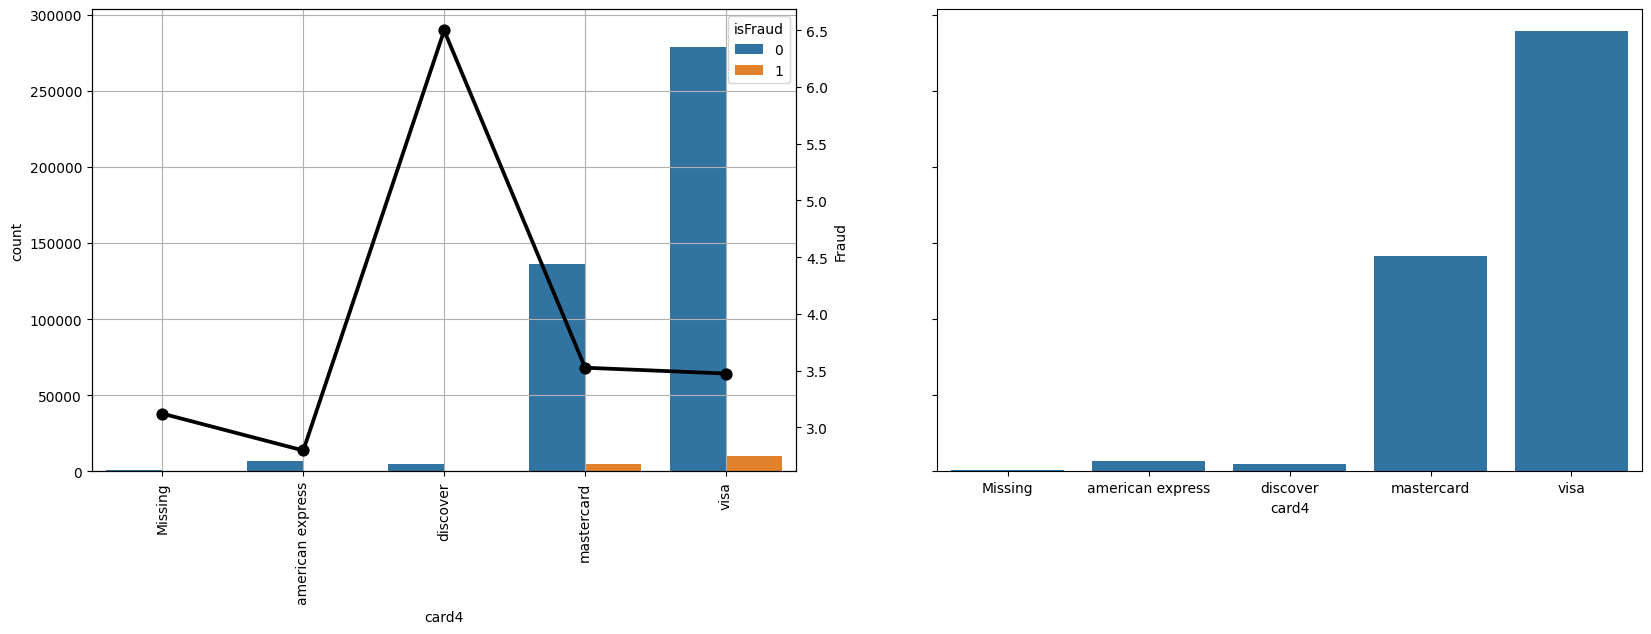

In [467]:
# card4 seems to be credit card company
# to show the most used Brand of electronic cards for fraud transactions in the train dataset
plot_col("card4", df=train)

In [468]:
train.groupby('card4')['isFraud'].mean()

card4
american express    0.027966
discover            0.064971
mastercard          0.035260
visa                0.034743
Name: isFraud, dtype: float64

In [469]:
test.groupby('card4')['isFraud'].mean()

card4
american express    0.032351
discover            0.115575
mastercard          0.031600
visa                0.034795
Name: isFraud, dtype: float64

In [470]:
train['card4'].value_counts(dropna=False)

card4
visa                288892
mastercard          141210
american express      6937
discover              5033
NaN                    833
Name: count, dtype: int64

In [471]:
test['card4'].value_counts(dropna=False)

card4
visa                95875
mastercard          48007
discover             1618
american express     1391
NaN                   744
Name: count, dtype: int64

In [472]:
# Perform one-hot encoding for card4 column on train
card4_OHE = pd.get_dummies(train['card4'], prefix='card4', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, card4_OHE], axis=1)


In [473]:
# Perform one-hot encoding for card4 column on test
card4_OHE = pd.get_dummies(test['card4'], prefix='card4', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, card4_OHE], axis=1)

In [474]:
# original 'card4' column dropped
train.drop('card4', axis=1, inplace=True)
test.drop('card4', axis=1, inplace=True)

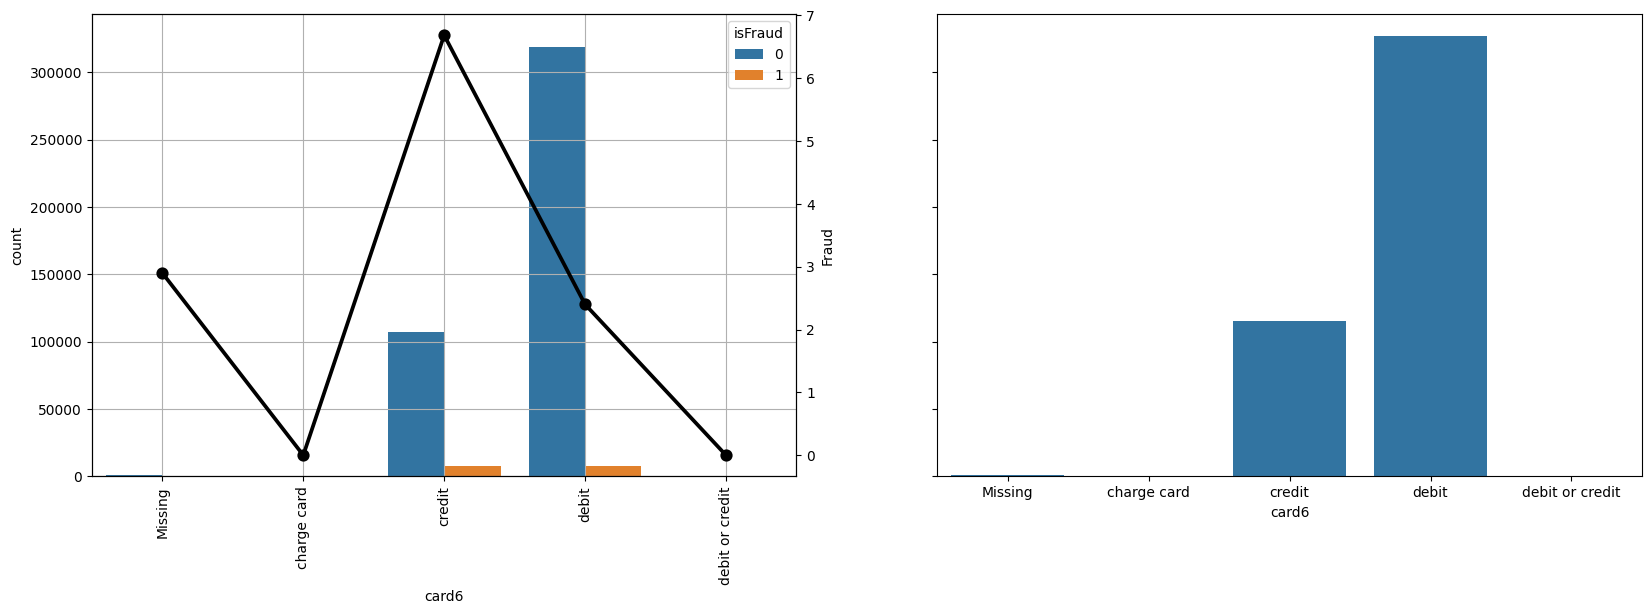

In [475]:
# card6 seems to be type of card  
# to show the most used method of transaction with cards for fraud activities in the train dataset
plot_col("card6", df=train)

In [476]:
train['card6'].value_counts(dropna=False)

card6
debit              326866
credit             115166
NaN                   828
debit or credit        30
charge card            15
Name: count, dtype: int64

In [477]:
# Because number of instances so low in two cats, i will map them into the category with highest freq. 
# Map 'debit or credit' and 'charge card' values to 'debit'
train['card6'] = train['card6'].map({'debit or credit': 'debit', 'charge card': 'debit'}).fillna(train['card6'])

In [478]:
train['card6'].value_counts(dropna=False)

card6
debit     326911
credit    115166
NaN          828
Name: count, dtype: int64

In [479]:
test['card6'].value_counts(dropna=False)

card6
debit     113072
credit     33820
NaN          743
Name: count, dtype: int64

In [480]:
# Perform one-hot encoding for card6 column on train
card6_OHE = pd.get_dummies(train['card6'], prefix='card6', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, card6_OHE], axis=1)


In [481]:
# Perform one-hot encoding for card6 column on test
card6_OHE = pd.get_dummies(test['card6'], prefix='card6', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, card6_OHE], axis=1)

In [482]:
# original 'card6' column dropped
train.drop('card6', axis=1, inplace=True)
test.drop('card6', axis=1, inplace=True)

Card1: The 'Card 1' column, originally designated as categorical, exhibits behavior akin to continuous data, featuring a substantial '12485' unique values.

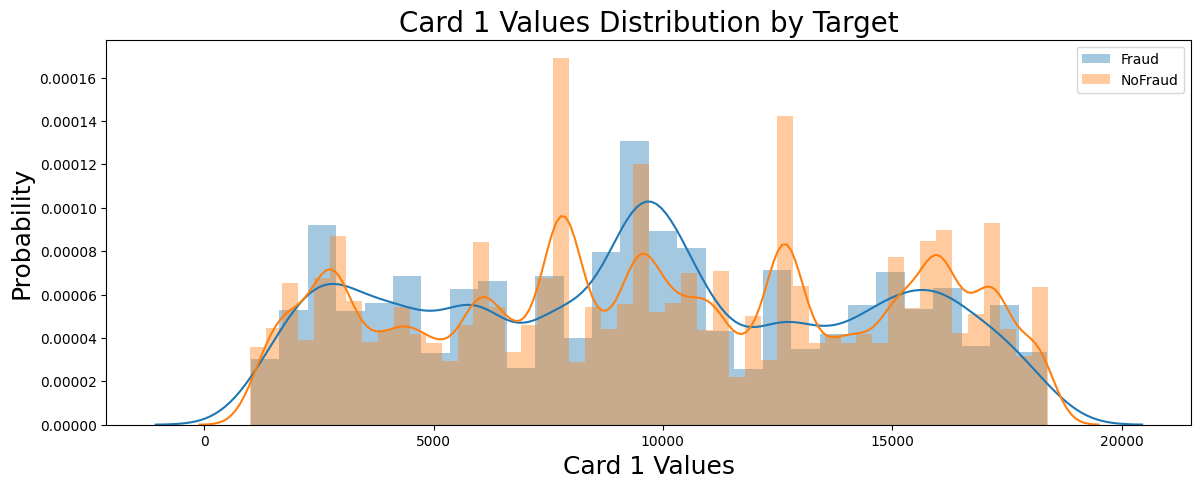

In [483]:
tmp = pd.crosstab(train['card1'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14, 5))
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.show()

In [484]:
pd.to_numeric(train['card1'], errors='coerce').min()

1000

In [485]:
pd.to_numeric(train['card1'], errors='coerce').max()

18396

In [486]:
pd.to_numeric(test['card1'], errors='coerce').min()

1004

In [487]:
pd.to_numeric(test['card1'], errors='coerce').max()

18395

In [488]:
# I will replace the type of the column object to numerical because the variable seems to be continious one.
train['card1'] = pd.to_numeric(train['card1'], errors='coerce')
test['card1'] = pd.to_numeric(test['card1'], errors='coerce')

In [489]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_2.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_2.pkl')


In [490]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_2.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_2.pkl')

In [491]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

Card2, Card3, Card5

In [492]:
# For card2, card3 and card5 there are many categories with frequency below 200 in train. I change these categories' names to 'Other'

threshold = 200

#Card2
# Identify 'other' categories in the training set
train_card2_counts = train['card2'].value_counts()
train_unique_card2_other = set(train_card2_counts.index[train_card2_counts < threshold])
train['card2'] = train['card2'].apply(lambda x: 'other' if not pd.isna(x) and train_card2_counts[x] < threshold else x)

#Card3
# Identify 'other' categories in the training set
train_card3_counts = train['card3'].value_counts()
train_unique_card3_other = set(train_card3_counts.index[train_card3_counts < threshold])
train['card3'] = train['card3'].apply(lambda x: 'other' if not pd.isna(x) and train_card3_counts[x] < threshold else x)

#Card5
# Identify 'other' categories in the training set
train_card5_counts = train['card5'].value_counts()
train_unique_card5_other = set(train_card5_counts.index[train_card5_counts < threshold])
train['card5'] = train['card5'].apply(lambda x: 'other' if not pd.isna(x) and train_card5_counts[x] < threshold else x)


In [493]:
# Apply the same transformation to the test set as in the training set, where categories with counts below the threshold are assigned as 'other' in train ( use the categories assigned 'other' in train).
# If the test set has a category that was not present in the training set, set that category to NaN

#Card2
# Apply the 'other' categories identified in the training set to the 'card2' column in the test set
test['card2'] = test['card2'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_card2_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test = set(test['card2'].dropna().unique()) - set(train['card2'].dropna().unique())
test['card2'] = test['card2'].apply(lambda x: np.nan if x in new_categories_in_test else x)

#Card3
# Apply the 'other' categories identified in the training set to the 'card3' column in the test set
test['card3'] = test['card3'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_card3_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test = set(test['card3'].dropna().unique()) - set(train['card3'].dropna().unique())
test['card3'] = test['card3'].apply(lambda x: np.nan if x in new_categories_in_test else x)

#Card5
# Apply the 'other' categories identified in the training set to the 'card5' column in the test set
test['card5'] = test['card5'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_card5_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test = set(test['card5'].dropna().unique()) - set(train['card5'].dropna().unique())
test['card5'] = test['card5'].apply(lambda x: np.nan if x in new_categories_in_test else x)

In [494]:
# after changing some categories to other, the unique value in each column as follows;
cards = ['card2', 'card3', 'card5']
for i in cards:
    print ("Unique ",i, " = ",train[i].nunique())

Unique  card2  =  187
Unique  card3  =  13
Unique  card5  =  31


One hot encoding is a common technique used to handle nominal categorical data by converting each category into a binary column. While label encoding can be suitable for ordinal categorical data, it's not the best choice for nominal categorical data due to its inherent ordering. Target encoding provides an effective solution for nominal categorical data.
In here from card2 to card6 we will use target encoding.

In [495]:
# Target Encoding
# List of columns to process (Number of unique values below 200) (taking into account the average of the target feature in train set)
columns_to_process = ['card2', 'card3', 'card5']

# Loop through each column
for col in columns_to_process:
    # Calculate target encoding for the current column
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
    
    # Create a new column with the target encoding values
    train[f'{col}_target_encoded'] = train[col].replace(temp_dict)
    test[f'{col}_target_encoded'] = test[col].replace(temp_dict)

    # saving mapping from original value to encoded value
    import json
    with open('model_v5/list-'+col+'-to-'+col+'_target_encoded.json', 'w') as json_file:
        json.dump(temp_dict, json_file, indent=4)

In [496]:
# List of original columns to drop
columns_to_drop = ['card2', 'card3', 'card5']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)


In [497]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_3.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_3.pkl')


In [498]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_3.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_3.pkl')

In [499]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

#### addr1 and addr2: Address information related to the transaction (nominal categorical)
Probably addr1 - subzone / add2 - Country

addr1

In [500]:
for df in [train, test]:
  column_details(regex='addr', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

addr1:  object, 321, %11.45
['100.0' '101.0' '102.0' '104.0' '105.0' '106.0' '110.0' '111.0' '112.0'
 '113.0' '117.0' '119.0' '120.0' '122.0' '123.0' '124.0' '125.0' '126.0'
 '127.0' '128.0' '129.0' '130.0' '131.0' '132.0' '133.0' '134.0' '137.0'
 '139.0' '141.0' '142.0' '143.0' '144.0' '145.0' '146.0' '148.0' '151.0'
 '152.0' '153.0' '154.0' '155.0' '156.0' '157.0' '158.0' '159.0' '160.0'
 '161.0' '162.0' '163.0' '164.0' '166.0' '167.0' '168.0' '170.0' '171.0'
 '172.0' '174.0' '177.0' '178.0' '180.0' '181.0' '182.0' '183.0' '184.0'
 '185.0' '187.0' '189.0' '190.0' '191.0' '193.0' '194.0' '195.0' '196.0'
 '198.0' '199.0' '200.0' '201.0' '202.0' '203.0' '204.0' '205.0' '208.0'
 '210.0' '211.0' '213.0' '214.0' '215.0' '216.0' '217.0' '218.0' '219.0'
 '220.0' '221.0' '223.0' '224.0' '225.0' '226.0' '227.0' '231.0' '232.0'
 '233.0' '234.0' '235.0' '236.0' '239.0' '241.0' '242.0' '243.0' '244.0'
 '247.0' '248.0' '249.0' '250

In [501]:
# First ten most frequent adddress1 values in train
print ("Unique Subzones = ",train['addr1'].nunique())

print('\nFirst Ten Address-1')
print('--------------------')
train.addr1.value_counts().head(9)

Unique Subzones =  321

First Ten Address-1
--------------------


addr1
299.0    35042
325.0    31781
204.0    31261
264.0    29697
330.0    18576
315.0    17250
441.0    15527
272.0    15108
123.0    11935
Name: count, dtype: int64

In [502]:
# before changing some categories to other, the unique value in addr1 column as follows;
print ("Unique addr1 = ", train['addr1'].nunique())

Unique addr1 =  321


In [503]:
# check addr1 column to define the threshold of other category
result = train.groupby('addr1')['isFraud'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
result.to_clipboard()

In [504]:
# For addr1 there are many categories with frequency below 1000 in train. I change these categories' names to 'Other'
threshold = 1000

# Identify 'other' categories in the training set
train_addr1_counts = train['addr1'].value_counts()
train_unique_addr1_other = set(train_addr1_counts.index[train_addr1_counts < threshold])
train['addr1'] = train['addr1'].apply(lambda x: 'other' if not pd.isna(x) and train_addr1_counts[x] < threshold else x)

In [505]:
# Apply the same transformation to the test set as in the training set, where categories with counts below the threshold are assigned as 'other' in train ( use the categories assigned 'other' in train).
# If the test set has a category that was not present in the training set, set that category to NaN

#addr1
# Apply the 'other' categories identified in the training set to the 'addr1' column in the test set
test['addr1'] = test['addr1'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_addr1_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test_addr1 = set(test['addr1'].dropna().unique()) - set(train['addr1'].dropna().unique())
test['addr1'] = test['addr1'].apply(lambda x: np.nan if x in new_categories_in_test_addr1 else x)


In [506]:
# after changing some categories to other, the unique value in addr1 column as follows;
print ("Unique addr1 = ", train['addr1'].nunique())

Unique addr1 =  49


addr2

In [507]:
# check addr2 column to define the threshold of other category
result = train.groupby('addr2')['isFraud'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
result.to_clipboard()

In [508]:
print ("Unique Countries = ",train['addr2'].nunique())

print('\nFirst Ten Address-2')
print('--------------------')
train.addr2.value_counts().head(9)

Unique Countries =  69

First Ten Address-2
--------------------


addr2
87.0    388434
60.0      2677
96.0       542
32.0        83
65.0        74
16.0        48
31.0        45
19.0        29
26.0        20
Name: count, dtype: int64

In [509]:
# For addr2 there are many categories with frequency below 50 in train. I change these categories' names to 'Other'
threshold_addr2 = 50

# Identify 'other' categories in the training set
train_addr2_counts = train['addr2'].value_counts()
train_unique_addr2_other = set(train_addr2_counts.index[train_addr2_counts < threshold_addr2])
train['addr2'] = train['addr2'].apply(lambda x: 'other' if not pd.isna(x) and train_addr2_counts[x] < threshold_addr2 else x)

In [510]:
# Apply the 'other' categories identified in the training set to the 'addr2' column in the test set
test['addr2'] = test['addr2'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_addr2_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test_addr2 = set(test['addr2'].dropna().unique()) - set(train['addr2'].dropna().unique())
test['addr2'] = test['addr2'].apply(lambda x: np.nan if x in new_categories_in_test_addr2 else x)


In [511]:
# after changing some categories to other, the unique value in addr2 column as follows;
print ("Unique addr2 = ", train['addr2'].nunique())

Unique addr2 =  6


new addr column

In [512]:
# By combining addr1 and addr2 , I create a new addr column
for df in [train, test]:
    # Combine 'addr2' and 'addr1' columns as strings, separated by an underscore
    df['addr'] = (df['addr2'].astype(str) + '_' + df['addr1'].astype(str)).replace({'nan_nan': np.nan})

In [513]:
# check addr column to define the threshold of other category
result = train.groupby('addr')['isFraud'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
result.to_clipboard()

In [514]:
print ("Unique Adresses = ",train['addr'].nunique())

print('\nFirst Ten Addresses')
print('--------------------')
train.addr.value_counts().head(9)

Unique Adresses =  80

First Ten Addresses
--------------------


addr
87.0_299.0    35033
87.0_325.0    31780
87.0_204.0    31260
87.0_264.0    29697
87.0_330.0    18573
87.0_315.0    17249
87.0_441.0    15525
87.0_272.0    15107
87.0_123.0    11933
Name: count, dtype: int64

In [515]:
# For new addr column there are many categories with frequency below 50 in train. I change these categories' names to 'Other'
threshold_addr = 50

# Identify 'other' categories in the training set
train_addr_counts = train['addr'].value_counts()
train_unique_addr_other = set(train_addr_counts.index[train_addr_counts < threshold_addr])
train['addr'] = train['addr'].apply(lambda x: 'other' if not pd.isna(x) and train_addr_counts[x] < threshold_addr else x)


In [516]:
# Apply the 'other' categories identified in the training set to the 'addr' column in the test set
test['addr'] = test['addr'].apply(lambda x: 'other' if not pd.isna(x) and x in train_unique_addr_other else x)

# Identify new categories in the test set and set them to NaN
new_categories_in_test_addr = set(test['addr'].dropna().unique()) - set(train['addr'].dropna().unique())
test['addr'] = test['addr'].apply(lambda x: np.nan if x in new_categories_in_test_addr else x)

In [517]:
# after changing some categories to other, the unique value in addr2 column as follows;
print ("Unique addr = ", train['addr'].nunique())

Unique addr =  55


Target Encoding for Address columns

In [518]:
# List of columns to process (Number of unique values below 200) (taking into account the average of the target feature in the train set)
columns_to_process = ['addr1', 'addr2', 'addr']

# Loop through each column
for col in columns_to_process:
    # Calculate target encoding for the current column
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
    
    # Create a new column with the target encoding values
    train[f'{col}_target_encoded'] = train[col].replace(temp_dict)
    test[f'{col}_target_encoded'] = test[col].replace(temp_dict)

    # saving mapping from original value to encoded value
    import json
    with open('model_v5/list-'+col+'-to-'+col+'_target_encoded.json', 'w') as json_file:
        json.dump(temp_dict, json_file, indent=4)

In [519]:
# List of original columns to drop
columns_to_drop = ['addr1', 'addr2', 'addr']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

**Top 'addr1' Values by Fraud Rate:**
The 'addr1' values with the highest fraud rates are 305.0, 466.0, 471.0, 483.0, and 501.0.
For example, transactions with 'addr1' equal to 305.0 have a fraud rate of 66.67%.

**Top 'addr2' Values by Fraud Rate:**
The 'addr2' values with the highest fraud rates are 10.0, 82.0, 46.0, 92.0, and 75.0.
For example, transactions with 'addr2' equal to 10.0 have a fraud rate of 100%.

**Top Combined 'addr' Values by Fraud Rate:**
The combined 'addr' values (created by concatenating 'addr2' and 'addr1') with the highest fraud rates are 10.0_296.0, 46.0_296.0, 60.0_296.0, 92.0_296.0, and 82.0_296.0.
For example, transactions with 'addr' equal to 10.0_296.0 have a fraud rate of 100%.

**Insights:**
Certain combinations of 'addr1' and 'addr2' or the combined 'addr' exhibit higher fraud rates. For instance, the combination 10.0_296.0 appears to have a consistent fraud rate of 100% across 'addr1' and 'addr2'.
These patterns may indicate potential areas of interest for further investigation or feature engineering. High fraud rates in specific 'addr' combinations could be indicative of fraudulent behavior or anomalies in those locations.

In [520]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_4.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_4.pkl')


In [521]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_4.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_4.pkl')

In [522]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

#### dist1 : The distance (numeric)

In [523]:
column_details(regex='^dist', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float64, 2572, %61.25
[0.0000e+00 1.0000e+00 2.0000e+00 ... 7.0680e+03 1.0286e+04        nan]



Text(0.5, 1.0, 'Test')

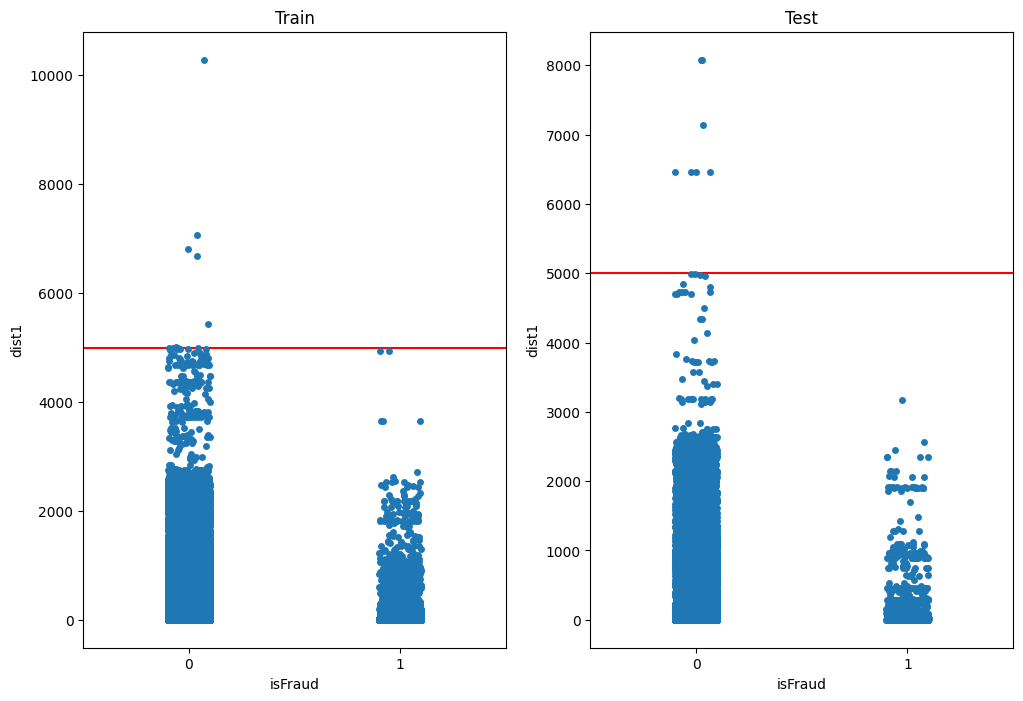

In [524]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='dist1', x='isFraud', data=train)
plt.axhline(5000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='dist1', x='isFraud', data=test)
plt.axhline(5000, color='red')
plt.title('Test')

In [525]:
max_dist1 = train['dist1'][train['dist1'] < 5500].max()
print(f"The maximum dist1 below 5500 is: {max_dist1}")


The maximum dist1 below 5500 is: 5431.0


There are outliers in dist1 with isFraud == 0. These are above 5500. 
I find the maximum amount below 5500 ( 5431 ). I will capped the Train with 5432 below code.

In [526]:
# Identify transactions with isFraud == 0 and dist1 5431
condition = train['dist1'] > 5431

# Cap the dist1 at 5432 for the identified transactions
train.loc[condition, 'dist1'] = 5431

In [527]:
train['dist1'].max()

5431.0

In [528]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_5.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_5.pkl')


In [529]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_5.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_5.pkl')

In [530]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

#### P_emaildomain&R_emaildomain

P_emaildomain : categoric, 56 uniques
It's possible to make subgroup feature from it or general group


R_emaildomain : categoric, 59 uniques
It's possible to make subgroup feature from it or general group

In [531]:
# R_emaildomain
column_details(regex='R_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 60, %75.56
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com'
 nan]



In [532]:
# P_emaildomain
column_details(regex='P_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 59, %15.55
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]



Mapping Emails

In [533]:
#I produced 2 new columns with mail server and domain for 
# The emails dictionary maps email domain suffixes to their corresponding email providers (e.g., 'gmail.com' to 'google', 'att.net' to 'att', etc.).
emails = {'gmail': 'google', 'att.net': 'other', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'other',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'earthlink', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'protonmail', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'other', 
          'prodigy.net.mx': 'other', 'frontier.com': 'yahoo', 'anonymous.com': 'anonymous', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'other', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'mail', 
          'bellsouth.net': 'other', 'embarqmail.com': 'other', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

# The us_emails list contains a few strings representing common email domain suffixes associated with the United States ('gmail', 'net', 'edu').
us_emails = ['gmail', 'net', 'edu']

# Iterating over two columns, 'P_emaildomain' and 'R_emaildomain', in two DataFrames, train and test.
for c in ['P_emaildomain', 'R_emaildomain']:
    # Mapping email domains to their corresponding providers and creating new columns with the suffix '_bin' appended.
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    # Creating new columns with the suffix '_suffix' appended, containing the last part of the email domain after the last period.
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    # Mapping these suffixes to 'us' if they are in the us_emails list, indicating that the email is associated with the United States.
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [534]:
# Convert 'nan' strings to actual np.nan values in the specified suffix columns for both train and test DataFrames
suffix_columns = ['P_emaildomain_bin', 'R_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_suffix']

for column in suffix_columns:
    train[column].replace('nan', np.nan, inplace=True)
    test[column].replace('nan', np.nan, inplace=True)

R_emaildomain_bin train-test sync

In [535]:
# Check the frequencies
value_counts = train['R_emaildomain_bin'].value_counts()

# Identify categories with less than 1000 occurrences
threshold = 1000
rare_categories = value_counts[value_counts < threshold].index

# Assign 'other' category to rows with rare categories
train.loc[train['R_emaildomain_bin'].isin(rare_categories), 'R_emaildomain_bin'] = 'other'


In [536]:
# Assign 'other' category to rows with rare categories in the test data frame
test.loc[test['R_emaildomain_bin'].isin(rare_categories), 'R_emaildomain_bin'] = 'other'

P_emaildomain_bin train-test sync

In [537]:
# Check the frequencies
value_counts = train['P_emaildomain_bin'].value_counts()

# Identify categories with less than 5000 occurrences
threshold = 5000
rare_categories = value_counts[value_counts < threshold].index

# Assign 'other' category to rows with rare categories
train.loc[train['P_emaildomain_bin'].isin(rare_categories), 'P_emaildomain_bin'] = 'other'

In [538]:
# Assign 'other' category to rows with rare categories in the test data frame
test.loc[test['P_emaildomain_bin'].isin(rare_categories), 'P_emaildomain_bin'] = 'other'

R_emaildomain_suffix train-test sync

In [539]:
# Check the frequencies
value_counts = train['R_emaildomain_suffix'].value_counts()

# Identify categories with less than 500 occurrences
threshold = 500
rare_categories = value_counts[value_counts < threshold].index

# Assign 'other' category to rows with rare categories
train.loc[train['R_emaildomain_suffix'].isin(rare_categories), 'R_emaildomain_suffix'] = 'other'

In [540]:
# Assign 'other' category to rows with rare categories in the test data frame
test.loc[test['R_emaildomain_suffix'].isin(rare_categories), 'R_emaildomain_suffix'] = 'other'

P_emaildomain_suffix train-test sync

In [541]:
# Check the frequencies
value_counts = train['P_emaildomain_suffix'].value_counts()

# Identify categories with less than 500 occurrences
threshold = 500
rare_categories = value_counts[value_counts < threshold].index

# Assign 'other' category to rows with rare categories
train.loc[train['P_emaildomain_suffix'].isin(rare_categories), 'P_emaildomain_suffix'] = 'other'

In [542]:
# Assign 'other' category to rows with rare categories in the test data frame
test.loc[test['P_emaildomain_suffix'].isin(rare_categories), 'P_emaildomain_suffix'] = 'other'

Control of cats between train and test

In [543]:
# Control of whether any incompatible categories between train and test
# Columns to be examined
columns_to_check = ['P_emaildomain_bin', 'R_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_suffix']

# Create a dictionary to store columns with different categories
different_categories = {}

# Check each column
for column in columns_to_check:
    train_categories = set(train[column].unique())
    test_categories = set(test[column].unique())
    
    # If they have different categories, add to the dictionary
    if train_categories != test_categories:
        different_categories[column] = {
            'train': train_categories,
            'test': test_categories
        }

# Print columns with different categories
if different_categories:
    print("Columns with different categories:")
    for column, categories in different_categories.items():
        print(f"{column}:")
        print(f"  Train Categories: {categories['train']}")
        print(f"  Test Categories:  {categories['test']}\n")
else:
    print("There are no columns with different categories between the train and test datasets.")


There are no columns with different categories between the train and test datasets.


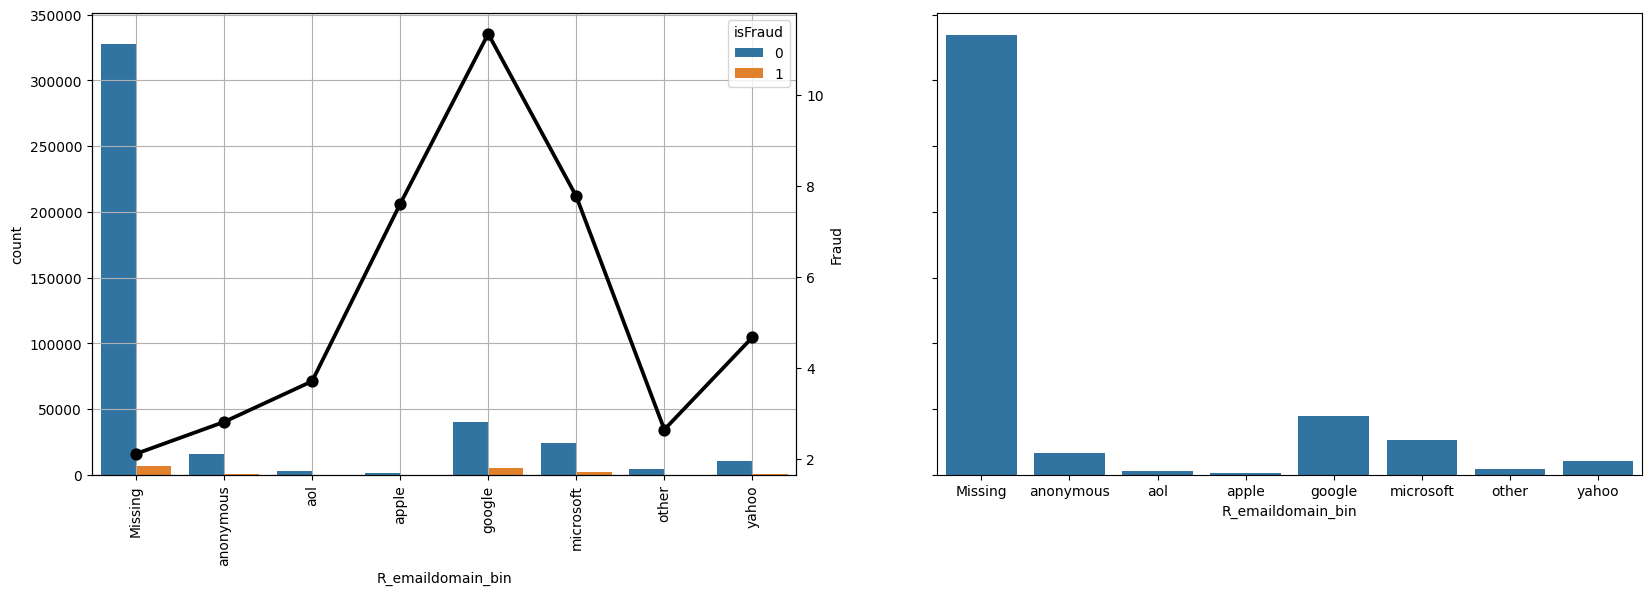

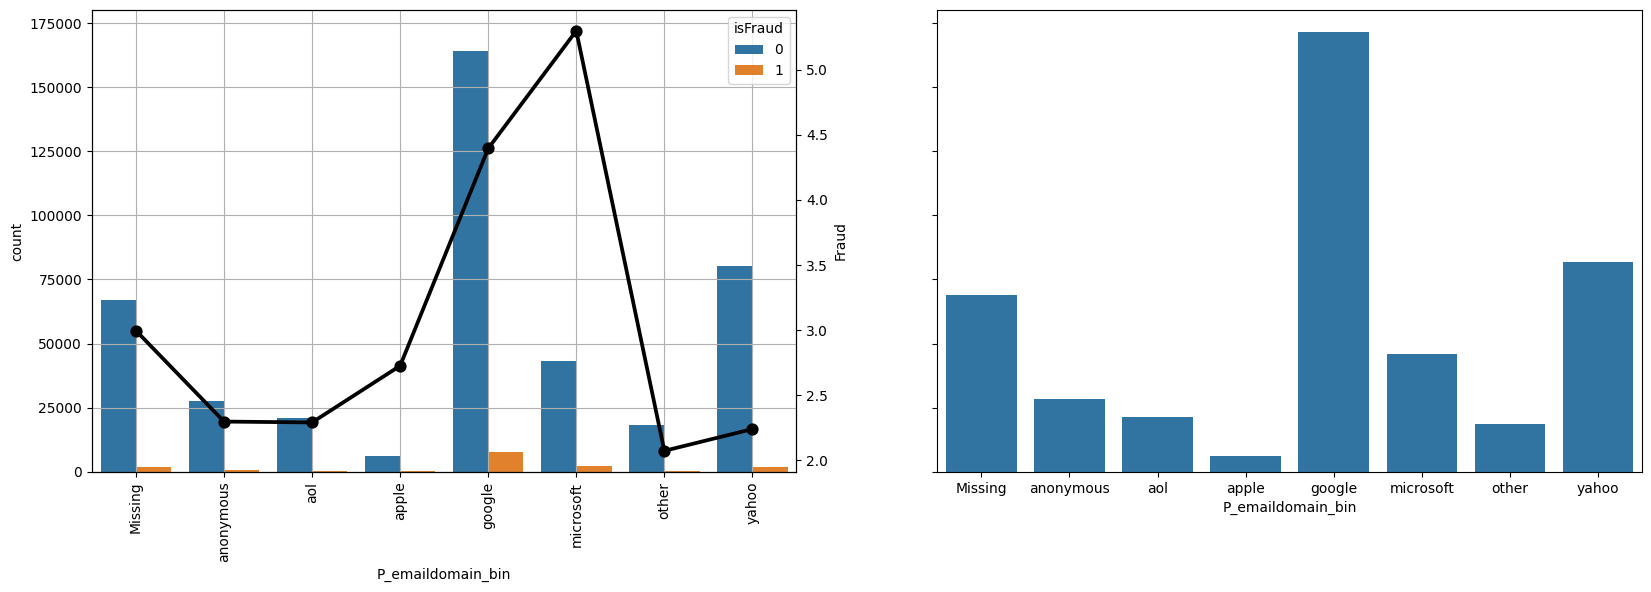

In [544]:
for col in ['R_emaildomain_bin', 'P_emaildomain_bin']:
  plot_col(col, df=train)

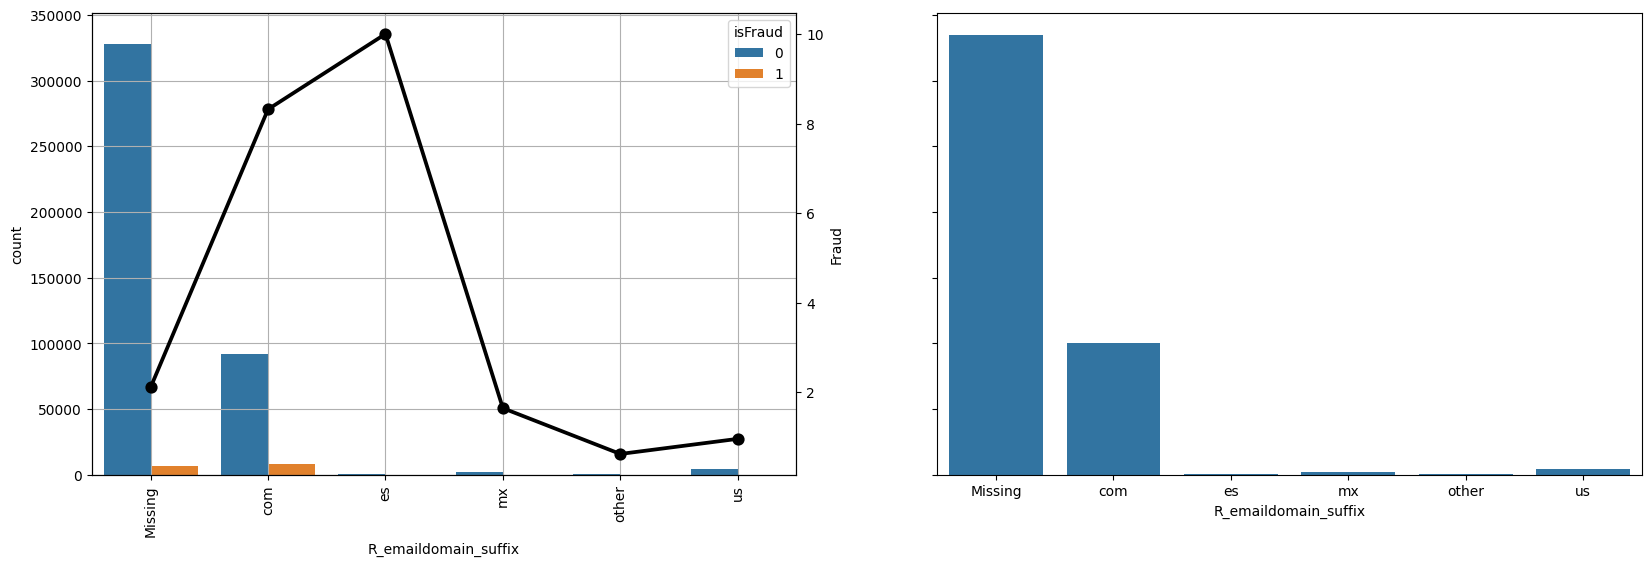

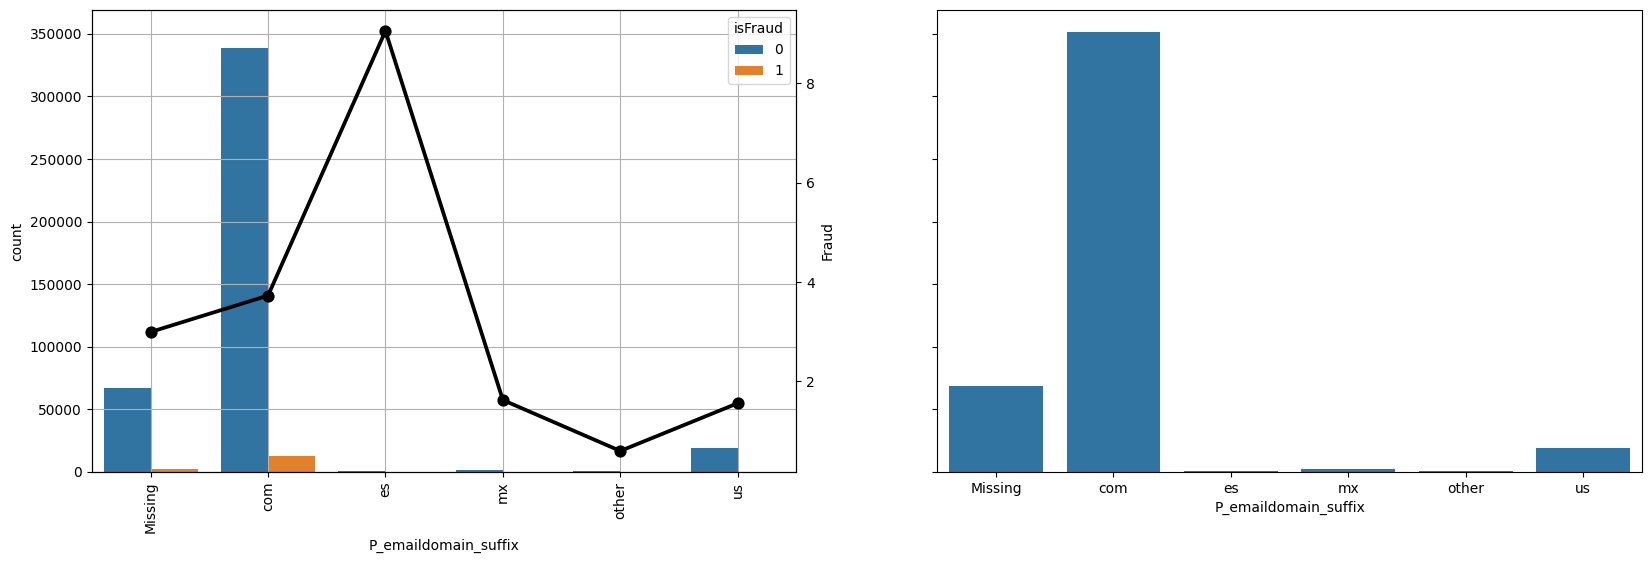

In [545]:
for col in ['R_emaildomain_suffix', 'P_emaildomain_suffix']:
  plot_col(col, df=train)

In [546]:
# es has 10% fraud rate
fraud_rates = train.groupby('R_emaildomain_suffix')['isFraud'].mean().reset_index()
fraud_rates.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates.sort_values(by='FraudRate', ascending=False).head()

R_emaildomain_suffix  FraudRate
1                   es   0.100000
0                  com   0.083169
2                   mx   0.016436
4                   us   0.009584
3                other   0.006211

Two highest fraud activity domains:
* es (Spain) Category: The category associated with Spain (es) has a higher fraud rate compared to other categories (%10). This suggests that transactions originating from Spain may require closer scrutiny in terms of fraud detection.

* com (United States) Category: The category associated with the United States (com) has a significantly higher fraud rate compared to other categories (%8.32). This may imply the need for careful examination of transactions coming from this geographical region.

In [547]:
# Protonmail has 95% fraud rate
fraud_rates = train.groupby('R_emaildomain_bin')['isFraud'].mean().reset_index()
fraud_rates.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates.sort_values(by='FraudRate', ascending=False).head()

R_emaildomain_bin  FraudRate
3            google   0.113450
4         microsoft   0.077715
2             apple   0.076030
6             yahoo   0.046718
1               aol   0.037049

In [548]:
# Protonmail has 46% fraud rate
fraud_rates = train.groupby('P_emaildomain_bin')['isFraud'].mean().reset_index()
fraud_rates.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates.sort_values(by='FraudRate', ascending=False).head()

P_emaildomain_bin  FraudRate
4         microsoft   0.052976
3            google   0.043943
2             apple   0.027257
0         anonymous   0.022974
1               aol   0.022907

Two highest fraud activity domains:

* ProtonMail Category: The ProtonMail category has a significantly higher fraud rate compared to other categories (%95). This indicates that transactions originating from ProtonMail may pose a higher risk of fraud. Careful scrutiny of transactions associated with such accounts could be crucial.

* Mail Category: This general 'mail' category exhibits a higher fraud rate compared to other categories (%36). This suggests that transactions from general email providers should be examined with caution.

In [549]:
# Because protonmail has the highest fraud rate I will create a boolen column for it
#train['P_isproton']=(train['P_emaildomain']=='protonmail.com')
#train['R_isproton']=(train['R_emaildomain']=='protonmail.com')
#test['P_isproton']=(test['P_emaildomain']=='protonmail.com')
#test['R_isproton']=(test['R_emaildomain']=='protonmail.com')

one-hot encoding for R_emaildomain_bin

In [550]:
# Perform one-hot encoding for R_emaildomain_bin column on train
R_emaildomain_bin_OHE = pd.get_dummies(train['R_emaildomain_bin'], prefix='R_emaildomain_bin', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, R_emaildomain_bin_OHE], axis=1)


In [551]:
# Perform one-hot encoding for R_emaildomain_bin column on test
R_emaildomain_bin_OHE = pd.get_dummies(test['R_emaildomain_bin'], prefix='R_emaildomain_bin', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, R_emaildomain_bin_OHE], axis=1)

In [552]:
# original 'R_emaildomain_bin' column dropped
train.drop('R_emaildomain_bin', axis=1, inplace=True)
test.drop('R_emaildomain_bin', axis=1, inplace=True)

In [553]:
# I dont want to use other category because it is not homogenous in terms of fraud_rate
train.drop('R_emaildomain_bin_other', axis=1, inplace=True)
test.drop('R_emaildomain_bin_other', axis=1, inplace=True)

one-hot encoding for R_emaildomain_suffix

In [554]:
# Perform one-hot encoding for R_emaildomain_suffix column on train
R_emaildomain_suffix_OHE = pd.get_dummies(train['R_emaildomain_suffix'], prefix='R_emaildomain_suffix', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, R_emaildomain_suffix_OHE], axis=1)


In [555]:
# Perform one-hot encoding for R_emaildomain_suffix column on test
R_emaildomain_suffix_OHE = pd.get_dummies(test['R_emaildomain_suffix'], prefix='R_emaildomain_suffix', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, R_emaildomain_suffix_OHE], axis=1)

In [556]:
# original 'R_emaildomain_suffix' column dropped
train.drop('R_emaildomain_suffix', axis=1, inplace=True)
test.drop('R_emaildomain_suffix', axis=1, inplace=True)

In [557]:
# I dont want to use other category because it is not homogenous in terms of fraud_rate
train.drop('R_emaildomain_suffix_other', axis=1, inplace=True)
test.drop('R_emaildomain_suffix_other', axis=1, inplace=True)

one-hot encoding for P_emaildomain_bin

In [558]:
# Perform one-hot encoding for P_emaildomain_bin column on train
P_emaildomain_bin_OHE = pd.get_dummies(train['P_emaildomain_bin'], prefix='P_emaildomain_bin', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, P_emaildomain_bin_OHE], axis=1)


In [559]:
# Perform one-hot encoding for P_emaildomain_bin column on test
P_emaildomain_bin_OHE = pd.get_dummies(test['P_emaildomain_bin'], prefix='P_emaildomain_bin', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, P_emaildomain_bin_OHE], axis=1)

In [560]:
# original 'R_emaildomain_bin' column dropped
train.drop('P_emaildomain_bin', axis=1, inplace=True)
test.drop('P_emaildomain_bin', axis=1, inplace=True)

In [561]:
# I dont want to use other category because it is not homogenous in terms of fraud_rate
train.drop('P_emaildomain_bin_other', axis=1, inplace=True)
test.drop('P_emaildomain_bin_other', axis=1, inplace=True)

one-hot encoding for P_emaildomain_suffix

In [562]:
# Perform one-hot encoding for P_emaildomain_suffix column on train
P_emaildomain_suffix_OHE = pd.get_dummies(train['P_emaildomain_suffix'], prefix='P_emaildomain_suffix', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, P_emaildomain_suffix_OHE], axis=1)

In [563]:
# Perform one-hot encoding for P_emaildomain_suffix column on test
P_emaildomain_suffix_OHE = pd.get_dummies(test['P_emaildomain_suffix'], prefix='P_emaildomain_suffix', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, P_emaildomain_suffix_OHE], axis=1)

In [564]:
# original 'P_emaildomain_suffix' column dropped
train.drop('P_emaildomain_suffix', axis=1, inplace=True)
test.drop('P_emaildomain_suffix', axis=1, inplace=True)

In [565]:
# I dont want to use other category because it is not homogenous in terms of fraud_rate
train.drop('P_emaildomain_suffix_other', axis=1, inplace=True)
test.drop('P_emaildomain_suffix_other', axis=1, inplace=True)

In [566]:
# dropping original columns
train = train.drop('P_emaildomain', axis=1)
test = test.drop('P_emaildomain', axis=1)

In [567]:
# dropping original columns
train = train.drop('R_emaildomain', axis=1)
test = test.drop('R_emaildomain', axis=1)

In [568]:
train

isFraud  TransactionDT  TransactionAmt  card1  dist1    C1  \
TransactionID                                                               
2987000              0          86400          68.500  13926   19.0   1.0   
2987001              0          86401          29.000   2755    NaN   1.0   
2987002              0          86469          59.000   4663  287.0   1.0   
2987003              0          86499          50.000  18132    NaN   2.0   
2987004              0          86506          50.000   4497    NaN   1.0   
...                ...            ...             ...    ...    ...   ...   
3429900              0       11246397         107.950   7508   10.0   3.0   
3429901              0       11246476          35.658  15885    NaN   1.0   
3429902              0       11246502          30.950   9992    4.0  83.0   
3429903              0       11246585          57.950   9485    6.0   2.0   
3429904              0       11246605          57.950   1919    5.0   2.0   

                 C2   C4     C5    C6   C7   C8    C9  C10   C11  C12    C13  \
TransactionID                                                                  
2987000         1.0  0.0    0.0   1.0  0.0  0.0   1.0  0.0   2.0  0.0    1.0   
2987001         1.0  0.0    0.0   1.0  0.0  0.0   0.0  0.0   1.0  0.0    1.0   
2987002         1.0  0.0    0.0   1.0  0.0  0.0   1.0  0.0   1.0  0.0    1.0   
2987003         5.0  0.0    0.0   4.0  0.0  0.0   1.0  0.0   1.0  0.0   25.0   
2987004         1.0  0.0    0.0   1.0  0.0  1.0   0.0  1.0   1.0  0.0    1.0   
...             ...  ...    ...   ...  ...  ...   ...  ...   ...  ...    ...   
3429900         3.0  0.0    1.0   2.0  0.0  0.0   2.0  0.0   2.0  0.0    5.0   
3429901         1.0  1.0    0.0   1.0  1.0  1.0   0.0  1.0   1.0  1.0    1.0   
3429902        68.0  0.0  126.0  61.0  0.0  0.0  64.0  0.0  61.0  0.0  443.0   
3429903         3.0  0.0    1.0   1.0  0.0  0.0   1.0  0.0   1.0  0.0    5.0   
3429904         1.0  0.0    1.0   1.0  0.0  0.0   2.0  0.0   2.0  0.0    7.0   

                C14     D1     D2    D3     D4    D5  D6        D8        D9  \
TransactionID                                                                  
2987000         1.0   14.0    NaN  13.0    NaN   NaN NaN       NaN       NaN   
2987001         1.0    0.0    NaN   NaN    0.0   NaN NaN       NaN       NaN   
2987002         1.0    0.0    NaN   NaN    0.0   NaN NaN       NaN       NaN   
2987003         1.0  112.0  112.0   0.0   94.0   0.0 NaN       NaN       NaN   
2987004         1.0    0.0    NaN   NaN    NaN   NaN NaN       NaN       NaN   
...             ...    ...    ...   ...    ...   ...  ..       ...       ...   
3429900         3.0  180.0  180.0  96.0  348.0  96.0 NaN       NaN       NaN   
3429901         1.0    0.0    NaN   NaN    NaN   NaN NaN  0.166666  0.166666   
3429902        76.0  139.0  139.0   4.0    NaN   NaN NaN       NaN       NaN   
3429903         2.0    4.0    4.0   3.0  176.0   3.0 NaN       NaN       NaN   
3429904         2.0  112.0  112.0  35.0    NaN   NaN NaN       NaN       NaN   

                 D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5  \
TransactionID                                                                
2987000         13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F   
2987001          0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T   
2987002          0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F   
2987003         84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T   
2987004          NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN   
...              ...    ...  ...  ...  ...    ...  ...  ...  ...  ...  ...   
3429900        348.0  348.0  NaN  NaN  NaN  348.0    T    T    T  NaN  NaN   
3429901          NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN   M0  NaN   
3429902        138.0  138.0  NaN  NaN  NaN  138.0    T    T    T  NaN  NaN   
3429903          0.0  176.0  NaN  NaN  NaN  176.0    T    T    T  NaN  Na

In [569]:
# I want to remove collinear features in 'email' columns with a threshold of 0.75
mail_cols = ['P_emaildomain_suffix', 'R_emaildomain_suffix', 'P_emaildomain_bin', 'R_emaildomain_bin']
filtered_columns = [col for col in train.columns if any(pattern in col for pattern in mail_cols)]
drop_columns = identify_collinear_categorical_features(train, filtered_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)

Columns to drop: ['R_emaildomain_suffix_com', 'R_emaildomain_suffix_nan', 'P_emaildomain_suffix_com', 'P_emaildomain_suffix_mx', 'P_emaildomain_suffix_es', 'P_emaildomain_suffix_nan']


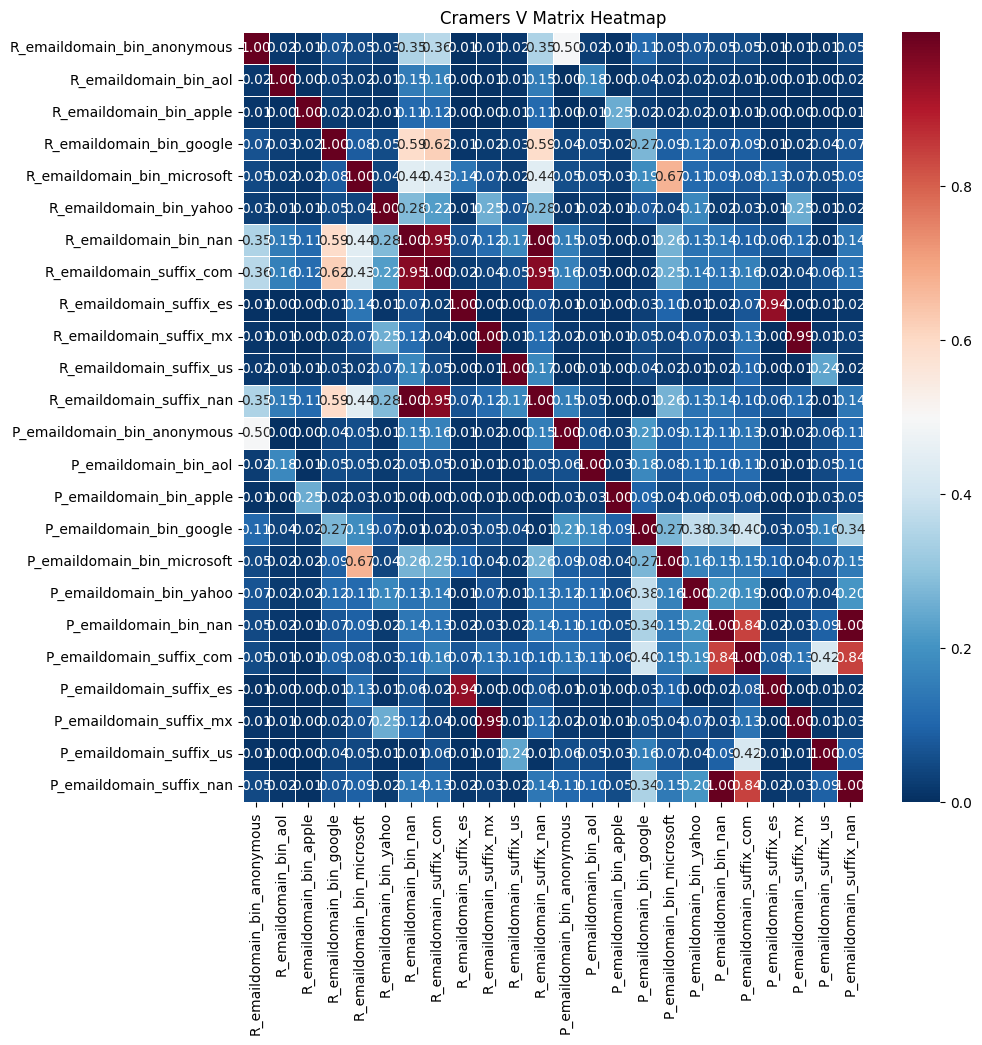

In [570]:
selected_columns = filtered_columns

# Create an empty DataFrame to store the results
cramers_v_matrix = pd.DataFrame(index=selected_columns, columns=selected_columns, dtype=float)

# Fill in the Cramers V values for each pair of columns
for col1 in selected_columns:
    for col2 in selected_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cramers_v_matrix, cmap='RdBu_r', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cramers V Matrix Heatmap')
plt.show()

In [571]:
# dropping highly correlated columns
train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)

In [572]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_6.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_6.pkl')


In [573]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_6.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_6.pkl')

#### C1 .... C14 : Counting variables such as how many addresses are found to be associated with the payment card (numeric)

In [574]:
column_details(regex='^C\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  float64, 1577, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 4.682e+03 4.684e+03 4.685e+03]

C2:  float64, 1078, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 5.625e+03 5.690e+03 5.691e+03]

C4:  float64, 1214, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 2.251e+03 2.252e+03 2.253e+03]

C5:  float64, 309, %0.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.

C7:  float64, 1101, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 2.253e+03 2.254e+03 2.255e+03]

C8:  float64, 1218, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 3.328e+03 3.330e+03 3.331e+03]

C9:  float64, 203, %0.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 

In [575]:
# Finding highly correlated columns to drop
columns=[col for col in train.columns if re.search('^C\d.*', col)]
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'C1', 'C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

In [576]:
# I m removing C13 instead of C1, beucase C13 has many outliers. 
drop_col = {'C13','C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

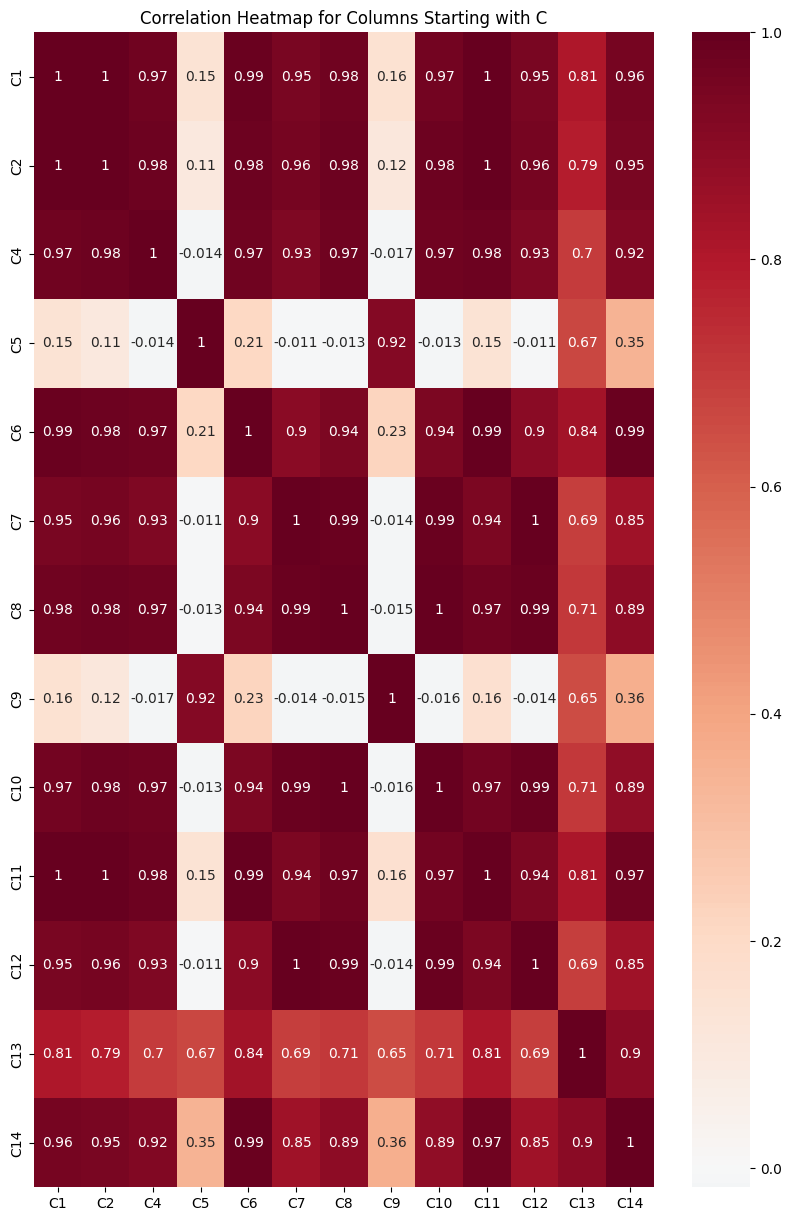

In [577]:
# Select columns starting with 'C'
columns = [col for col in train.columns if re.search('^C\d.*', col)]

# Create a correlation heatmap using the make_corr function
make_corr(columns, train)


In [578]:
# Only C1, C5 remained.
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#### D1...D15 : Timedelta variables, such as days between previous transaction (numeric)

In [579]:
for df in [train, test]:
  column_details(regex='^D\d.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float64, 641, %0.06
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

D4:  float64, 748, %29.41
[-122.  -90.  -83.  -42.  -15.   -6.   -2.   -1.    0.    1.    2.    3.
    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.   15.
   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.   27.
   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.   39.
   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.   51.
   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.   63.
   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.   75.
   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.   87.
   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.   99.
  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.
  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.
  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.  135.
  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151. 

In [580]:
columns=[col for col in train.columns if re.search('^D\d.*', col)]

corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'D11', 'D12', 'D2', 'D4'}

In [581]:
[col for col in train.columns if re.search('^D\d.*', col)]

['D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15']

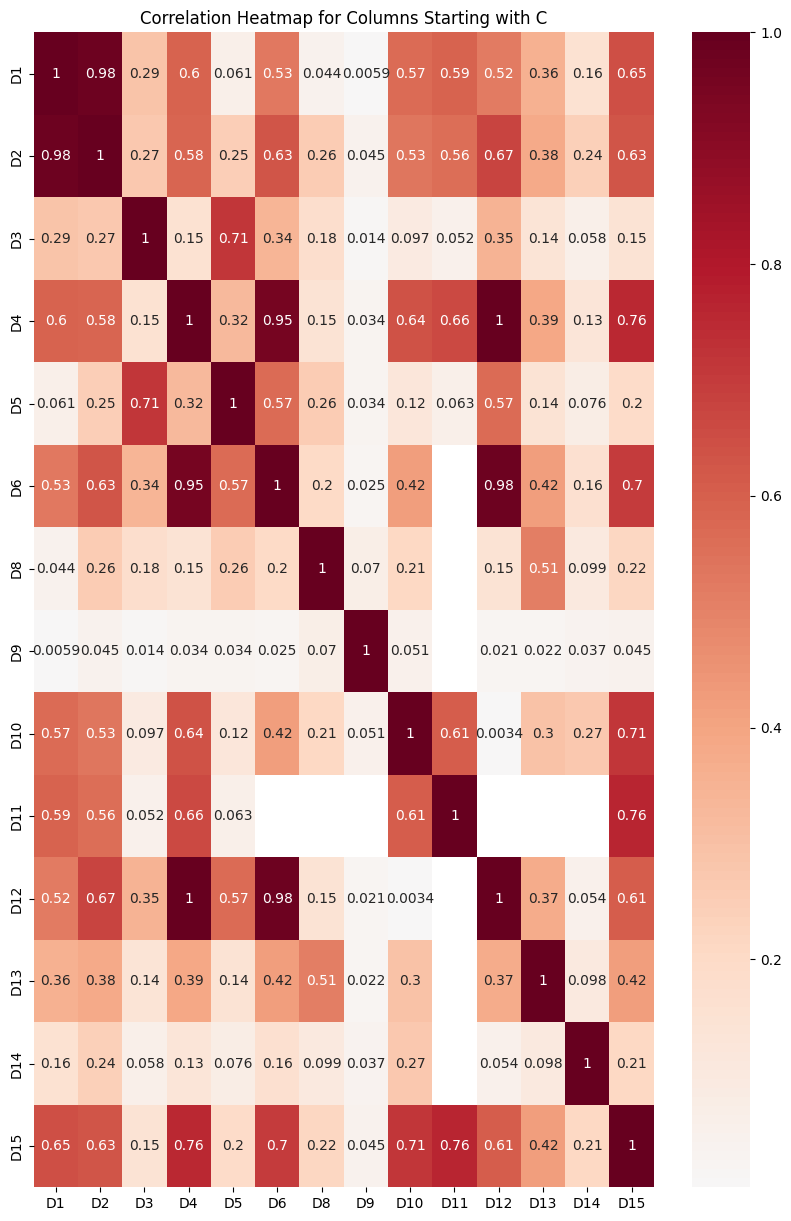

In [582]:
# Create a correlation heatmap using the make_corr function
make_corr(columns, train)

In [583]:
# The correlated columns having the most missing values are dropped. So, I replaced some columns in the dropping column list below.
drop_col={'D11', 'D12', 'D2', 'D4'}
for df in [train, test]:
  df = df.drop(drop_col, axis=1)

#### M1 ... M9 : Match variables, used to verify information such as names on the card and address. (nominal categoric)

In [584]:
column_details(regex='^M\d*', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M1:  object, 2, %51.88
['F' 'T' nan]



M2:  object, 2, %51.88
['F' 'T' nan]

M3:  object, 2, %51.88
['F' 'T' nan]

M4:  object, 3, %48.26
['M0' 'M1' 'M2' nan]

M5:  object, 2, %60.23
['F' 'T' nan]

M6:  object, 2, %30.45
['F' 'T' nan]

M7:  object, 2, %64.81
['F' 'T' nan]

M8:  object, 2, %64.8
['F' 'T' nan]

M9:  object, 2, %64.8
['F' 'T' nan]



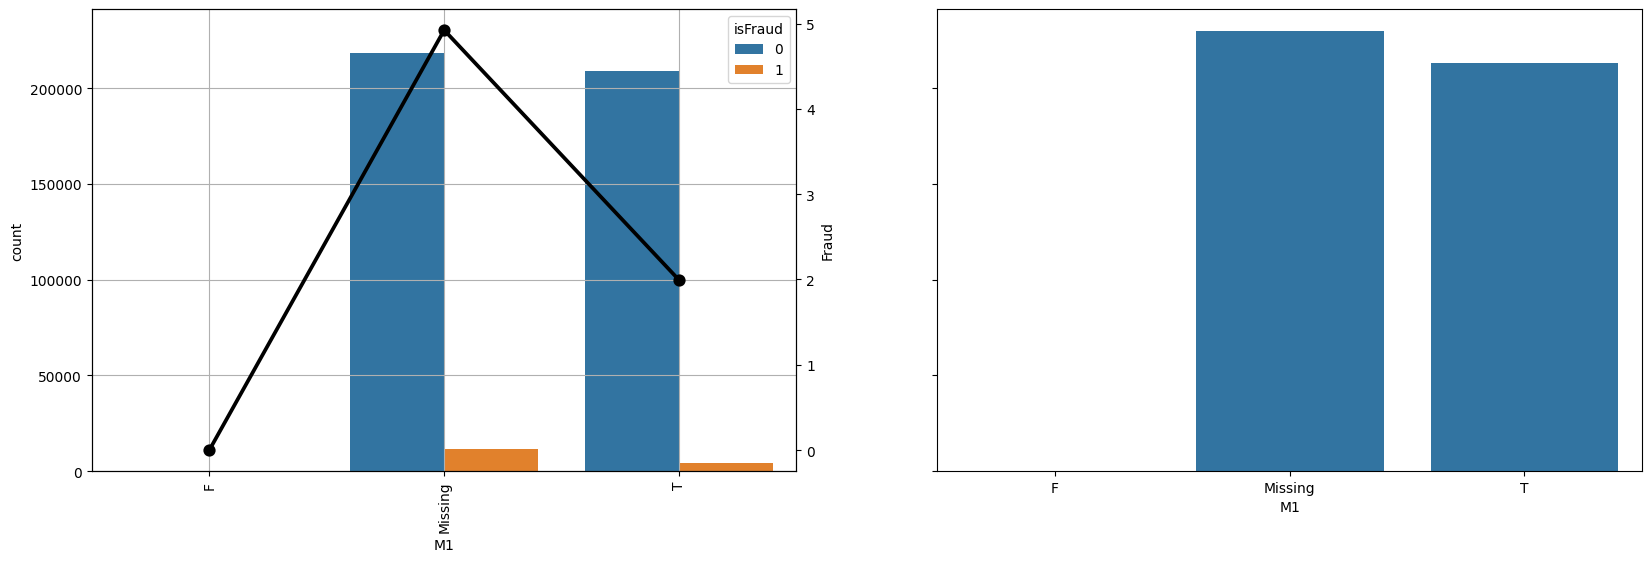

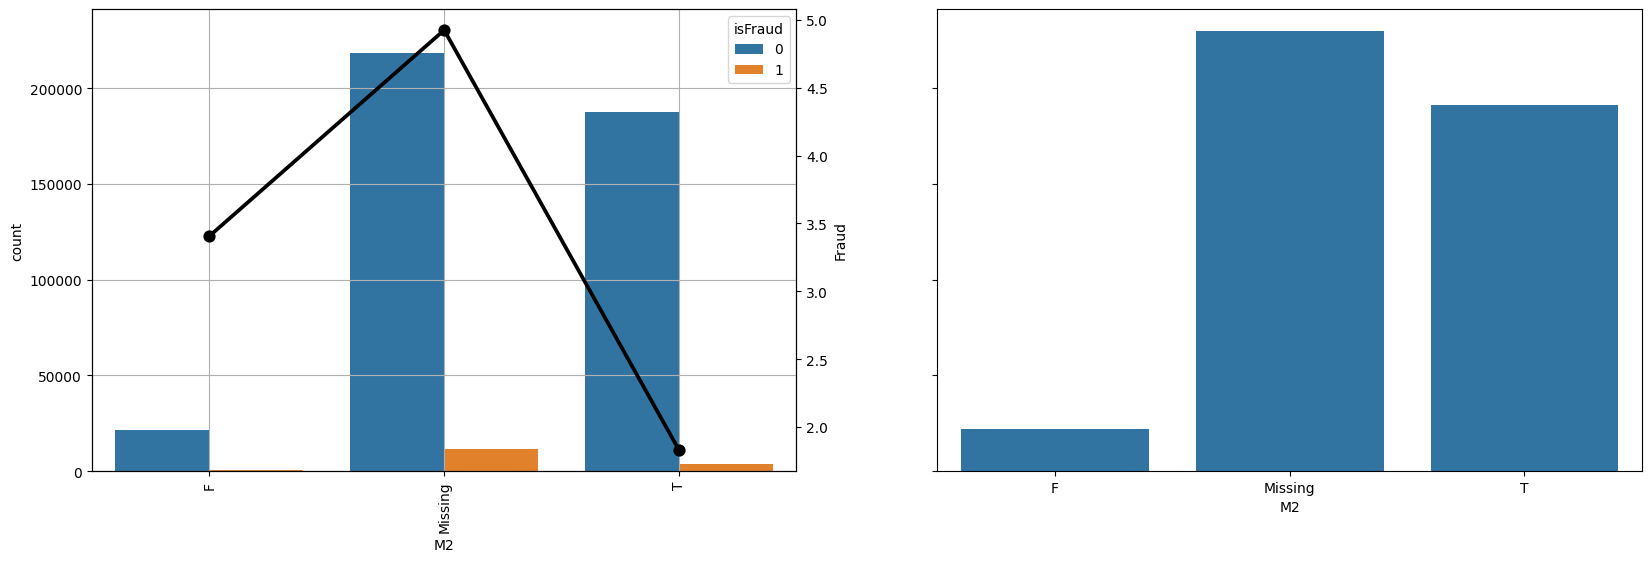

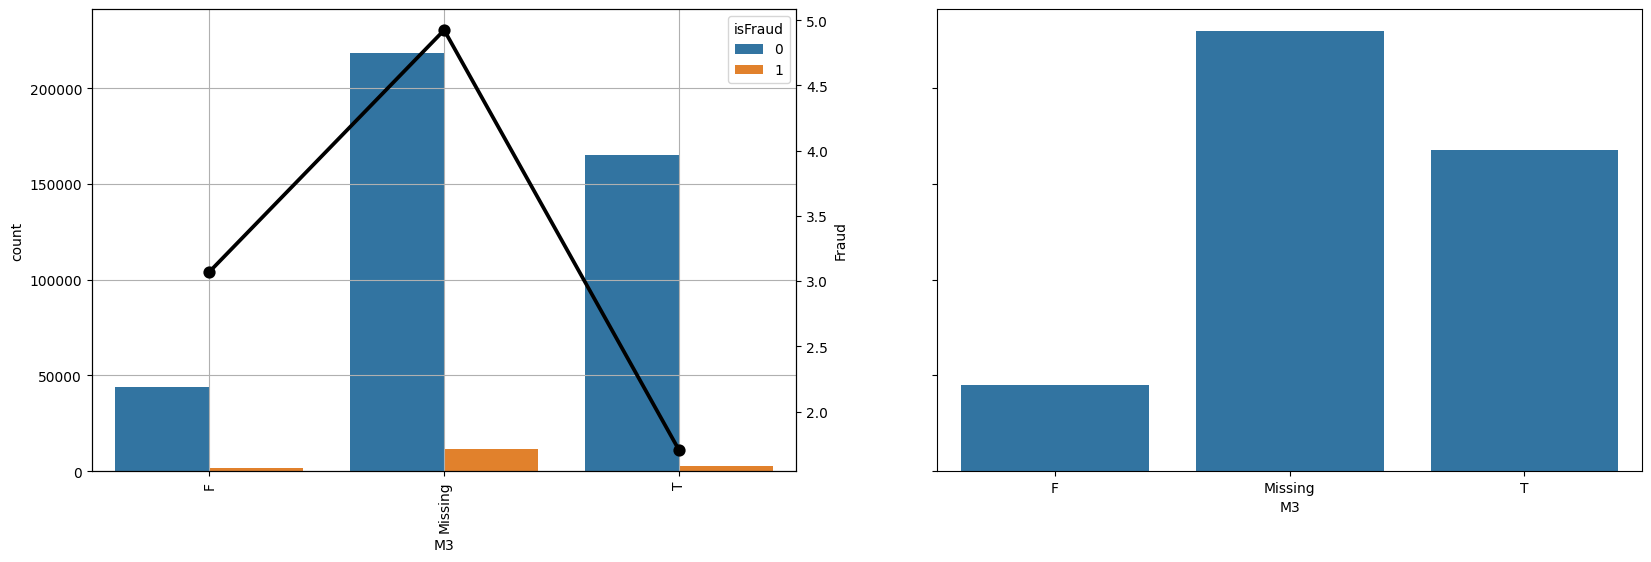

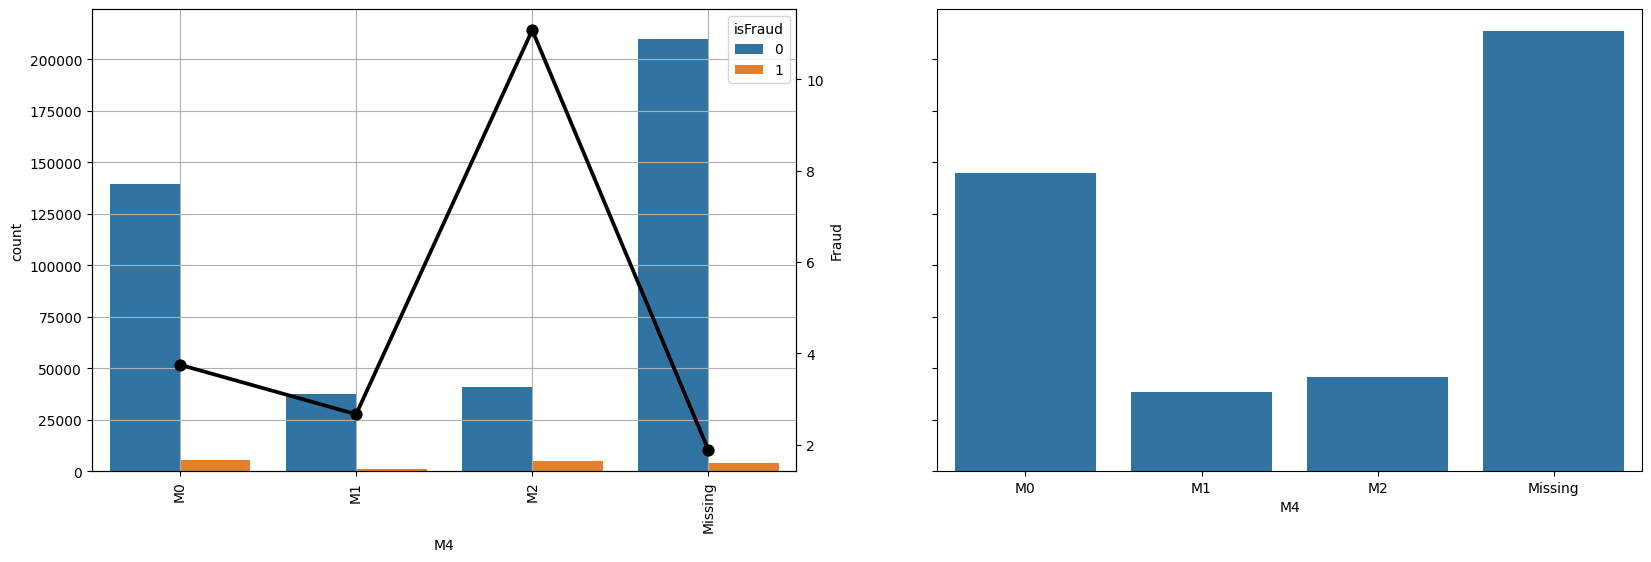

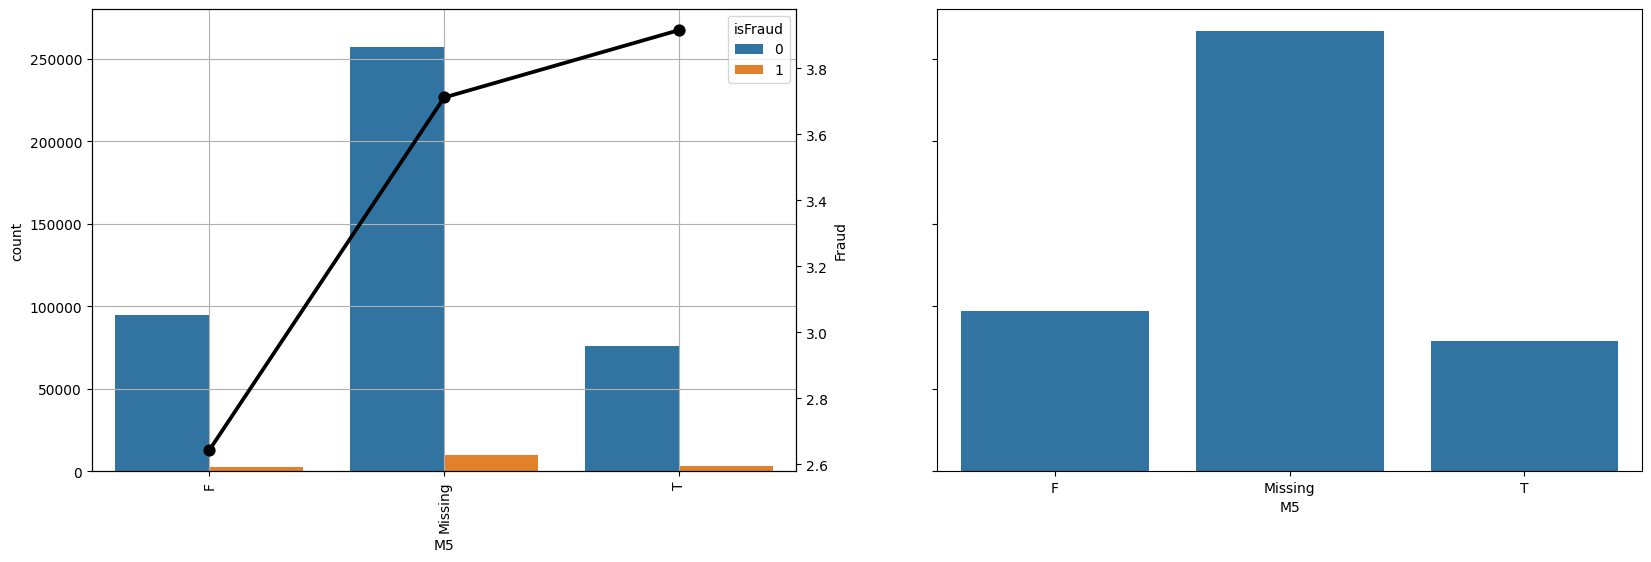

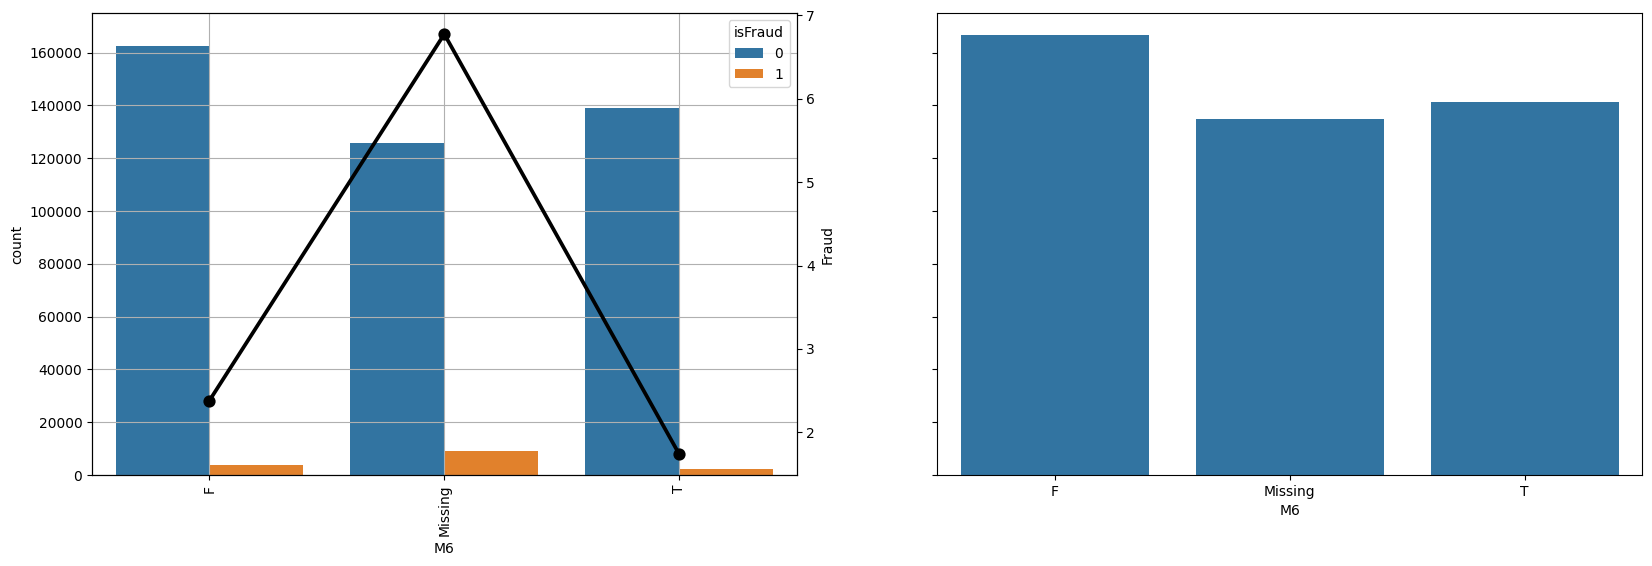

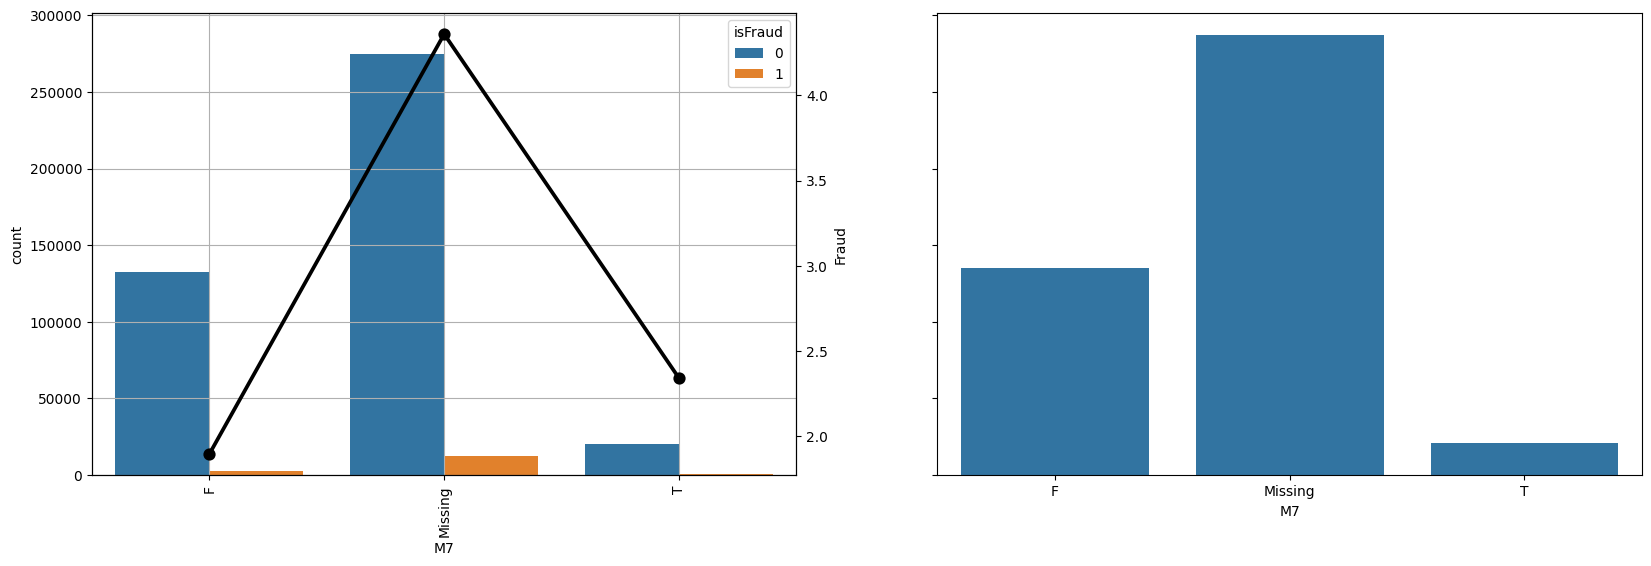

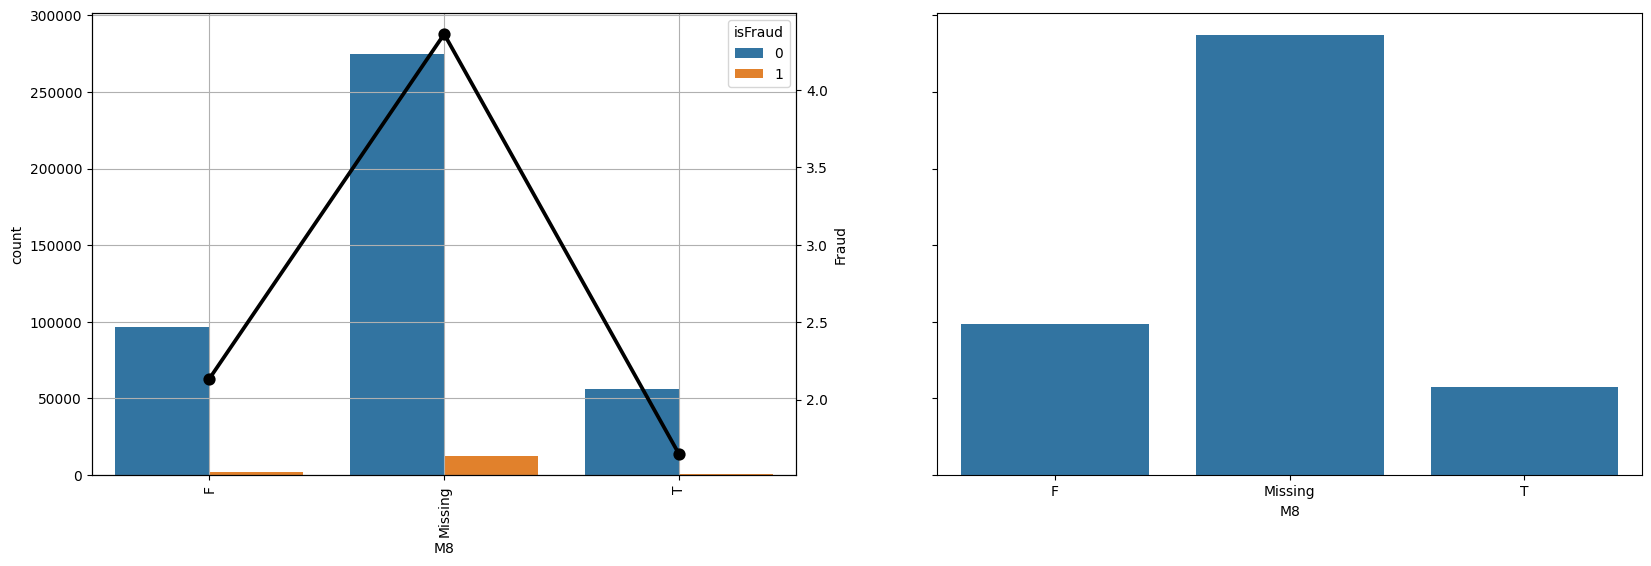

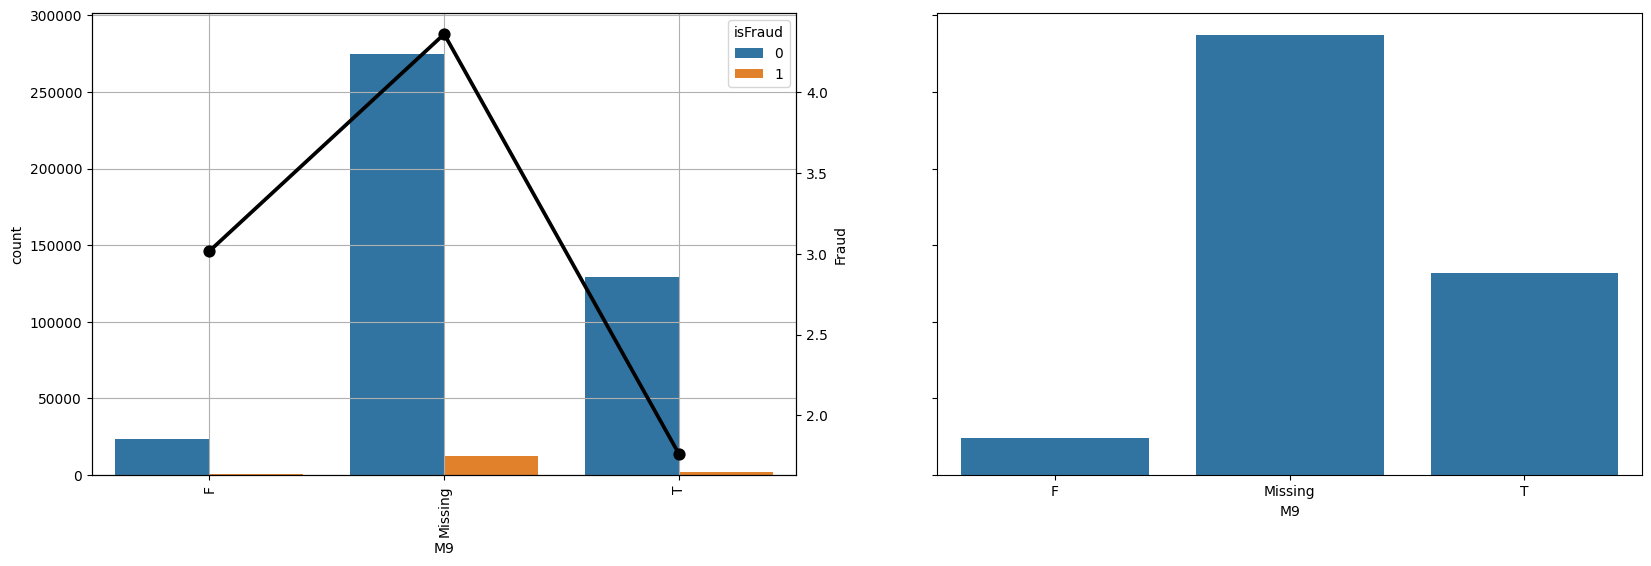

In [585]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
  plot_col(col, df=train)

In the case of the 'M4' and 'M5 columnS, missing values do not have the highest percentage of fraud.

In [586]:
# converting 'nan' to np.nan
regex_pattern = '^M\d*'
columns_to_replace = [col for col in df.columns if col.startswith(tuple(regex_pattern))]
df[columns_to_replace] = df[columns_to_replace].replace('nan', np.nan)

In [587]:
# Replace 'F' values with NaN in the 'M1' column (because in train there is only 20 F rows, in test only 5 rows)
train['M1'].replace('F', np.nan, inplace=True)
test['M1'].replace('F', np.nan, inplace=True)

In [588]:
# One Hot Encoding for M columns-train
# Select the column names
columns_to_encode = train.columns[train.columns.str.match(r'^M[1-9]$')]

# Perform one-hot encoding for each column
for column in columns_to_encode:
    one_hot_encoded = pd.get_dummies(train[column], prefix=column, drop_first=False, dtype=int, dummy_na=True)
    train = pd.concat([train, one_hot_encoded], axis=1)

In [589]:
# One Hot Encoding for M columns-test
# Select the column names
columns_to_encode = test.columns[test.columns.str.match(r'^M[1-9]$')]

# Perform one-hot encoding for each column
for column in columns_to_encode:
    one_hot_encoded = pd.get_dummies(test[column], prefix=column, drop_first=False, dtype=int, dummy_na=True)
    test = pd.concat([test, one_hot_encoded], axis=1)

In [590]:
# Drop the original columns that were one-hot encoded
train.drop(columns=columns_to_encode, inplace=True)
test.drop(columns=columns_to_encode, inplace=True)

In [591]:
# I want to remove collinear features in 'M' columns with a threshold of 0.75
m_cols = [f'M{i}' for i in range(1, 10)]
filtered_columns = [col for col in train.columns if any(pattern in col for pattern in m_cols)]
drop_columns = identify_collinear_categorical_features(train, filtered_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)

Columns to drop: ['M8_nan', 'M7_nan', 'M9_nan', 'M3_T', 'M2_T', 'M2_nan', 'M9_T', 'M5_nan', 'M8_F', 'M3_nan', 'M1_nan']


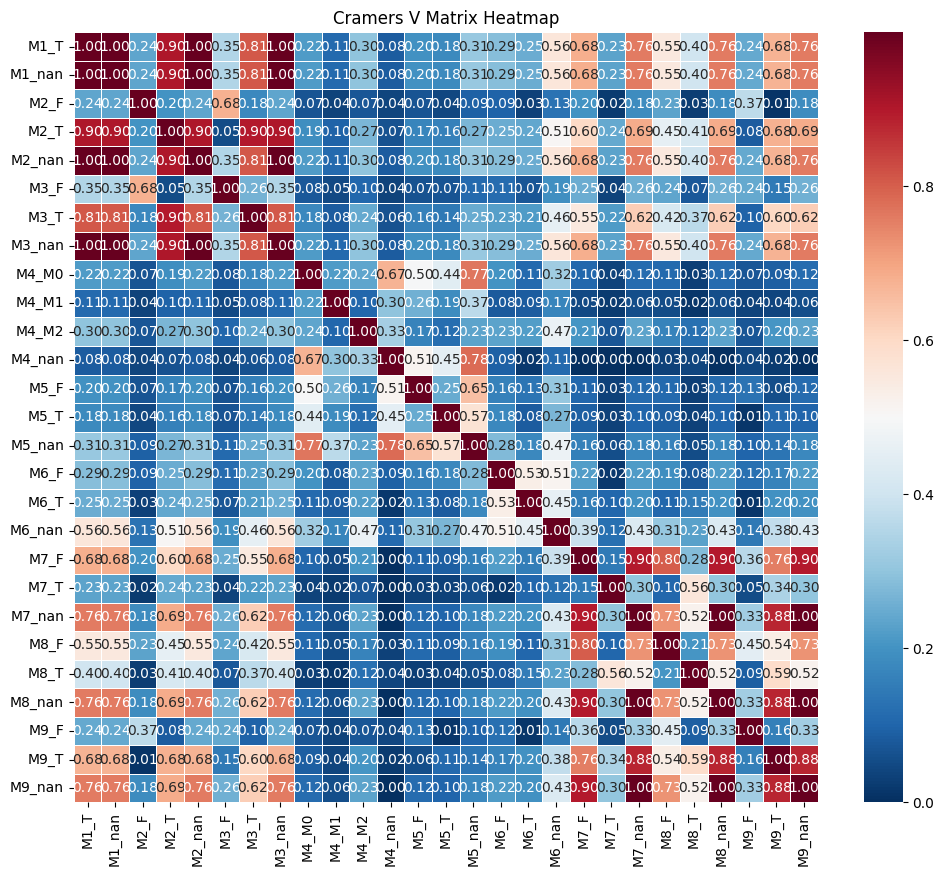

In [592]:
m_columns = train.loc[:, filtered_columns]

# Create an empty DataFrame to store the results
cramers_v_matrix = pd.DataFrame(index=m_columns.columns, columns=m_columns.columns, dtype=float)

# Fill in the Cramers V values for each pair of columns
for col1 in m_columns.columns:
    for col2 in m_columns.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(m_columns[col1], m_columns[col2])

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, cmap='RdBu_r', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cramers V Matrix Heatmap')
plt.show()

In [593]:
#dropping highly correlated features 
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)

In [594]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_7.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_7.pkl')

In [595]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_7.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_7.pkl')

#### V1-V339 : Vesta-engineered features that encompass ranking, counting, and various entity relationships.(numeric)

We identified redundancy and correlation among the 'V' columns, and dropped correlated columns with a correlation coefficient (r) greater than 0.75. This process resulted in retaining only 69 independent 'V' columns.

In [596]:
column_details(regex='V\d*', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE



V1:  float32, 2, %53.02
[ 0.  1. nan]

V2:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V3:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V4:  float32, 6, %53.02
[ 0.  1.  2.  3.  4.  5. nan]

V5:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V6:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V7:  float32, 8, %53.02
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V8:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V9:  float32, 7, %53.02
[ 0.  1.  2.  3.  4.  5.  6. nan]

V10:  float32, 5, %53.02
[ 0.  1.  2.  3.  4. nan]

V11:  float32, 5, %53.02
[ 0.  1.  2.  3.  4. nan]

V12:  float32, 4, %14.36
[ 0.  1.  2.  3. nan]

V13:  float32, 7, %14.36
[ 0.  1.  2.  3.  4.  5.  6. nan]

V14:  float32, 2, %14.36
[ 0.  1. nan]

V15:  float32, 8, %14.36
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V16:  float32, 15, %14.36
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14. 15. nan]

V17:  float32, 16, %14.36
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 1

In [597]:
# removing high correlated variables (222 eliminated)
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

222

In [598]:
# dropping redundant Vs
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

In [599]:
# remaining Variables' length (64 vars)
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

64

<Axes: >

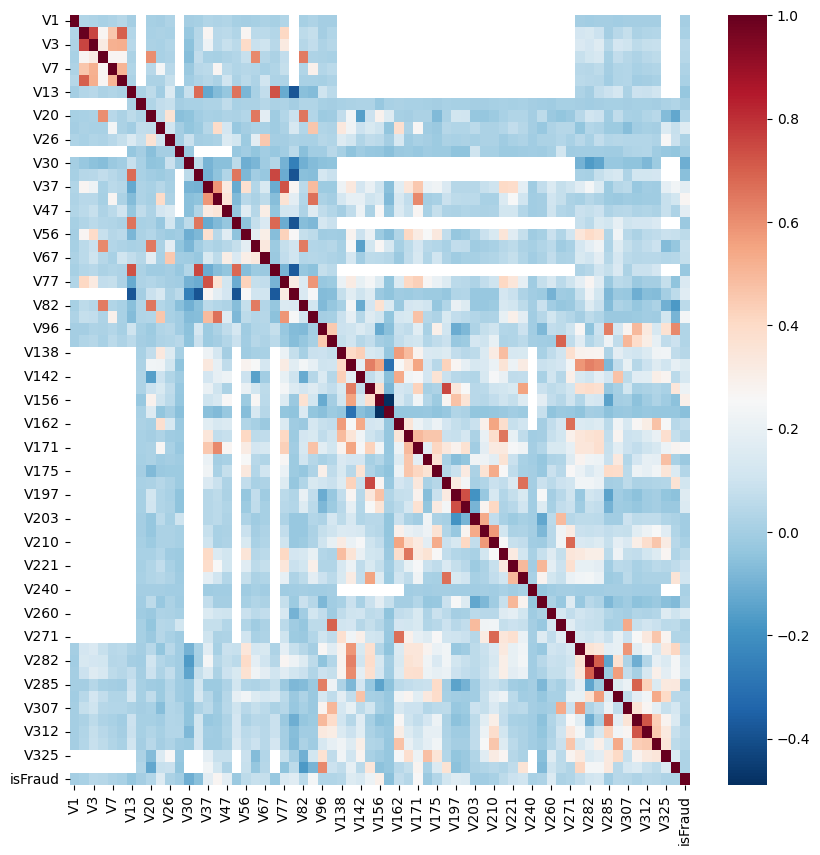

In [600]:
plt.figure(figsize=(10,10))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="RdBu_r")

In [601]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_2.pkl'
train.to_pickle(r'../dataset/train_8.pkl')

#save 'test' data to a pickle file named 'test_2.pkl'
test.to_pickle(r'../dataset/test_8.pkl')


In [602]:
# Read the 'train_2.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_8.pkl')

# Read the 'test_2.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_8.pkl')

In [603]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

#### id_1 ... id_11 (numeric)

In [604]:
column_details(regex='id_(1|2|3|4|5|6|7|8|9|10|11)$', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_10:  float64, 59, %86.74
[-100.  -68.  -64.  -60.  -59.  -58.  -57.  -56.  -55.  -54.  -51.  -50.
  -49.  -47.  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.
  -34.  -33.  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.
  -22.  -21.  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.
  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.   nan]

id_11:  float64, 346, %74.59
[ 90.          90.09999847  90.11000061  90.16000366  90.19999695
  90.20999908  90.23999786  90.26999664  90.27999878  90.29000092
  90.31999969  90.34999847  90.36000061  90.37999725  90.41000366
  90.43000031  90.48000336  90.51999664  90.52999878  90.54000092
  90.55000305  90.56999969  90.58999634  90.62999725  90.65000153
  90.69999695  90.73999786  90.76999664  90.80000305  90.83000183
  90.84999847  90.91000366  91.          91.02999878  91.06999969
  91.08999634  91.11000061  91.13999939  91.150

In [605]:
# removing high correlated variables 
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

0

In [606]:
'''
# dropping redundant Vs
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)
'''

'\n# dropping redundant Vs\ntrain = train.drop(drop_col, axis=1)\ntest = test.drop(drop_col, axis=1)\n'

There is no correlation between these two variables.

#### id_12...id_38 (nominal categoric)

In [607]:
column_details(regex='id_(12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38)', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_12:  object, 2, %74.02
['Found' 'NotFound' nan]

id_13:  object, 52, %77.38
['10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '17.0' '18.0' '19.0' '20.0'
 '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '28.0' '29.0' '30.0' '31.0'
 '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0' '40.0' '41.0'
 '43.0' '44.0' '45.0' '46.0' '47.0' '48.0' '49.0' '50.0' '51.0' '52.0'
 '53.0' '54.0' '55.0' '56.0' '57.0' '58.0' '59.0' '60.0' '61.0' '62.0'
 '63.0' '64.0' nan]

id_14:  object, 25, %85.14
['-120.0' '-180.0' '-210.0' '-240.0' '-300.0' '-360.0' '-420.0' '-480.0'
 '-540.0' '-600.0' '-660.0' '0.0' '120.0' '180.0' '240.0' '270.0' '300.0'
 '330.0' '360.0' '420.0' '480.0' '540.0' '60.0' '600.0' '720.0' nan]

id_15:  object, 3, %74.59
['Found' 'New' 'Unknown' nan]

id_16:  object, 2, %76.65
['Found' 'NotFound' nan]

id_17:  object, 101, %74.83
['100.0' '101.0' '102.0' '105.0' '106.0' '107.0' '110.0' '111.0' '112.0'
 '114.0' '116.0' '117.0'

In [608]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_2.pkl'
train.to_pickle(r'../dataset/train_9.pkl')

#save 'test' data to a pickle file named 'test_2.pkl'
test.to_pickle(r'../dataset/test_9.pkl')


In [609]:
# Read the 'train_2.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_9.pkl')

# Read the 'test_2.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_9.pkl')

In [610]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

id_30

In [611]:
# Some browser codes with '_' others have '.' .  I replace '_' with '.' in the 'id_30' column 
train['id_30'] = train['id_30'].str.replace('_', '.')
test['id_30'] = test['id_30'].str.replace('_', '.')

In [612]:
# creating OS_id_30 column
train['OS_id_30'] = train['id_30'].str.split(' ', expand=True)[0]
test['OS_id_30'] = test['id_30'].str.split(' ', expand=True)[0]

In [613]:
# Replace values in 'OS_id_30' column with np.nan if they are not in the allowed list
allowed_values = ['Windows', 'iOS', 'Mac', 'Android', 'Linux']
train['OS_id_30'] = np.where(train['OS_id_30'].isin(allowed_values), train['OS_id_30'], np.nan)
test['OS_id_30'] = np.where(test['OS_id_30'].isin(allowed_values), test['OS_id_30'], np.nan)

In [614]:
test['OS_id_30'].value_counts(dropna=False)

OS_id_30
NaN        133838
Windows      6969
iOS          3210
Mac          2221
Android      1132
Linux         265
Name: count, dtype: int64

In [615]:
# Perform one-hot encoding for OS_id_30 column on train
OS_id_30_OHE = pd.get_dummies(train['OS_id_30'], prefix='OS_id_30', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, OS_id_30_OHE], axis=1)

In [616]:
# Perform one-hot encoding for OS_id_30 column on test
OS_id_30_OHE = pd.get_dummies(test['OS_id_30'], prefix='OS_id_30', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, OS_id_30_OHE], axis=1)

In [617]:
# original 'OS_id_30' column dropped
train.drop('OS_id_30', axis=1, inplace=True)
test.drop('OS_id_30', axis=1, inplace=True)

Some of the browsers dont have the version. I will assign these to the browsers' common version ( mode )

In [618]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_2.pkl'
train.to_pickle(r'../dataset/train_10.pkl')

#save 'test' data to a pickle file named 'test_2.pkl'
test.to_pickle(r'../dataset/test_10.pkl')


In [619]:
# Read the 'train_2.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_10.pkl')

# Read the 'test_2.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_10.pkl')

In [620]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

id_31

In [621]:
# create a new column that represents lastest browser
a = np.zeros(train.shape[0])
train["lastest_browser"] = a
a = np.zeros(test.shape[0])
test["lastest_browser"] = a
def setbrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df
train=setbrowser(train)
test=setbrowser(test)

In [622]:
# Capitalize the first letter of categories in the id_31 column
train['id_31'] = train['id_31'].str.capitalize()
test['id_31'] = test['id_31'].str.capitalize()

In [623]:
# Creating Browser_id_31 column by mapping id_31 - train

# Create a boolean array for missing values
train['id_31'].fillna('', inplace=True)
missing_values = train['id_31'].isnull()

# Update the 'Browser_id_31' column based on conditions
train.loc[missing_values, 'Browser_id_31'] = np.nan
train.loc[train['id_31'].str.contains('Chrome', case=False) & ~train['id_31'].str.contains('Android|iOS', case=False), 'Browser_id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('Chrome', case=False) & train['id_31'].str.contains('Android', case=False), 'Browser_id_31'] = 'Chrome Android'
train.loc[train['id_31'].str.contains('Chrome', case=False) & train['id_31'].str.contains('iOS', case=False), 'Browser_id_31'] = 'Chrome iOS'
train.loc[train['id_31'].str.contains('Safari', case=False) & ~train['id_31'].str.contains('Mobile', case=False), 'Browser_id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('Safari', case=False) & train['id_31'].str.contains('Mobile', case=False), 'Browser_id_31'] = 'Mobile Safari'
train.loc[train['id_31'].str.contains('Firefox', case=False), 'Browser_id_31'] = 'Firefox'
train.loc[train['id_31'].str.startswith('Ie') & ~train['id_31'].str.contains('tablet', case=False), 'Browser_id_31'] = 'Internet Explorer'
train.loc[train['id_31'].str.contains('Edge', case=False), 'Browser_id_31'] = 'Internet Explorer'
train.loc[train['id_31'].str.startswith('Ie') & train['id_31'].str.contains('tablet', case=False), 'Browser_id_31'] = 'Internet Explorer Mobile'
train.loc[train['id_31'].str.startswith('Samsu'), 'Browser_id_31'] = 'Samsung Browser'

In [624]:
# Creating Browser_id_31 column by mapping id_31 -test

# Create a boolean array for missing values
test['id_31'].fillna('', inplace=True)
missing_values = test['id_31'].isnull()

# Update the 'Browser_id_31' column based on conditions
test.loc[missing_values, 'Browser_id_31'] = np.nan
test.loc[test['id_31'].str.contains('Chrome', case=False) & ~test['id_31'].str.contains('Android|iOS', case=False), 'Browser_id_31'] = 'Chrome'
test.loc[test['id_31'].str.contains('Chrome', case=False) & test['id_31'].str.contains('Android', case=False), 'Browser_id_31'] = 'Chrome Android'
test.loc[test['id_31'].str.contains('Chrome', case=False) & test['id_31'].str.contains('iOS', case=False), 'Browser_id_31'] = 'Chrome iOS'
test.loc[test['id_31'].str.contains('Safari', case=False) & ~test['id_31'].str.contains('Mobile', case=False), 'Browser_id_31'] = 'Safari'
test.loc[test['id_31'].str.contains('Safari', case=False) & test['id_31'].str.contains('Mobile', case=False), 'Browser_id_31'] = 'Mobile Safari'
test.loc[test['id_31'].str.contains('Firefox', case=False), 'Browser_id_31'] = 'Firefox'
test.loc[test['id_31'].str.startswith('Ie') & ~test['id_31'].str.contains('tablet', case=False), 'Browser_id_31'] = 'Internet Explorer'
test.loc[test['id_31'].str.contains('Edge', case=False), 'Browser_id_31'] = 'Internet Explorer'
test.loc[test['id_31'].str.startswith('Ie') & test['id_31'].str.contains('tablet', case=False), 'Browser_id_31'] = 'Internet Explorer Mobile'
test.loc[test['id_31'].str.startswith('Samsu'), 'Browser_id_31'] = 'Samsung Browser'

One Hot Encoding for Browser_id_31

In [625]:
# Perform one-hot encoding for Browser_id_31 column on train
Browser_id_31_OHE = pd.get_dummies(train['Browser_id_31'], prefix='Browser_id_31', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, Browser_id_31_OHE], axis=1)

In [626]:
# Perform one-hot encoding for Browser_id_31 column on test
Browser_id_31_OHE = pd.get_dummies(test['Browser_id_31'], prefix='Browser_id_31', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, Browser_id_31_OHE], axis=1)

In [627]:
# original 'Browser_id_31' column dropped
train.drop('Browser_id_31', axis=1, inplace=True)
test.drop('Browser_id_31', axis=1, inplace=True)

One Hot Encoding For Lastest Browser

In [628]:
# Perform one-hot encoding for lastest_browser column on train
lastest_browser_OHE = pd.get_dummies(train['lastest_browser'], prefix='lastest_browser', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, lastest_browser_OHE], axis=1)

In [629]:
# Perform one-hot encoding for lastest_browser column on test
lastest_browser_OHE = pd.get_dummies(test['lastest_browser'], prefix='lastest_browser', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, lastest_browser_OHE], axis=1)

In [630]:
# original 'lastest_browser' column dropped
train.drop('lastest_browser', axis=1, inplace=True)
test.drop('lastest_browser', axis=1, inplace=True)

In [631]:
# original 'id_30' column dropped
train.drop('id_30', axis=1, inplace=True)
test.drop('id_30', axis=1, inplace=True)

In [632]:
# original 'id_31' column dropped
train.drop('id_31', axis=1, inplace=True)
test.drop('id_31', axis=1, inplace=True)

Remaining id columns

In [633]:
# some id columns will drop because of inconsistency based on time
columns_to_drop = ['id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_33']

# Drop the specified columns from the dataframe
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

id_12

One Hot Encoding For id_12

In [634]:
# Perform one-hot encoding for id_12 column on train
id_12_OHE = pd.get_dummies(train['id_12'], prefix='id_12', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_12_OHE], axis=1)

In [635]:
# Perform one-hot encoding for id_12 column on test
id_12_OHE = pd.get_dummies(test['id_12'], prefix='id_12', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_12_OHE], axis=1)

In [636]:
# original 'id_12' column dropped
train.drop('id_12', axis=1, inplace=True)
test.drop('id_12', axis=1, inplace=True)

One Hot Encoding For id_15

In [637]:
# Perform one-hot encoding for id_15 column on train
id_15_OHE = pd.get_dummies(train['id_15'], prefix='id_15', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_15_OHE], axis=1)

In [638]:
# Perform one-hot encoding for id_15 column on test
id_15_OHE = pd.get_dummies(test['id_15'], prefix='id_15', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_15_OHE], axis=1)

In [639]:
# original 'id_15' column dropped
train.drop('id_15', axis=1, inplace=True)
test.drop('id_15', axis=1, inplace=True)

One Hot Encoding For id_16

In [640]:
# Perform one-hot encoding for id_16 column on train
id_16_OHE = pd.get_dummies(train['id_16'], prefix='id_16', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_16_OHE], axis=1)

In [641]:
# Perform one-hot encoding for id_16 column on test
id_16_OHE = pd.get_dummies(test['id_16'], prefix='id_16', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_16_OHE], axis=1)

In [642]:
# original 'id_16' column dropped
train.drop('id_16', axis=1, inplace=True)
test.drop('id_16', axis=1, inplace=True)

One Hot Encoding For id_28

In [643]:
# Perform one-hot encoding for id_28 column on train
id_28_OHE = pd.get_dummies(train['id_28'], prefix='id_28', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_28_OHE], axis=1)

In [644]:
# Perform one-hot encoding for id_28 column on test
id_28_OHE = pd.get_dummies(test['id_28'], prefix='id_28', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_28_OHE], axis=1)

In [645]:
# original 'id_28' column dropped
train.drop('id_28', axis=1, inplace=True)
test.drop('id_28', axis=1, inplace=True)

One Hot Encoding For id_29

In [646]:
# Perform one-hot encoding for id_29 column on train
id_29_OHE = pd.get_dummies(train['id_29'], prefix='id_29', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_29_OHE], axis=1)

In [647]:
# Perform one-hot encoding for id_29 column on test
id_29_OHE = pd.get_dummies(test['id_29'], prefix='id_29', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_29_OHE], axis=1)

In [648]:
# original 'id_29' column dropped
train.drop('id_29', axis=1, inplace=True)
test.drop('id_29', axis=1, inplace=True)

One Hot Encoding For id_32

In [649]:
# Check the frequencies in the 'id_32' column below 1000 , then drop low freq cats
value_counts = train['id_32'].value_counts()

# Set values with frequencies below 1000 to NaN
low_frequency_values = value_counts[value_counts < 1000].index
train.loc[train['id_32'].isin(low_frequency_values), 'id_32'] = np.nan
test.loc[test['id_32'].isin(low_frequency_values), 'id_32'] = np.nan

In [650]:
# Perform one-hot encoding for id_32 column on train
id_32_OHE = pd.get_dummies(train['id_32'], prefix='id_32', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_32_OHE], axis=1)

In [651]:
# Perform one-hot encoding for id_32 column on test
id_32_OHE = pd.get_dummies(test['id_32'], prefix='id_32', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_32_OHE], axis=1)

In [652]:
# original 'id_32' column dropped
train.drop('id_32', axis=1, inplace=True)
test.drop('id_32', axis=1, inplace=True)

One Hot Encoding For id_34

In [653]:
# Check the frequencies in the 'id_34' column below 1000 , then drop low freq cats
value_counts = train['id_34'].value_counts()

# Set values with frequencies below 1000 to NaN
low_frequency_values = value_counts[value_counts < 1000].index
train.loc[train['id_34'].isin(low_frequency_values), 'id_34'] = np.nan
test.loc[test['id_34'].isin(low_frequency_values), 'id_34'] = np.nan

In [654]:
# Perform one-hot encoding for id_34 column on train
id_34_OHE = pd.get_dummies(train['id_34'], prefix='id_34', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_34_OHE], axis=1)

In [655]:
# Perform one-hot encoding for id_34 column on test
id_34_OHE = pd.get_dummies(test['id_34'], prefix='id_34', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_34_OHE], axis=1)

In [656]:
# original 'id_34' column dropped
train.drop('id_34', axis=1, inplace=True)
test.drop('id_34', axis=1, inplace=True)

One Hot Encoding For id_35

In [657]:
# Perform one-hot encoding for id_35 column on train
id_35_OHE = pd.get_dummies(train['id_35'], prefix='id_35', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_35_OHE], axis=1)

In [658]:
# Perform one-hot encoding for id_35 column on test
id_35_OHE = pd.get_dummies(test['id_35'], prefix='id_35', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_35_OHE], axis=1)

In [659]:
# original 'id_35' column dropped
train.drop('id_35', axis=1, inplace=True)
test.drop('id_35', axis=1, inplace=True)

One Hot Encoding For id_36

In [660]:
# Perform one-hot encoding for id_36 column on train
id_36_OHE = pd.get_dummies(train['id_36'], prefix='id_36', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_36_OHE], axis=1)

In [661]:
# Perform one-hot encoding for id_36 column on test
id_36_OHE = pd.get_dummies(test['id_36'], prefix='id_36', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_36_OHE], axis=1)

In [662]:
# original 'id_36' column dropped
train.drop('id_36', axis=1, inplace=True)
test.drop('id_36', axis=1, inplace=True)

One Hot Encoding For id_37

In [663]:
# Perform one-hot encoding for id_37 column on train
id_37_OHE = pd.get_dummies(train['id_37'], prefix='id_37', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_37_OHE], axis=1)

In [664]:
# Perform one-hot encoding for id_37 column on test
id_37_OHE = pd.get_dummies(test['id_37'], prefix='id_37', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_37_OHE], axis=1)

In [665]:
# original 'id_37' column dropped
train.drop('id_37', axis=1, inplace=True)
test.drop('id_37', axis=1, inplace=True)

One Hot Encoding For id_38

In [666]:
# Perform one-hot encoding for id_38 column on train
id_38_OHE = pd.get_dummies(train['id_38'], prefix='id_38', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, id_38_OHE], axis=1)

In [667]:
# Perform one-hot encoding for id_38 column on test
id_38_OHE = pd.get_dummies(test['id_38'], prefix='id_38', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, id_38_OHE], axis=1)

In [668]:
# original 'id_38' column dropped
train.drop('id_38', axis=1, inplace=True)
test.drop('id_38', axis=1, inplace=True)

In [669]:
matching_columns = [col for col in train.columns if (col.startswith('id_') and 12 <= int(col.split('_')[1]) <= 38)
                                                  or col.startswith(('OS_id_30', 'lastest_browser', 'Browser_id_31'))]

print(matching_columns)

['OS_id_30_Android', 'OS_id_30_Linux', 'OS_id_30_Mac', 'OS_id_30_Windows', 'OS_id_30_iOS', 'OS_id_30_nan', 'Browser_id_31_Chrome', 'Browser_id_31_Chrome Android', 'Browser_id_31_Chrome iOS', 'Browser_id_31_Firefox', 'Browser_id_31_Internet Explorer', 'Browser_id_31_Internet Explorer Mobile', 'Browser_id_31_Mobile Safari', 'Browser_id_31_Safari', 'Browser_id_31_Samsung Browser', 'Browser_id_31_nan', 'lastest_browser_0.0', 'lastest_browser_1.0', 'lastest_browser_nan', 'id_12_Found', 'id_12_NotFound', 'id_12_nan', 'id_15_Found', 'id_15_New', 'id_15_Unknown', 'id_15_nan', 'id_16_Found', 'id_16_NotFound', 'id_16_nan', 'id_28_Found', 'id_28_New', 'id_28_nan', 'id_29_Found', 'id_29_NotFound', 'id_29_nan', 'id_32_24.0', 'id_32_32.0', 'id_32_nan', 'id_34_match_status:1', 'id_34_match_status:2', 'id_34_nan', 'id_35_F', 'id_35_T', 'id_35_nan', 'id_36_F', 'id_36_T', 'id_36_nan', 'id_37_F', 'id_37_T', 'id_37_nan', 'id_38_F', 'id_38_T', 'id_38_nan']


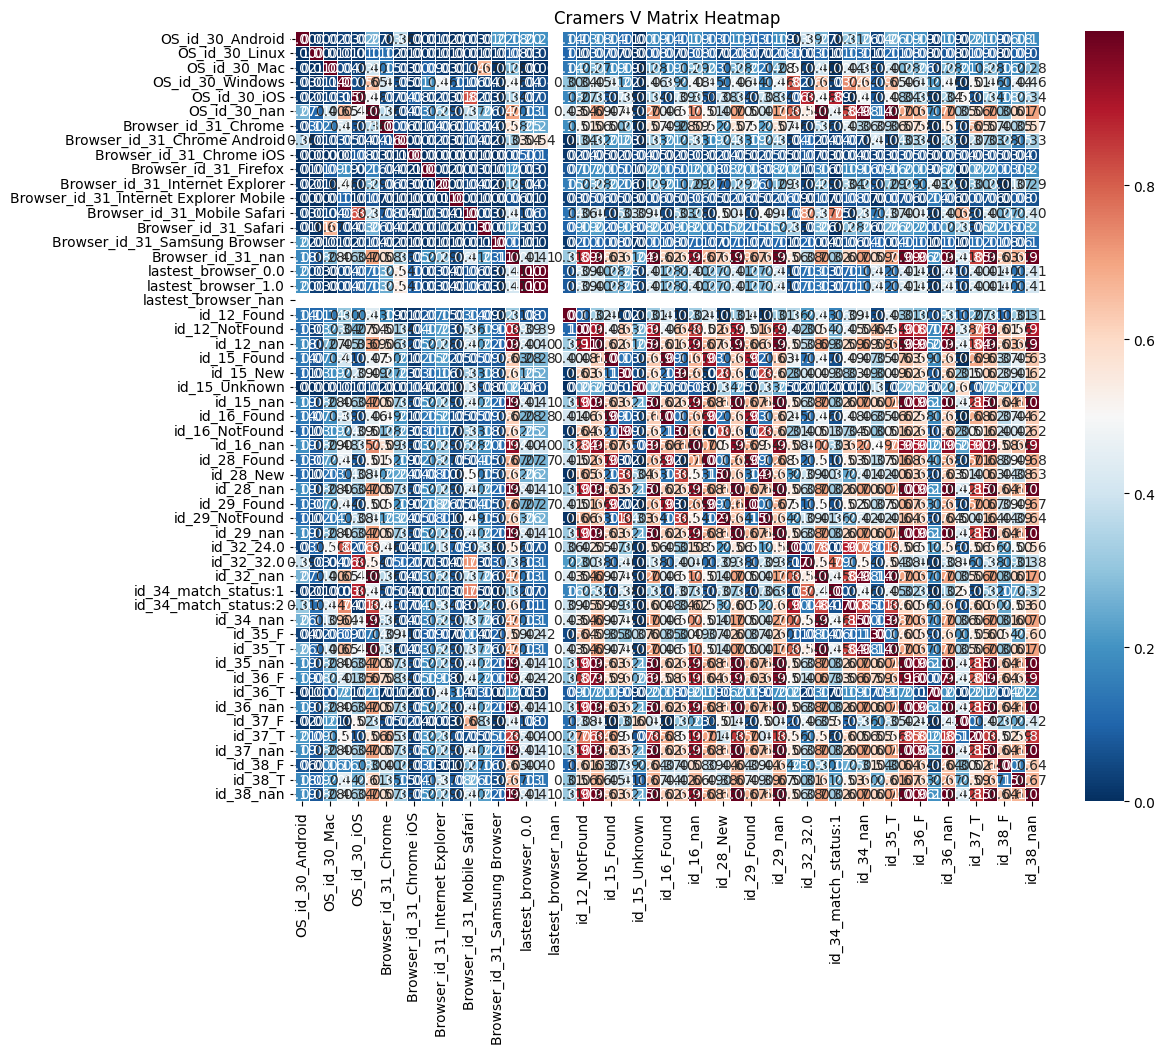

In [670]:
id_columns = train.loc[:, matching_columns]

# Create an empty DataFrame to store the results
cramers_v_matrix = pd.DataFrame(index=id_columns.columns, columns=id_columns.columns, dtype=float)

# Fill in the Cramers V values for each pair of columns
for col1 in id_columns.columns:
    for col2 in id_columns.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(id_columns[col1], id_columns[col2])

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, cmap='RdBu_r', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cramers V Matrix Heatmap')
plt.show()

In [671]:
# i want to remove collinear features in 'id_' columns with a threshold of 0.75
id_columns = matching_columns
drop_columns = identify_collinear_categorical_features(train, id_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)


Columns to drop: ['id_29_Found', 'id_29_nan', 'id_12_nan', 'id_32_32.0', 'id_36_F', 'id_35_nan', 'id_32_nan', 'id_34_match_status:2', 'id_16_nan', 'id_29_NotFound', 'id_12_NotFound', 'id_37_nan', 'id_34_nan', 'id_28_New', 'Browser_id_31_Mobile Safari', 'id_38_nan', 'id_34_match_status:1', 'id_15_nan', 'id_36_nan', 'id_28_Found', 'id_28_nan', 'id_35_T', 'id_16_Found', 'id_16_NotFound', 'id_37_T', 'id_32_24.0', 'lastest_browser_1.0']


In [672]:
# Remove the collinear features
train = remove_collinear_categorical_features(train, drop_columns)
test = remove_collinear_categorical_features(test, drop_columns)

In [673]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_2.pkl'
train.to_pickle(r'../dataset/train_11.pkl')

#save 'test' data to a pickle file named 'test_2.pkl'
test.to_pickle(r'../dataset/test_11.pkl')


In [674]:
# Read the 'train_2.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_11.pkl')

# Read the 'test_2.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_11.pkl')

In [675]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

#### DeviceType (nominal categoric)

In [676]:
for df in [train, test]:
  column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %74.62
['desktop' 'mobile' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %80.75
['desktop' 'mobile' nan]



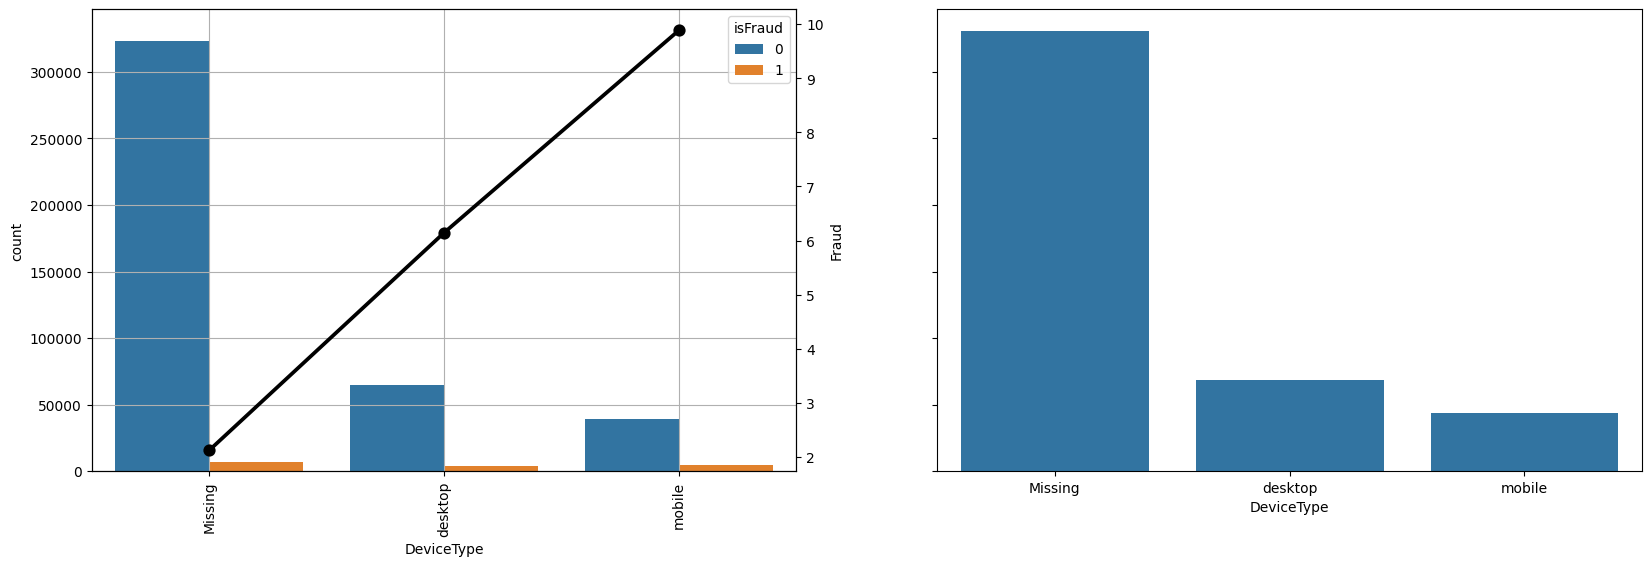

In [677]:
plot_col('DeviceType', df=train)

One Hot Encoding For DeviceType

In [678]:
# Perform one-hot encoding for DeviceType column on train
DeviceType_OHE = pd.get_dummies(train['DeviceType'], prefix='DeviceType', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, DeviceType_OHE], axis=1)

In [679]:
# Perform one-hot encoding for DeviceType column on test
DeviceType_OHE = pd.get_dummies(test['DeviceType'], prefix='DeviceType', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, DeviceType_OHE], axis=1)

In [680]:
# original 'DeviceType' column dropped
train.drop('DeviceType', axis=1, inplace=True)
test.drop('DeviceType', axis=1, inplace=True)

In [681]:
test['isFraud'].value_counts(dropna=False)

isFraud
0    142535
1      5100
Name: count, dtype: int64

In [682]:
[col for col in df.columns if col.startswith('DeviceType')]

['DeviceType']

In [683]:
# i want to remove collinear features in 'DeviceType' columns with a threshold of 0.75
id_columns = [col for col in train.columns if col.startswith('DeviceType')]
drop_columns = identify_collinear_categorical_features(train, id_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)


Columns to drop: []


In [684]:
# Remove the collinear features
train = remove_collinear_categorical_features(train, drop_columns)
test = remove_collinear_categorical_features(test, drop_columns)

#### DeviceInfo(nominal categoric)

In [685]:
for df in [train, test]:
  column_details(regex='DeviceInfo', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 1583, %78.49
['0PAJ5' '0PJA2' '0PM92' ... 'verykools5035' 'xs-Z47b7VqTMxs' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 962, %84.16
['2PYB2' '4009F' '4013M Build/KOT49H' '4047A Build/NRD90M'
 '4047G Build/NRD90M' '47418' '5010G Build/MRA58K' '5010S Build/MRA58K'
 '5011A Build/NRD90M' '5012G Build/MRA58K' '5015A Build/LMY47I'
 '5025G Build/LMY47I' '5044A' '5049W Build/NRD90M' '5051A Build/MMB29M'
 '5054S Build/LMY47V' '5056A Build/MMB29M' '5056N' '5080A Build/MRA58K'
 '5085B Build/MRA58K' '6037B' '6039A Build/LRX22G' '6045I Build/LRX22G'
 '6055B' '7048A Build/LRX22G' '7_Plus' '8050G Build/LMY47I'
 '8080 Build/LRX21M' '9008A Build/NRD90M' 'A0001' 'A3-A20' 'A463BG'
 'A574BL Build/NMF26F' 'A577VL' 'AERIAL' 'AKUS' 'ALCATEL'
 'ALCATEL ONE TOUCH 7047A Build/JDQ39' 'ALE-L21 Build/HuaweiALE-L21'
 'ALE-L23 Build/HuaweiALE-L23' 'ALP-L09 Build/HUAWEIALP-L09'
 'AL

In [686]:
# Adding new column derived from DeviceInfo ( new column: device_name)
def setDevice(df):
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 500].index), 'device_name'] = "Others"
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

In [687]:
train['device_name'].value_counts(dropna=False)

device_name
NaN           347629
Windows        38094
iOS Device     16572
MacOS          10506
Samsung         9260
Trident         6221
Others          5439
RV              3657
Motorola        2058
LG              1800
Huawei          1669
Name: count, dtype: int64

In [688]:
test['device_name'].value_counts(dropna=False)

device_name
NaN           124245
Windows         9628
iOS Device      3210
Samsung         2832
MacOS           2067
Others          1590
Trident         1219
Motorola         877
RV               728
Huawei           708
LG               531
Name: count, dtype: int64

One Hot Encoding For Device Name

In [689]:
# Perform one-hot encoding for device_name column on train
device_name_OHE = pd.get_dummies(train['device_name'], prefix='device_name', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
train = pd.concat([train, device_name_OHE], axis=1)

In [690]:
# Perform one-hot encoding for device_name column on test
device_name_OHE = pd.get_dummies(test['device_name'], prefix='device_name', drop_first=False, dtype=int, dummy_na=True)

# Add the resulting one-hot encoded data to the original DataFrames
test = pd.concat([test, device_name_OHE], axis=1)

In [691]:
# original 'device_name' column dropped
train.drop('device_name', axis=1, inplace=True)
test.drop('device_name', axis=1, inplace=True)

In [692]:
# Drop the original column
train.drop('DeviceInfo', axis=1, inplace=True)
test.drop('DeviceInfo', axis=1, inplace=True)

In [693]:
# i want to remove collinear features in 'device_name' columns with a threshold of 0.75
id_columns = [col for col in train.columns if col.startswith('device_name')]
drop_columns = identify_collinear_categorical_features(train, id_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)


Columns to drop: []


In [694]:
# Remove the collinear features
train = remove_collinear_categorical_features(train, drop_columns)
test = remove_collinear_categorical_features(test, drop_columns)

In [695]:
gc.collect()

0

#### Pickling Final Train and Test

In [696]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1=3.pkl'
train.to_pickle(r'../dataset/train_12.pkl')

#save 'test' data to a pickle file named 'test_3.pkl'
test.to_pickle(r'../dataset/test_12.pkl')


In [697]:
# Read the 'train_3.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_12.pkl')

# Read the 'test_3.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_12.pkl')

#### Removing Date columns

In [698]:
# Date columns are not indicators
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('DT', axis=1, inplace=True)

test.drop('TransactionDT', axis=1, inplace=True)
test.drop('DT', axis=1, inplace=True)

#### Defining X sets and Y

In [699]:
# Target variable for training set (y_train)
y_train = train['isFraud']

# Independent variables for training set (X_train)
X_train = train.drop(['isFraud'], axis=1)

# Target variable for test set (y_test)
y_test = test['isFraud']

# Independent variables for test set (X_test)
X_test = test.drop(['isFraud'], axis=1)

#### Balancing Parameter ( Scale Pos Weight)

In [700]:
# Get the count of negative and positive examples
count_negative = (y_train == 0).sum()
count_positive = (y_train == 1).sum()

# Calculate the value of scale_pos_weight
scale_pos_weight = math.sqrt(count_negative / count_positive)

#### XGBOOST - 45 important features and default parameters

In [701]:
# X_train for final model with default params
X_train_4 = X_train[['V264',
 'addr2_target_encoded',
 'V283',
 'C1',
 'C5',
 'R_emaildomain_bin_google',
 'M4_nan',
 'V30',
 'V156',
 'D3',
 'card2_target_encoded',
 'V67',
 'V198',
 'M5_T',
 'device_name_Trident',
 'ProductCD_R',
 'V62',
 'id_12_Found',
 'M6_F',
 'V44',
 'D2',
 'V54',
 'P_emaildomain_bin_anonymous',
 'M9_F',
 'addr_target_encoded',
 'D8',
 'card3_target_encoded',
 'Browser_id_31_Internet Explorer',
 'V13',
 'DeviceType_mobile',
 'V307',
 'M3_F',
 'V86',
 'TransactionAmt',
 'V289',
 'OS_id_30_Mac',
 'V312',
 'V160',
 'D4',
 'card6_debit',
 'V142',
 'V47',
 'V80',
 'TransactionAmt_decimal',
 'P_emaildomain_suffix_us',
 'D15']]

In [702]:
# X_test for final model with default params
X_test_4 = X_test[['V264',
 'addr2_target_encoded',
 'V283',
 'C1',
 'C5',
 'R_emaildomain_bin_google',
 'M4_nan',
 'V30',
 'V156',
 'D3',
 'card2_target_encoded',
 'V67',
 'V198',
 'M5_T',
 'device_name_Trident',
 'ProductCD_R',
 'V62',
 'id_12_Found',
 'M6_F',
 'V44',
 'D2',
 'V54',
 'P_emaildomain_bin_anonymous',
 'M9_F',
 'addr_target_encoded',
 'D8',
 'card3_target_encoded',
 'Browser_id_31_Internet Explorer',
 'V13',
 'DeviceType_mobile',
 'V307',
 'M3_F',
 'V86',
 'TransactionAmt',
 'V289',
 'OS_id_30_Mac',
 'V312',
 'V160',
 'D4',
 'card6_debit',
 'V142',
 'V47',
 'V80',
 'TransactionAmt_decimal',
 'P_emaildomain_suffix_us',
 'D15']]

In [703]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_4 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_4.fit(X_train_4, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_4 = xgb_4.predict(X_test_4)



In [704]:
# Probas for train
y_train_xgb_proba_4 = xgb_4.predict_proba(X_train_4)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_4)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_4 = xgb_4.predict_proba(X_test_4)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_4)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9595233271781525
Test AUC: 0.882539419626552


#### SAVING THE OUTPUTS OF THE XGBOOST MODEL

##### WITH SHORT LIST

In [705]:
# Calculating predictions for train
y_train_pred_xgb_4 = xgb_4.predict(X_train_4)
y_train_xgb_proba_4 = xgb_4.predict_proba(X_train_4)
y_train_xgb_proba_4 = y_train_xgb_proba_4[:,1:]

train_result_df = pd.DataFrame()
train = y_train
prediction = y_train_pred_xgb_4
proba = y_train_xgb_proba_4

train_result_df['isFraud']=train
train_result_df["isFraud_xgb"]= prediction
train_result_df["isFraud_xgb_proba"]= proba

#with short list
merged_df_train_4 = X_train_4.merge(train_result_df, left_index=True, right_index=True)

In [706]:
# Calculating predictions for test
y_pred_xgb_4 = xgb_4.predict(X_test_4)
y_pred_xgb_proba_4 = xgb_4.predict_proba(X_test_4)
y_pred_xgb_proba_4 = y_pred_xgb_proba_4[:,1:]

test_result_df = pd.DataFrame()
test = y_test
prediction = y_pred_xgb_4
proba = y_pred_xgb_proba_4

test_result_df['isFraud']=test
test_result_df["isFraud_xgb"]= prediction
test_result_df["isFraud_xgb_proba"]= proba

#with short list
merged_df_test_4 = X_test_4.merge(test_result_df, left_index=True, right_index=True)

In [707]:
#pickling datasets
#Save 'merged_df_train_4' data to a pickle file named 'merged_df_train_4.pkl'
merged_df_train_4.to_pickle(r'../dataset/merged_df_train_4.pkl')

#save 'merged_df_test_4' data to a pickle file named 'merged_df_test_4.pkl'
merged_df_test_4.to_pickle(r'../dataset/merged_df_test_4.pkl')


#### LightGBM - 50 important features and default parameters

In [708]:
X_train_lgbm_2 = X_train[['card1',
 'TransactionAmt',
 'card2_target_encoded',
 'addr_target_encoded',
 'addr1_target_encoded',
 'dist1',
 'D15',
 'id_02',
 'TransactionAmt_decimal',
 'C1',
 'D4',
 'card5_target_encoded',
 'D2',
 'D10',
 'D11',
 'V307',
 'D1',
 'D8',
 'D5',
 'V310',
 'D3',
 'id_05',
 'V127',
 'id_06',
 'V314',
 'D9',
 'V264',
 'V312',
 'id_01',
 'D14',
 'V203',
 'C5',
 'D6',
 'V283',
 'D12',
 'V36',
 'V96',
 'V221',
 'V62',
 'V82',
 'V282',
 'V54',
 'V76',
 'V37',
 'V20',
 'V5',
 'V44',
 'V285',
 'V77',
 'V56']]

In [709]:
X_test_lgbm_2 = X_test[['card1',
 'TransactionAmt',
 'card2_target_encoded',
 'addr_target_encoded',
 'addr1_target_encoded',
 'dist1',
 'D15',
 'id_02',
 'TransactionAmt_decimal',
 'C1',
 'D4',
 'card5_target_encoded',
 'D2',
 'D10',
 'D11',
 'V307',
 'D1',
 'D8',
 'D5',
 'V310',
 'D3',
 'id_05',
 'V127',
 'id_06',
 'V314',
 'D9',
 'V264',
 'V312',
 'id_01',
 'D14',
 'V203',
 'C5',
 'D6',
 'V283',
 'D12',
 'V36',
 'V96',
 'V221',
 'V62',
 'V82',
 'V282',
 'V54',
 'V76',
 'V37',
 'V20',
 'V5',
 'V44',
 'V285',
 'V77',
 'V56']]

In [710]:
lgbclf_2 = lgb.LGBMClassifier(
              
        random_state=1003,
        scale_pos_weight=scale_pos_weight,
        metric='auc',
        objective= 'binary',
        device = 'gpu',
        subsample= 0.9,
        reg_alpha= 0.6,
        num_leaves=100,
        n_estimators= 1000,
        max_depth=15,
        learning_rate=0.01,
        colsample_bytree= 0.3
    )

lgbclf_2.fit(X_train_lgbm_2,y_train)

#prediction
y_pred_lgbm_3 = lgbclf_2.predict(X_test_lgbm_2)

#classification report
print(classification_report(y_test, y_pred_lgbm_3))

#confusion matrix
print(confusion_matrix(y_test, y_pred_lgbm_3, normalize='true'))

[LightGBM] [Info] Number of positive: 15563, number of negative: 427342
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7585
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 50
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (13.52 MB) transferred to GPU in 0.088722 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035138 -> initscore=-3.312688
[LightGBM] [Info] Start training from score -3.312688


              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.57      0.40      0.47      5100

    accuracy                           0.97    147635
   macro avg       0.78      0.69      0.73    147635
weighted avg       0.96      0.97      0.97    147635

[[0.98927983 0.01072017]
 [0.60078431 0.39921569]]


In [711]:
# Probas for train
y_train_lgbm_proba = lgbclf_2.predict_proba(X_train_lgbm_2)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_lgbm_proba)
print(f'Train AUC: {train_auc}')

# Probas for test
y_test_lgbm_proba = lgbclf_2.predict_proba(X_test_lgbm_2)[:, 1]  
test_auc = roc_auc_score(y_test, y_test_lgbm_proba)
print(f'Test AUC: {test_auc}')

Train AUC: 0.9678204141219013
Test AUC: 0.8971523898155045


#### SAVING THE OUTPUTS OF THE LIGHTGBM MODEL

##### WITH SHORT LIST

In [712]:
# Calculating predictions for train
y_train_pred_lgbm = lgbclf_2.predict(X_train_lgbm_2)
y_train_lgbm_proba = lgbclf_2.predict_proba(X_train_lgbm_2)
y_train_lgbm_proba = y_train_lgbm_proba[:,1:]

train_result_df = pd.DataFrame()
train = y_train
prediction = y_train_pred_lgbm
proba = y_train_lgbm_proba

train_result_df['isFraud']=train
train_result_df["isFraud_lgbm"]= prediction
train_result_df["isFraud_lgbm_proba"]= proba

#with short list
merged_df_train_lgbm = X_train_lgbm_2.merge(train_result_df, left_index=True, right_index=True)

In [713]:
# Calculating predictions for test
y_pred_lgbm = lgbclf_2.predict(X_test_lgbm_2)
y_pred_lgbm_proba = lgbclf_2.predict_proba(X_test_lgbm_2)
y_pred_lgbm_proba = y_pred_lgbm_proba[:,1:]

test_result_df = pd.DataFrame()
test = y_test
prediction = y_pred_lgbm
proba = y_pred_lgbm_proba

test_result_df['isFraud']=test
test_result_df["isFraud_lgbm"]= prediction
test_result_df["isFraud_lgbm_proba"]= proba

#with short list
merged_df_test_lgbm = X_test_4.merge(test_result_df, left_index=True, right_index=True)

In [714]:
#pickling datasets
#Save 'merged_df_train_4' data to a pickle file named 'merged_df_train_4.pkl'
merged_df_train_lgbm.to_pickle(r'../dataset/merged_df_train_lgbm.pkl')

#save 'merged_df_test_4' data to a pickle file named 'merged_df_test_4.pkl'
merged_df_test_lgbm.to_pickle(r'../dataset/merged_df_test_lgbm.pkl')


In [715]:
# === === === === === === === === === === ===

In [716]:
# saving the Model 01 to use in web API
import joblib
filename01 = 'model_v5/model01_xgboost_joblib'
joblib.dump(xgb_4, filename01+".pkl")

# getting the description of dataset and saving
description = X_test_4.describe()
description.to_csv(filename01+'_describe_X.csv')
print("COPY NEXT TEXT AND SAVE IT INTO", filename01+'_info_X.txt')
X_test_4.info()

description = pd.DataFrame(y_pred_xgb_4).describe()
description.to_csv(filename01+'_describe_y.csv')

COPY NEXT TEXT AND SAVE IT INTO model_v5/model01_xgboost_joblib_info_X.txt
<class 'pandas.core.frame.DataFrame'>
Index: 147635 entries, 3429905 to 3577539
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   V264                             25169 non-null   float32
 1   addr2_target_encoded             132618 non-null  float64
 2   V283                             146640 non-null  float32
 3   C1                               147635 non-null  float64
 4   C5                               147635 non-null  float64
 5   R_emaildomain_bin_google         147635 non-null  int32  
 6   M4_nan                           147635 non-null  int32  
 7   V30                              135154 non-null  float32
 8   V156                             14699 non-null   float32
 9   D3                               90893 non-null   float64
 10  card2_target_encoded             145464 non-null  f

In [717]:
# saving the Model 02 to use in web API
import joblib
filename02 = 'model_v5/model02_lightgbm_joblib'
joblib.dump(lgbclf_2, filename02+".pkl")

# getting the description of dataset and saving
description = X_train_lgbm_2.describe()
description.to_csv(filename02+'_describe_X.csv')
print("COPY NEXT TEXT AND SAVE IT INTO", filename02+'_info_X.txt')
X_train_lgbm_2.info()

description = pd.DataFrame(y_pred_lgbm).describe()
description.to_csv(filename02+'_describe_y.csv')

COPY NEXT TEXT AND SAVE IT INTO model_v5/model02_lightgbm_joblib_info_X.txt
<class 'pandas.core.frame.DataFrame'>
Index: 442905 entries, 2987000 to 3429904
Data columns (total 50 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   card1                   442905 non-null  int64  
 1   TransactionAmt          442905 non-null  float64
 2   card2_target_encoded    436143 non-null  float64
 3   addr_target_encoded     392207 non-null  float64
 4   addr1_target_encoded    392207 non-null  float64
 5   dist1                   171642 non-null  float64
 6   D15                     370591 non-null  float64
 7   id_02                   112436 non-null  float64
 8   TransactionAmt_decimal  442905 non-null  int32  
 9   C1                      442905 non-null  float64
 10  D4                      312665 non-null  float64
 11  card5_target_encoded    439850 non-null  float64
 12  D2                      224113 non-null  float64
 

In [ ]:
# THE END ?